# Notebook Dedicated to Contrust Hand-craft Deep Learning Models - Define by hand the architecture and hyperparms with a Conv2D Hidden Layers.

In [1]:
#import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn
import pandas as pd

from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, normalize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, concatenate, Dropout, BatchNormalization, Activation, Flatten, Reshape
from keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils import shuffle
import optuna
from keras.backend import clear_session

# Useful Functions

## Multi-color Generator

In [2]:
import colorsys
# Función para generar variantes más claras y más oscuras de un color
def generate_color_variants(base_color, num_variants, factor = 0.3):
    # Convertir el color base a valores de HSV
    r, g, b = base_color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    # Generar variantes
    variants = []
    for i in range(1, num_variants + 1):
        # Hacer el color más claro
        lighter = colorsys.hls_to_rgb(h, min(1, l * (1 + factor * i)), s)
        # Hacer el color más oscuro
        darker = colorsys.hls_to_rgb(h, max(0, l * (1 - factor * i)), s)
        variants.append(lighter)
        variants.append(darker)
        
    return variants

# Color base (rojo)
base_red = (1, 0, 0) # RGB para rojo puro
# Color base (azuk)
base_blue = (0, 0, 1) # RGB para azul puro
num_variants = 5

red_variants = generate_color_variants(base_red, num_variants)
blue_variants = generate_color_variants(base_blue, num_variants)

## Resizing NumpyArrays of flatten pixels to Images dim1 x dim2

In [3]:
def resize_array(pixel_set, dim1, dim2):
    #Receiver a set of flat arrays (exm pixels_i) and reshape the sample of flatten pixels to recover the images dim1 x dim2
    
    imag_sample = [] #list that will contain the samples of images dim1 x dim2

    for pixels_sample_i in pixel_set:
        imag_recov = pixels_sample_i.reshape(dim1, dim2)
        imag_sample.append(imag_recov)

    return np.array(imag_sample)

## Kernel Size Function

In [4]:
def kernel_size(image_dim_in ,image_dim_out, strides):
    
    '''
    Funtion that return the kernel size K that must be used to obtain an output image with shape (image_dim_out_0, image_dim_out_1), given an stride S and assuming a padding P = 1.

    Parameters:
    - image_dim_(in,out): list with the (input, output) image shape;
    - strides: list of values with the desired strides;
    '''

    #Padding:
    P_0 = 0
    P_1 = 0

    image_dim_in_0 = image_dim_in[0]
    image_dim_in_1 = image_dim_in[1]

    image_dim_out_0 = image_dim_out[0]
    image_dim_out_1 = image_dim_out[1]

    strides_0 = strides[0]
    strides_1 = strides[1]

    kernel_size_0 = image_dim_in_0 + P_0 + strides_0*(1 - image_dim_out_0)
    kernel_size_1 = image_dim_in_1 + P_1 + strides_1*(1 - image_dim_out_1)

    if kernel_size_0 <= 0 or kernel_size_1 <= 0:
        print(f'Stride components S_0 = {strides_0} and S_1 = {strides_1} are giving a negative or cero Kernel with size ({kernel_size_0},{kernel_size_1}). Try a lower stride components')
        raise ValueError

    return [kernel_size_0, kernel_size_1]

# Load Data

In [4]:
image_dim = (10, 10)

#Directories
train_dataset_dir = "E:/Data/solars/mc/ML Data/Train/pd_dataframe/df_10_5500_(2.5_14)_(-5_7).csv"
test_dataset_dir = "E:/Data/solars/mc/ML Data/Test/pd_dataframe/df_10_5500_(2.5_14)_(-5_7).csv"

#Load in Pandas  DataFrame
df_train = shuffle(pd.read_csv(train_dataset_dir))
df_test = shuffle(pd.read_csv(test_dataset_dir))

In [5]:
df_train.describe()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
count,1.349021e+06,1.349021e+06,1.349021e+06,1.349021e+06,1.349021e+06,1.349021e+06,1.349021e+06,1.349021e+06,1.349021e+06,1.349021e+06,...,1.349021e+06,1.349021e+06,1.349021e+06,1.349021e+06,1.349021e+06,1.349021e+06,1.349021e+06,1.349021e+06,1.349021e+06,1.349021e+06
mean,9.993543e-02,9.980577e-02,1.005760e-01,1.043642e-01,1.059846e-01,1.048672e-01,1.035444e-01,1.025265e-01,1.017616e-01,1.009763e-01,...,1.008739e-01,1.000148e-01,9.908965e-02,9.825741e-02,9.783097e-02,9.800693e-02,4.772251e+00,4.096566e+03,7.322051e-01,2.677949e-01
std,6.464745e-02,8.595156e-02,1.630611e-01,2.294494e-01,2.108756e-01,1.741944e-01,1.494614e-01,1.303658e-01,1.140813e-01,1.008402e-01,...,2.009989e-01,1.661818e-01,1.431982e-01,1.257707e-01,1.109717e-01,9.900637e-02,1.813391e+00,1.072851e+03,4.428103e-01,4.428103e-01
min,2.500000e-11,1.428571e-11,9.090909e-12,5.555556e-12,2.564103e-12,1.190476e-12,7.751938e-13,5.847953e-13,5.617978e-13,5.714286e-13,...,2.564103e-12,1.234568e-12,7.812500e-13,6.250000e-13,5.434783e-13,5.434783e-13,2.500002e+00,3.176235e+01,0.000000e+00,0.000000e+00
25%,1.000000e-01,1.000000e-01,1.000000e-10,3.333333e-11,1.111111e-11,5.555556e-12,3.846154e-12,4.545455e-12,2.040816e-02,2.702703e-02,...,1.111111e-11,5.555556e-12,3.846154e-12,4.166667e-12,1.923077e-02,2.564103e-02,3.468300e+00,3.424202e+03,0.000000e+00,0.000000e+00
50%,1.000000e-01,1.000000e-01,1.000000e-01,1.000000e-10,2.500000e-11,1.666667e-11,3.703704e-02,5.000000e-02,6.060606e-02,6.818182e-02,...,2.500000e-11,1.666667e-11,3.703704e-02,4.705882e-02,5.714286e-02,6.521739e-02,4.118018e+00,4.333190e+03,1.000000e+00,0.000000e+00
75%,1.000000e-01,1.000000e-01,1.000000e-01,1.000000e-01,1.000000e-01,1.428571e-01,1.470588e-01,1.481481e-01,1.463415e-01,1.428571e-01,...,1.000000e-01,1.428571e-01,1.428571e-01,1.410256e-01,1.403509e-01,1.388889e-01,5.759998e+00,4.976413e+03,1.000000e+00,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.062500e-01,8.800000e-01,8.709677e-01,...,1.000000e+00,1.000000e+00,1.000000e+00,8.888889e-01,8.536585e-01,7.826087e-01,1.199876e+01,5.500000e+03,1.000000e+00,1.000000e+00


In [6]:
df_test.describe()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
count,1.058530e+05,1.058530e+05,1.058530e+05,1.058530e+05,1.058530e+05,1.058530e+05,1.058530e+05,1.058530e+05,1.058530e+05,1.058530e+05,...,1.058530e+05,1.058530e+05,1.058530e+05,1.058530e+05,1.058530e+05,1.058530e+05,105853.000000,105853.000000,105853.00000,105853.00000
mean,1.002283e-01,9.979783e-02,9.958949e-02,1.028242e-01,1.041983e-01,1.029729e-01,1.022066e-01,1.012160e-01,1.009131e-01,1.005162e-01,...,1.006398e-01,1.006360e-01,9.977991e-02,9.943178e-02,9.917479e-02,9.910808e-02,4.442687,4100.569736,0.51768,0.48232
std,6.668651e-02,9.169222e-02,1.683634e-01,2.276104e-01,2.074007e-01,1.711965e-01,1.480433e-01,1.297756e-01,1.145044e-01,1.017684e-01,...,1.990196e-01,1.656662e-01,1.434477e-01,1.266235e-01,1.123855e-01,1.006284e-01,1.620965,1074.302059,0.49969,0.49969
min,2.500000e-11,1.666667e-11,1.111111e-11,5.882353e-12,2.857143e-12,1.333333e-12,8.403361e-13,6.666667e-13,5.952381e-13,5.714286e-13,...,2.857143e-12,1.351351e-12,9.009009e-13,6.493506e-13,5.586592e-13,5.917160e-13,2.500107,44.561459,0.00000,0.00000
25%,1.000000e-01,1.000000e-01,1.000000e-10,3.333333e-11,1.111111e-11,5.555556e-12,3.846154e-12,4.000000e-12,2.000000e-02,2.564103e-02,...,1.111111e-11,5.882353e-12,4.000000e-12,4.166667e-12,2.000000e-02,2.500000e-02,3.429666,3429.710693,0.00000,0.00000
50%,1.000000e-01,1.000000e-01,1.000000e-01,1.000000e-10,2.500000e-11,1.428571e-11,3.703704e-02,4.761905e-02,5.882353e-02,6.666667e-02,...,2.500000e-11,1.666667e-11,3.846154e-02,4.761905e-02,5.882353e-02,6.578947e-02,3.873336,4338.892578,1.00000,0.00000
75%,1.000000e-01,1.000000e-01,1.000000e-01,1.000000e-01,1.000000e-01,1.428571e-01,1.428571e-01,1.445783e-01,1.428571e-01,1.428571e-01,...,1.000000e-01,1.428571e-01,1.428571e-01,1.428571e-01,1.428571e-01,1.395349e-01,4.873020,4980.766602,1.00000,1.00000
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.259259e-01,8.000000e-01,7.843137e-01,7.297297e-01,...,1.000000e+00,1.000000e+00,9.310345e-01,9.111111e-01,7.837838e-01,7.428571e-01,11.995671,5499.963379,1.00000,1.00000


# Information Check on Norm($\Delta\alpha$) Images of 8B-$\nu_e$ and 208-Tl

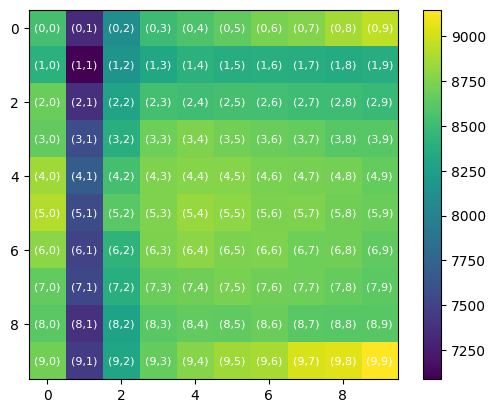

In [9]:
#Separate the solar_nue data from 208-Tl for train and test dataset
dataset_nue_train = (df_train[df_train['IsNu'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])
dataset_208tl_train = (df_train[df_train['IsTl'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])

dataset_nue_test = (df_train[df_train['IsNu'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])
dataset_208tl_test = (df_train[df_train['IsTl'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])

#Extract the pixels values of the normalized delta-alpha imaged and transform to np.array
pixels_nue_train = np.array(dataset_nue_train.filter(regex=pixel_pattern))
pixels_208tl_train = np.array(dataset_208tl_train.filter(regex=pixel_pattern))

pixels_nue_test = np.array(dataset_nue_test.filter(regex=pixel_pattern))
pixels_208tl_test = np.array(dataset_208tl_test.filter(regex=pixel_pattern))

#Recover the high-stat Delta-alpha distributions for solarnue and 208-Tl for train and test
DeltaAlpha_nue_train = np.sum(pixels_nue_train, axis = 0).reshape(10,10)
DeltaAlpha_208tl_train = np.sum(pixels_208tl_train, axis = 0).reshape(10,10)

DeltaAlpha_nue_test = np.sum(pixels_nue_test, axis = 0).reshape(10,10)
DeltaAlpha_208tl_test = np.sum(pixels_208tl_test, axis = 0).reshape(10,10)

#Plot: Just choose which image you want to observe
plt.imshow(DeltaAlpha_208tl_train)

# Añadir los índices sobre cada celda
num_rows, num_cols = DeltaAlpha_nue_test.shape
for i in range(num_rows):
    for j in range(num_cols):
        text = f"({i},{j})"
        plt.text(j, i, text, ha='center', va='center', color='white', fontsize=8)

plt.colorbar()
plt.show()

# Data Procesing

## Extract information and Define Energy Cuts

In [7]:
pixel_pattern = r'^pixel_\d+$'

energy_cut_train = 7
energy_cut_test = 7

### Extract Trainning Data

In [8]:
#Separate signal from background 
dataset_sig_train = (df_train[df_train['IsNu'] == 1]).reset_index()
dataset_bkg_train = (df_train[df_train['IsTl'] == 1]).reset_index()

#cut in solar energy
dataset_sig_train = (dataset_sig_train[dataset_sig_train['energy (MeV)'] <= energy_cut_train])

#Igualar cantidad de datos de neutrinos solares y de Tálio
N_solar_ev = dataset_sig_train.shape[0]
N_Tl_ev = dataset_bkg_train.shape[0]

if N_solar_ev > N_Tl_ev:
    dataset_sig_train = (dataset_sig_train.iloc[:N_Tl_ev, :]).reset_index()

else:
    dataset_bkg_train = (dataset_bkg_train.iloc[:N_solar_ev, :]).reset_index()
    
# Separate Features for signal and background: Useful for plots
df_pixel_sig_train = dataset_sig_train.filter(regex=pixel_pattern)
df_energy_sig_train = (dataset_sig_train[['energy (MeV)']])
df_radi_sig_train = (dataset_sig_train[['radius (mm)']])
df_label_sig_train = pd.DataFrame(dataset_sig_train, columns = ['IsNu', 'IsTl'])

df_pixel_bkg_train = dataset_bkg_train.filter(regex=pixel_pattern)
df_energy_bkg_train = (dataset_bkg_train[['energy (MeV)']])
df_radi_bkg_train = (dataset_bkg_train[['radius (mm)']])
df_label_bkg_train = pd.DataFrame(dataset_bkg_train, columns = ['IsNu', 'IsTl'])

# Also save the join bkg+sig datasets and its labels to perform the standard scaler overall data
df_pixel_train = pd.concat([df_pixel_sig_train, df_pixel_bkg_train])
df_energy_train = pd.concat([df_energy_sig_train, df_energy_bkg_train])
df_radi_train = pd.concat([df_radi_sig_train, df_radi_bkg_train])
df_labels_train = pd.concat([df_label_sig_train, df_label_bkg_train])
labels_train = np.array(df_labels_train)

In [9]:
dataset_sig_train.shape

(361261, 106)

In [10]:
dataset_bkg_train.shape

(361261, 105)

### Extract Test Data

In [11]:
equal_evs = True #Cambiar a True para Igualar eventos de 208-Tl y Solar Nu en test dataset!

#Separate signal from background 
dataset_sig_test = (df_test[df_test['IsNu'] == 1])
dataset_bkg_test = (df_test[df_test['IsTl'] == 1])

#cut in solar energy
dataset_sig_test = (dataset_sig_test[dataset_sig_test['energy (MeV)'] <= energy_cut_test])

if equal_evs:
    #Igualar cantidad de datos de neutrinos solares y de Tálio
    N_solar_ev = dataset_sig_test.shape[0]
    N_Tl_ev = dataset_bkg_test.shape[0]
    
    if N_solar_ev > N_Tl_ev:
        dataset_sig_test = (dataset_sig_test.iloc[:N_Tl_ev, :]).reset_index()
    
    else:
        dataset_bkg_test = (dataset_bkg_test.iloc[:N_solar_ev, :]).reset_index()

df_test_cut = shuffle(pd.concat([dataset_sig_test, dataset_bkg_test]))
        

#Separate Features
df_pixel_test = df_test_cut.filter(regex=pixel_pattern)
df_energy_test = df_test_cut[['energy (MeV)']]
df_radi_test = df_test_cut[['radius (mm)']]
df_labels_test = pd.DataFrame(df_test_cut, columns = ['IsNu', 'IsTl'])
labels_test = np.array(df_labels_test)

In [11]:
np.max(df_pixel_train)

0.9999999999625008

## Data Transformation

Choose a Data Transformation Option by running the corresponding cell

### Identity Transform - NOT WORKNING FOR NOW!

In [20]:
scaler_pixels_train = FunctionTransformer()
scaler_energy_train = FunctionTransformer()
scaler_position_train = FunctionTransformer()

# Test Transformation History
scaler_pixels_test = FunctionTransformer() 
scaler_energy_test = FunctionTransformer()
scaler_position_test = FunctionTransformer()

### Standard Scaler

In [23]:
# Train Transformation History
scaler_pixels_train = StandardScaler() 
scaler_energy_train = StandardScaler()
scaler_position_train = StandardScaler()

# Test Transformation History
scaler_pixels_test = StandardScaler() 
scaler_energy_test = StandardScaler() 
scaler_position_test = StandardScaler()

### Normalize

### MinMax Scaler

In [58]:
# Train Transformation History
epsilon = 1e-2
min_val = np.min(df_pixel_train) + epsilon # equals to zero + epsilon
max_val = np.max(df_pixel_train) + epsilon # equals to one

#scaler_pixels_train = MinMaxScaler(feature_range=(min_val, max_val)) 
scaler_energy_train = MinMaxScaler(feature_range=(min_val, max_val))
scaler_position_train = MinMaxScaler(feature_range=(min_val, max_val))

# Test Transformation History
scaler_pixels_test = MinMaxScaler(feature_range=(min_val, max_val)) 
scaler_energy_test = MinMaxScaler(feature_range=(min_val, max_val)) 
scaler_position_test = MinMaxScaler(feature_range=(min_val, max_val))

### Pipeline MinMaxScaler(StandardScaler())

In [12]:
# Train Transformation History

#Intervals for MinMax Scaler ------------------------------------
epsilon = 1e-2
min_val = np.min(df_pixel_train) + epsilon # equals to zero + epsilon
max_val = np.max(df_pixel_train) + epsilon # equals to one + epsilon
# ---------------------------------------------------------------

scaler_pixels_train = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])
scaler_energy_train = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])
scaler_position_train = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])
# Test Transformation History
scaler_pixels_test = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])
scaler_energy_test = Pipeline([('standardization', StandardScaler()),
                               ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])
scaler_position_test = Pipeline([('standardization', StandardScaler()),
                                 ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])

### Train Dataset Transformation

In [13]:
#pixel_train_transf = scaler_pixels_train.fit_transform(df_pixel_train)
pixel_train_transf = np.array(df_pixel_train) + epsilon
energy_train_transf = scaler_energy_train.fit_transform(df_energy_train).T[0]

#radial position to volume normalization Transformation
vol = 5500**3 
position_train_transf_volnorm = (np.array(df_radi_train).T[0]**3)/vol

position_train_transf = scaler_position_train.fit_transform(position_train_transf_volnorm.reshape(-1, 1)).T[0]

In [14]:
energy_train_transf.shape

(722522,)

### Test Dataset Transformation

In [15]:
#pixel_test_transf = scaler_pixels_test.fit_transform(df_pixel_test)
pixel_test_transf = np.array(df_pixel_test) + epsilon
energy_test_transf = scaler_energy_test.fit_transform(df_energy_test).T[0]

#radial position to volume normalization Transformationm
vol = 5500**3 
position_test_transf_volnorm = (np.array(df_radi_test).T[0]**3)/vol

position_test_transf = scaler_position_test.fit_transform(position_test_transf_volnorm.reshape(-1, 1)).T[0]

In [16]:
energy_test_transf.shape

(89386,)

### Separation of sig from bkg in the Train and Test Datasets

In [17]:
#Separar sig from bkg and train from test
IsNu = np.array([1,0])
IsTl = np.array([0,1])

#Train: Separation sig from bkg
pixel_train_transf_sig = pixel_train_transf[np.array(df_labels_train == IsNu)[:,0]]
pixel_train_transf_bkg = pixel_train_transf[np.array(df_labels_train == IsTl)[:,0]]

energy_train_transf_sig = energy_train_transf[np.array(df_labels_train == IsNu)[:,0]]
energy_train_transf_bkg = energy_train_transf[np.array(df_labels_train == IsTl)[:,0]]

position_train_transf_sig = position_train_transf[np.array(df_labels_train == IsNu)[:,0]]
position_train_transf_bkg = position_train_transf[np.array(df_labels_train == IsTl)[:,0]]

#Test: Separation sig from bkg
pixel_test_transf_sig = pixel_test_transf[np.array(df_labels_test == IsNu)[:,0]]
pixel_test_transf_bkg = pixel_test_transf[np.array(df_labels_test == IsTl)[:,0]]

pixel_test_transf_sig = pixel_test_transf[np.array(df_labels_test == IsNu)[:,0]]
pixel_test_transf_bkg = pixel_test_transf[np.array(df_labels_test == IsTl)[:,0]]

energy_test_transf_sig = energy_test_transf[np.array(df_labels_test == IsNu)[:,0]]
energy_test_transf_bkg = energy_test_transf[np.array(df_labels_test == IsTl)[:,0]]

position_test_transf_sig = position_test_transf[np.array(df_labels_test == IsNu)[:,0]]
position_test_transf_bkg = position_test_transf[np.array(df_labels_test == IsTl)[:,0]]

labels_test_sig = labels_test[np.array(labels_test == IsNu)[:,0]]
labels_test_bkg = labels_test[np.array(labels_test == IsTl)[:,0]]

### Plots of the Transformed Features and Datasets

#### Pixels 2D Images

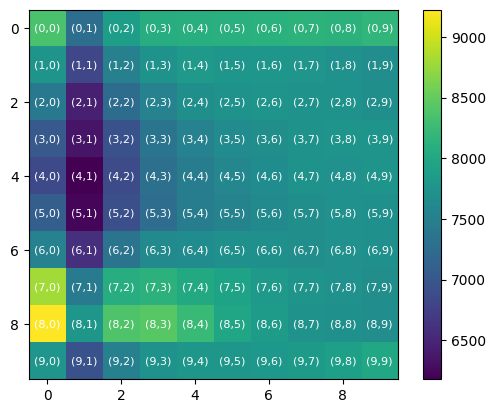

In [18]:
DeltaAlpha_sig_train_transf = np.sum(pixel_train_transf_sig, axis = 0).reshape(10,10)
DeltaAlpha_bkg_train_transf = np.sum(pixel_train_transf_bkg, axis = 0).reshape(10,10)

#Plot: Just choose which image you want to observe
plt.imshow(DeltaAlpha_sig_train_transf)

# Añadir los índices sobre cada celda
num_rows, num_cols = DeltaAlpha_nue_test.shape
for i in range(num_rows):
    for j in range(num_cols):
        text = f"({i},{j})"
        plt.text(j, i, text, ha='center', va='center', color='white', fontsize=8)

plt.colorbar()
plt.show()

#### Pixel_i Distributions

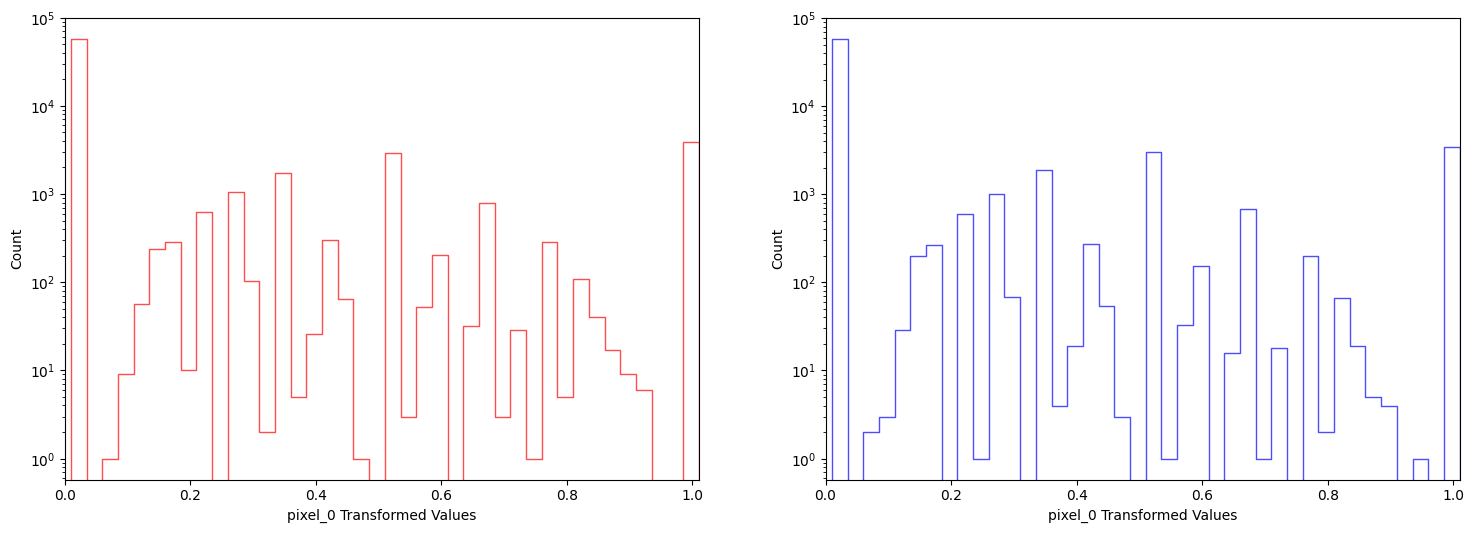

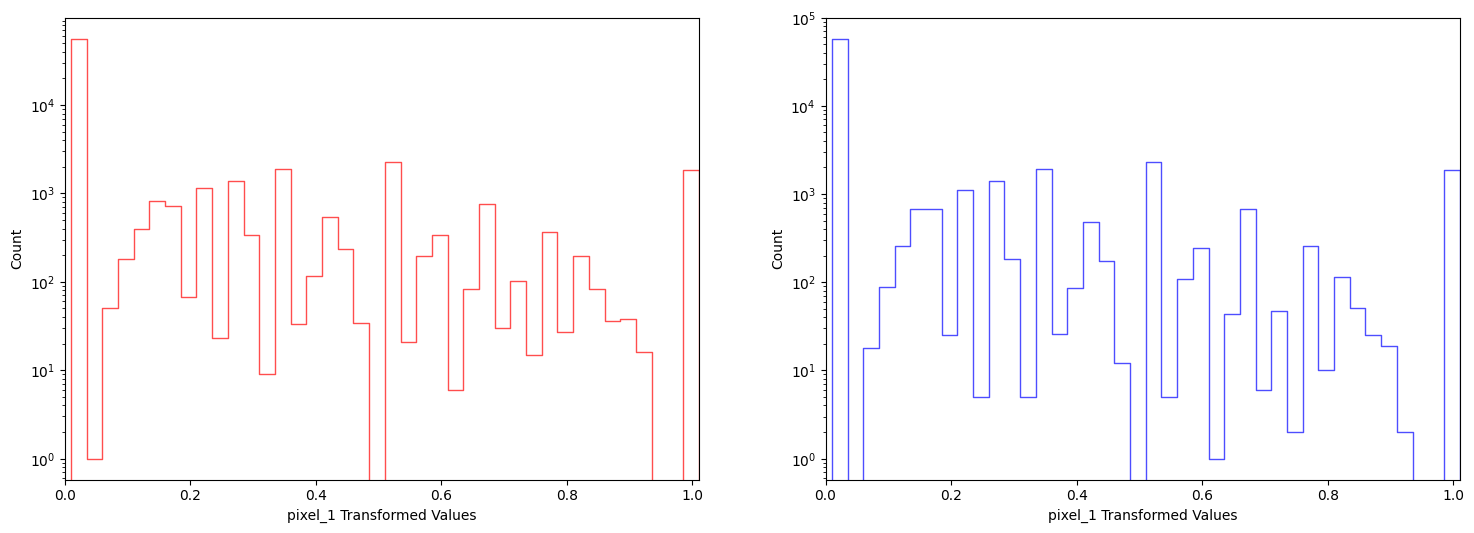

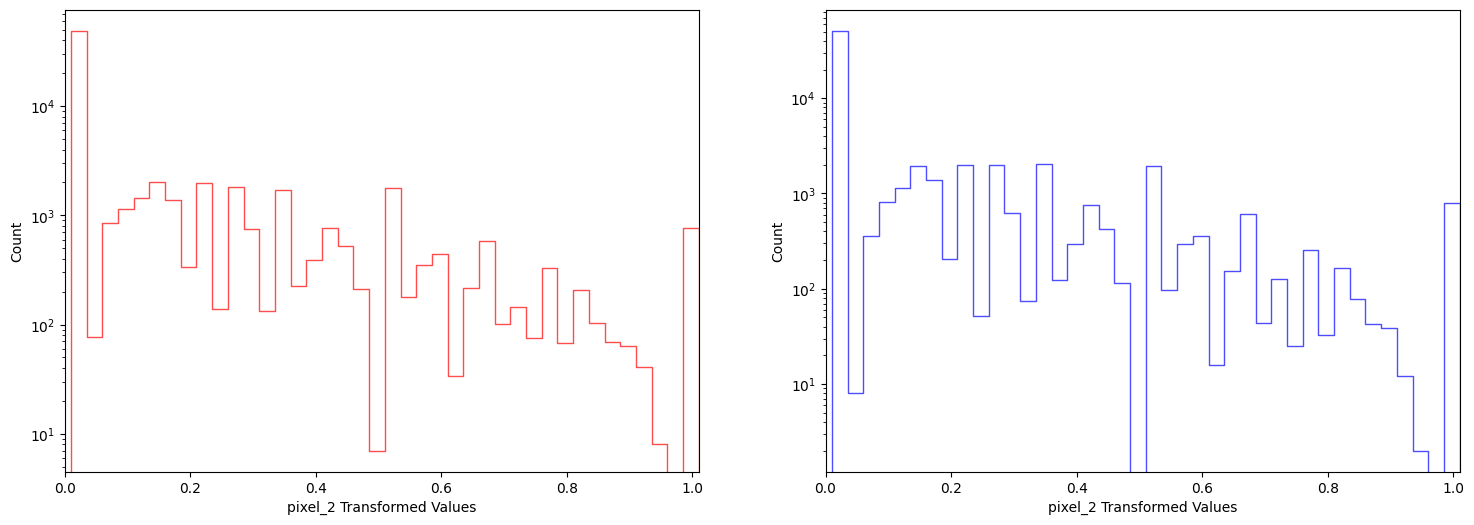

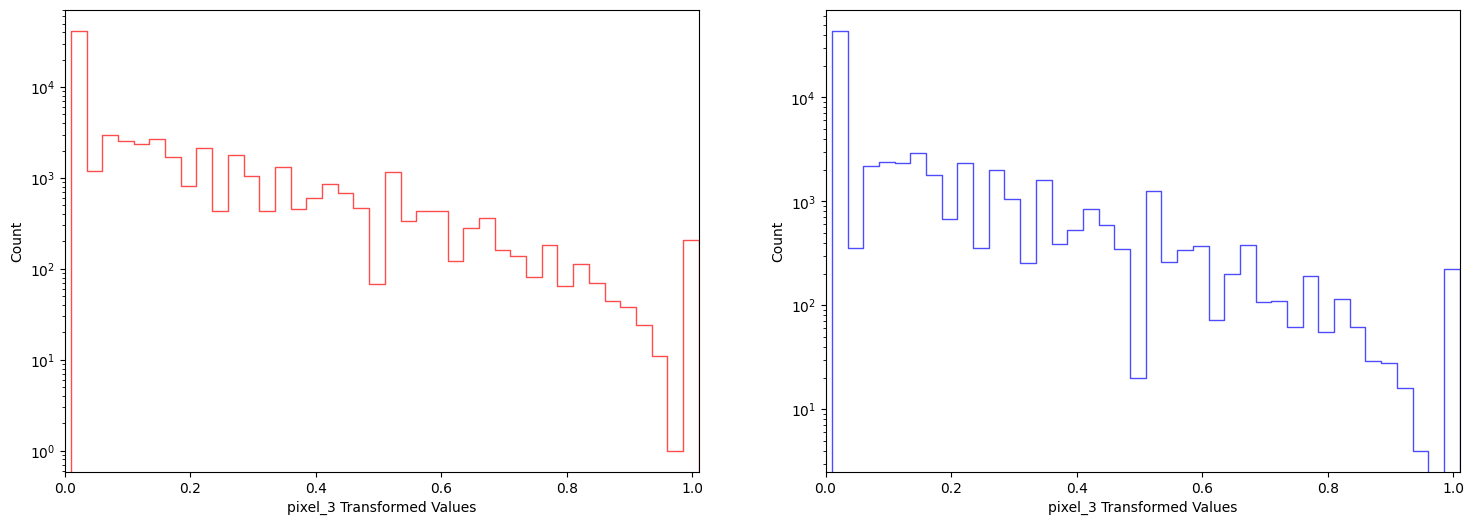

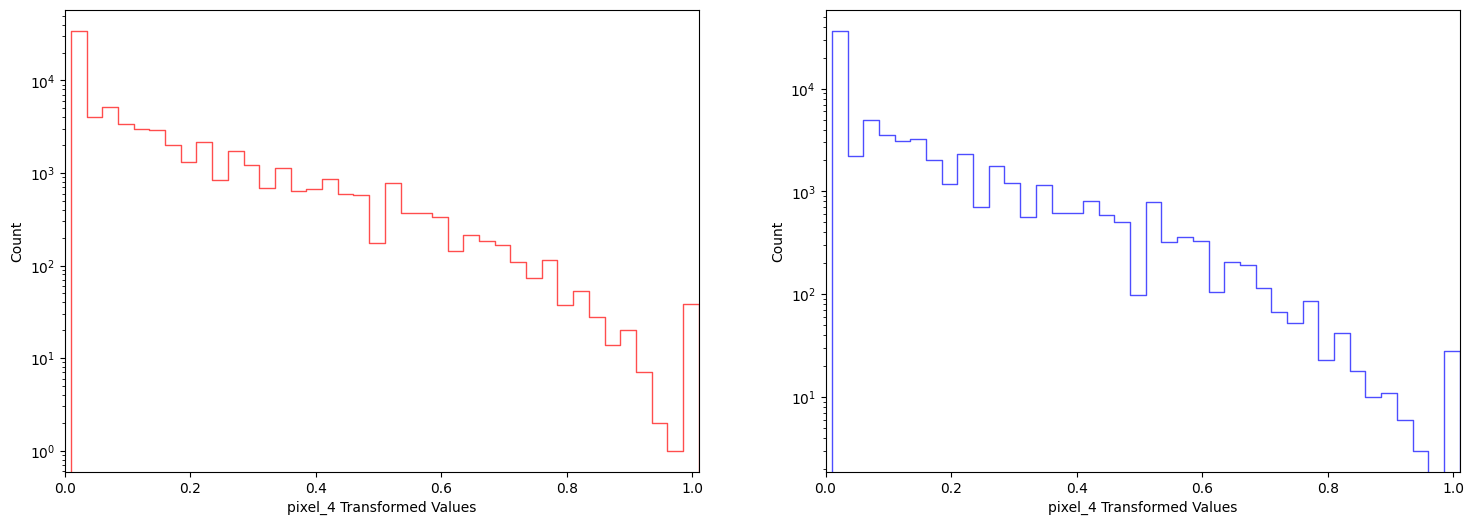

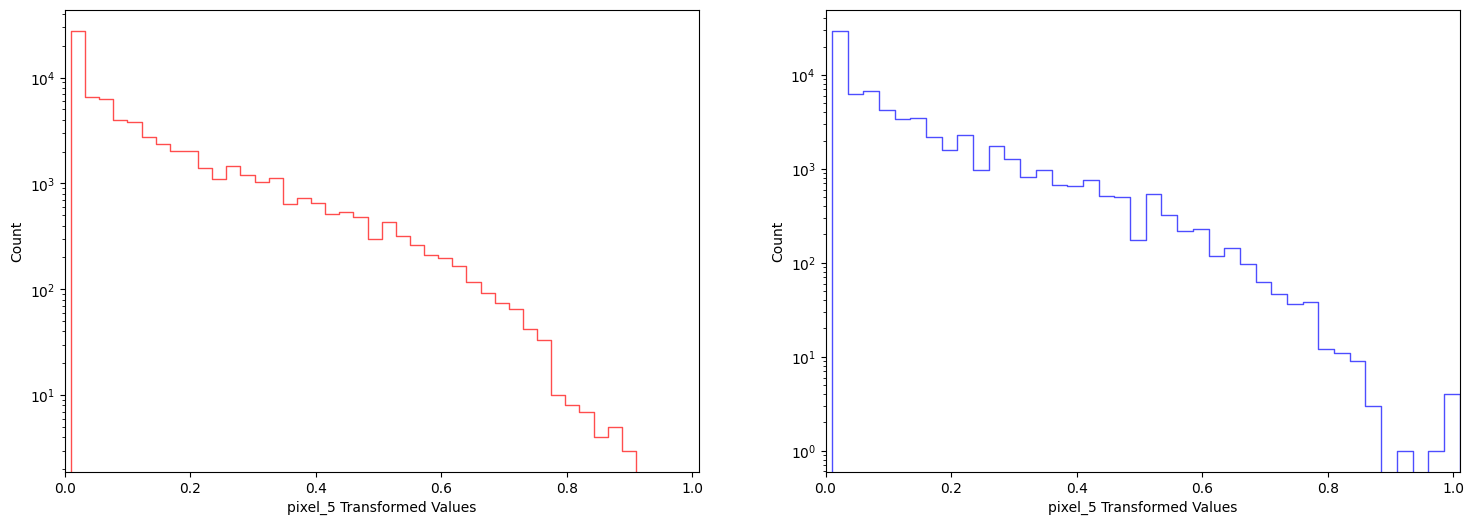

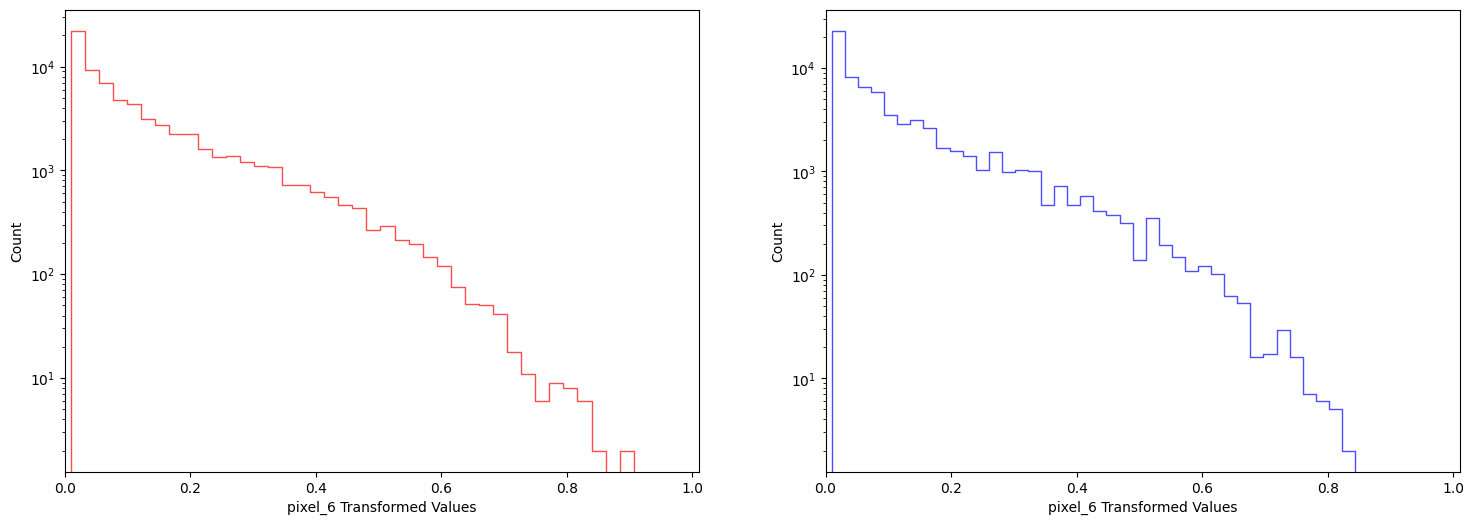

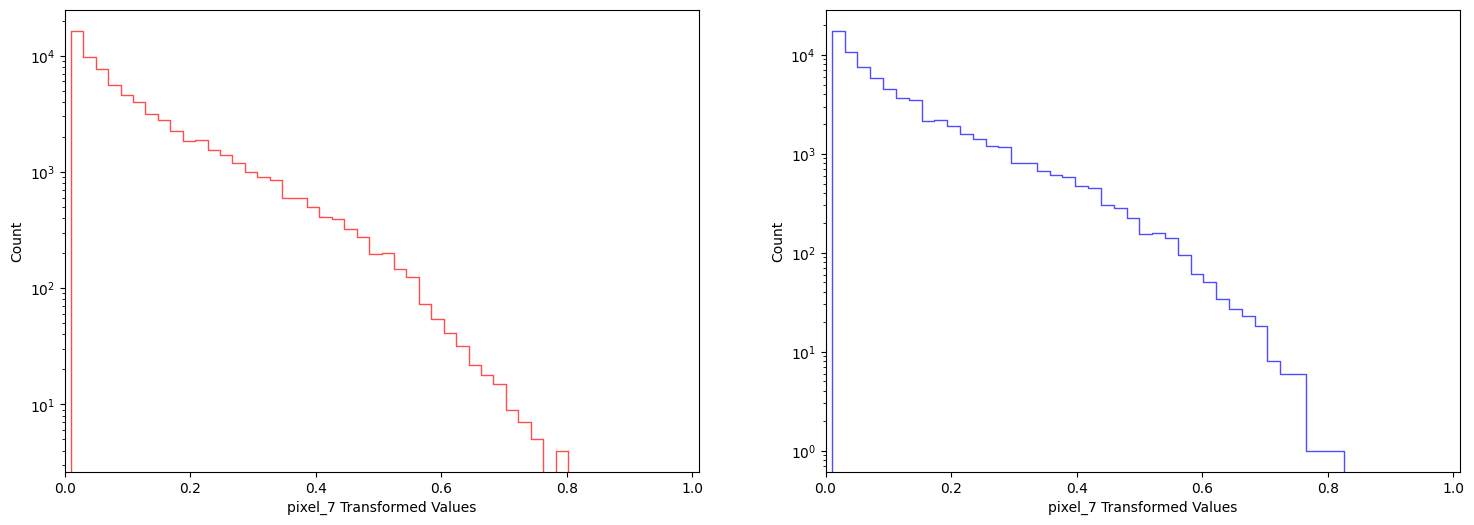

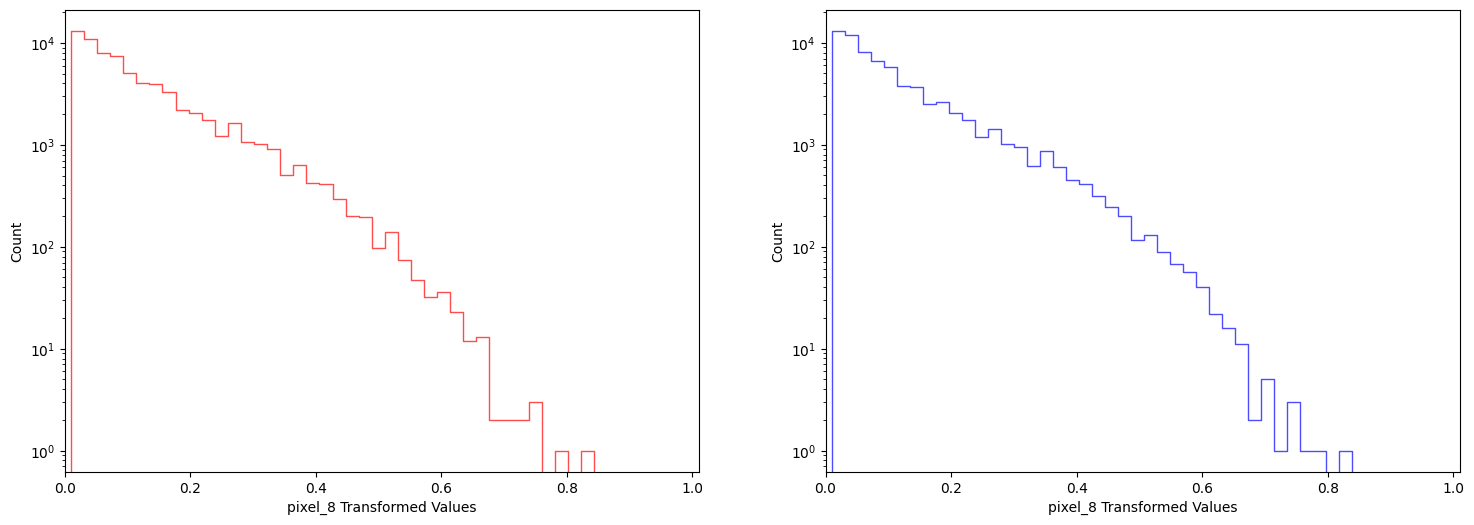

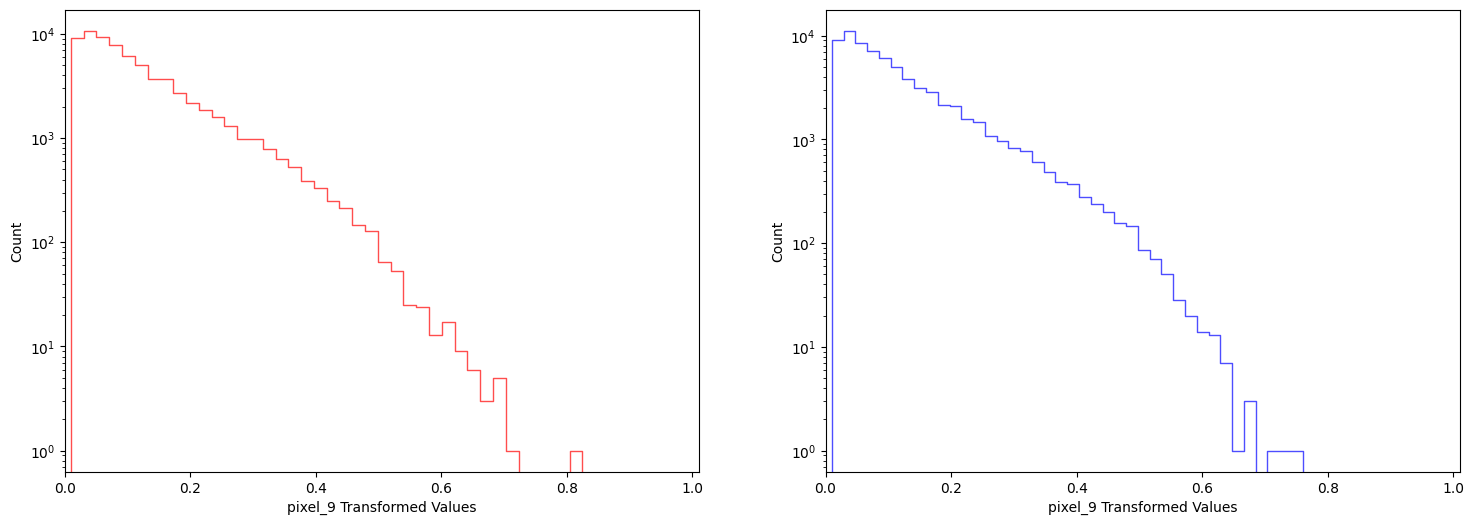

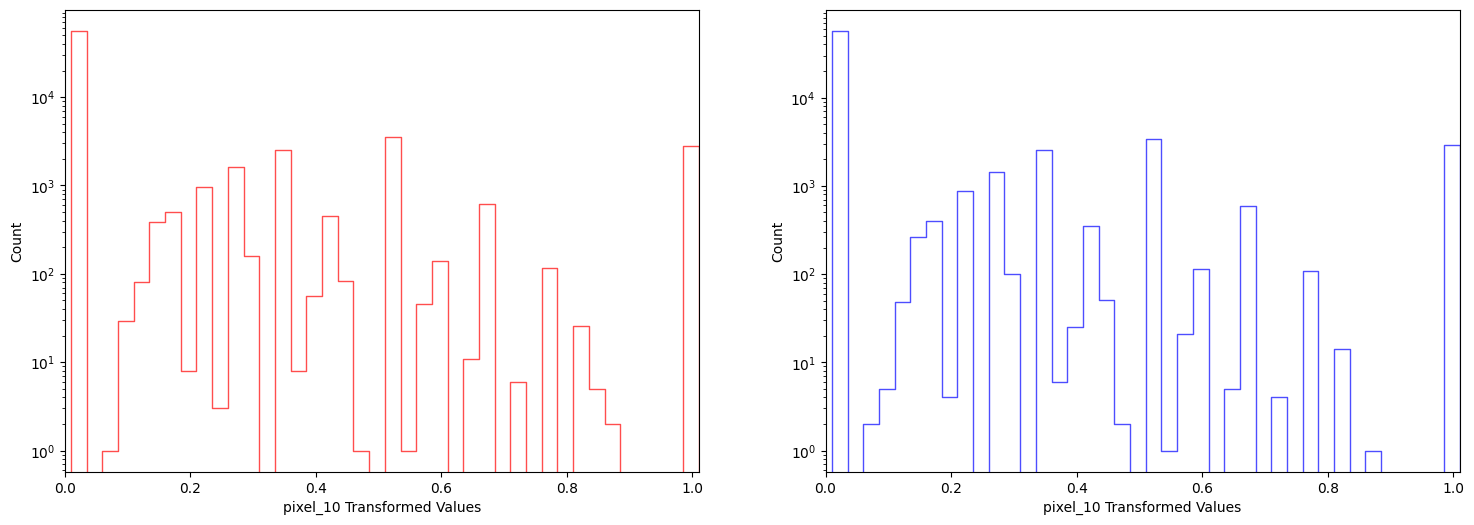

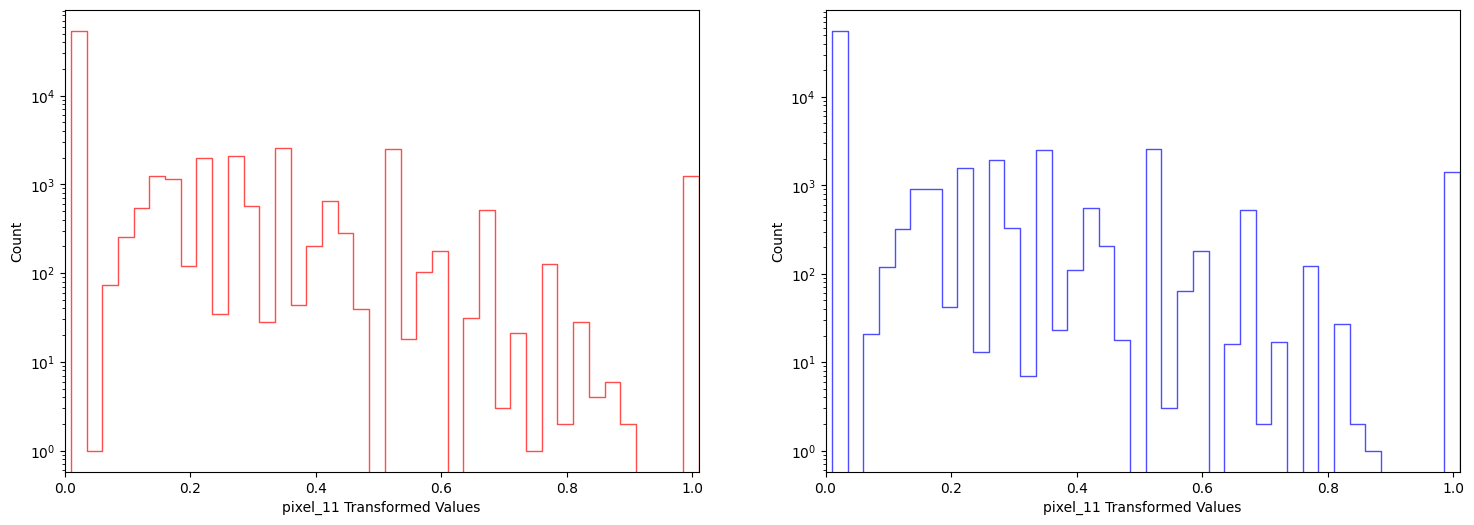

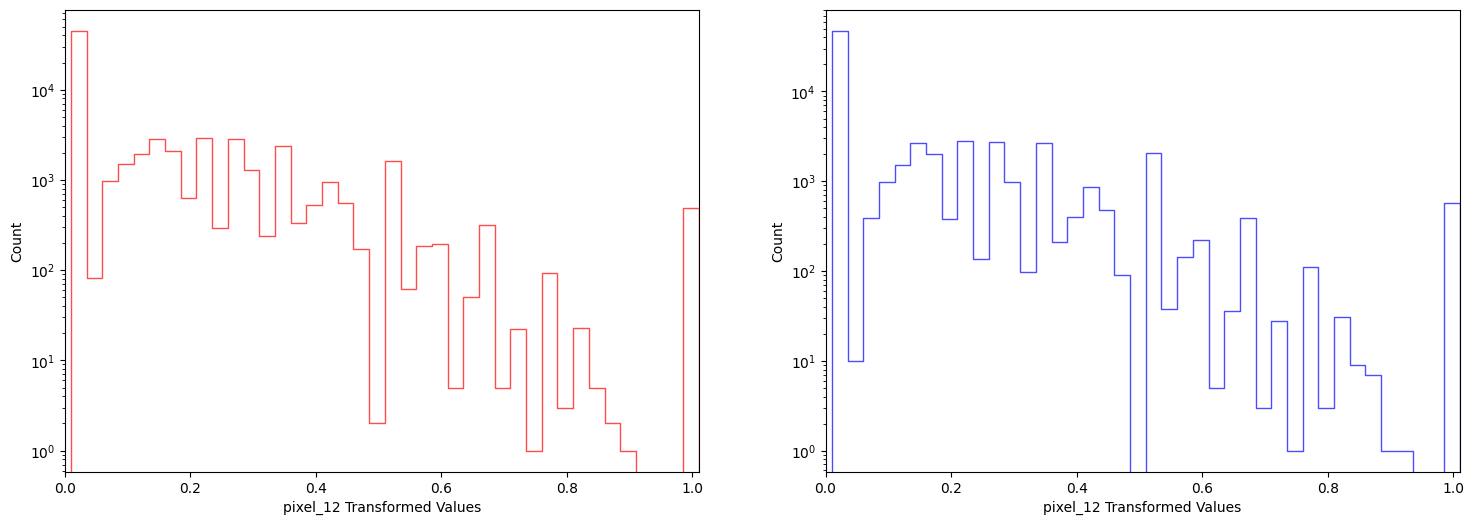

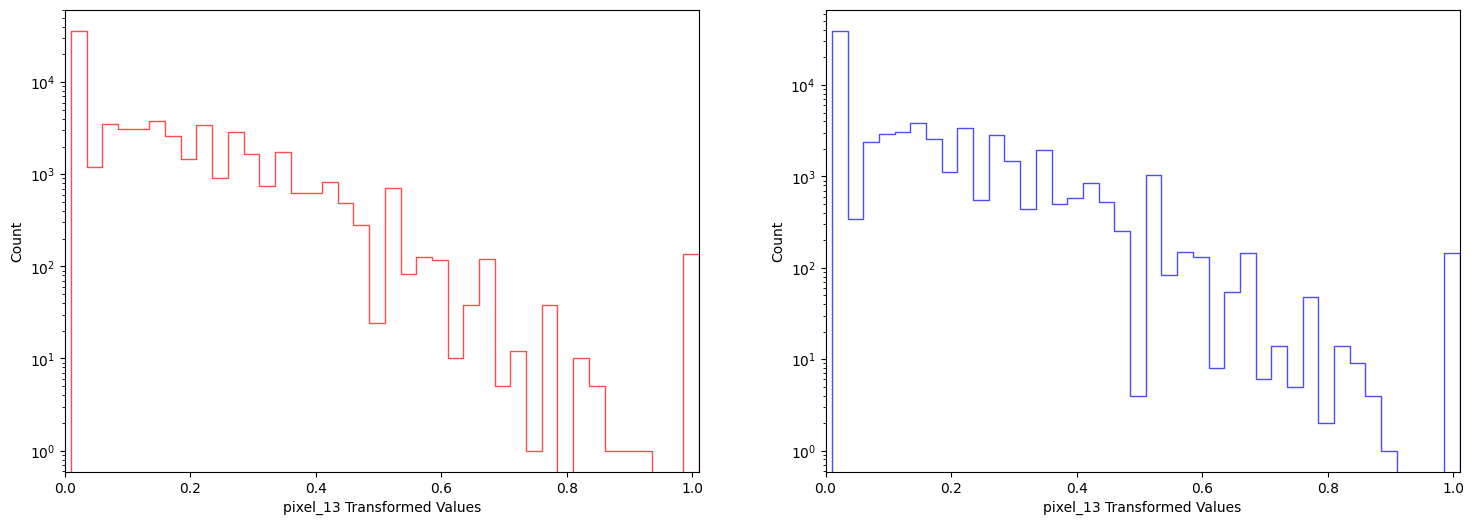

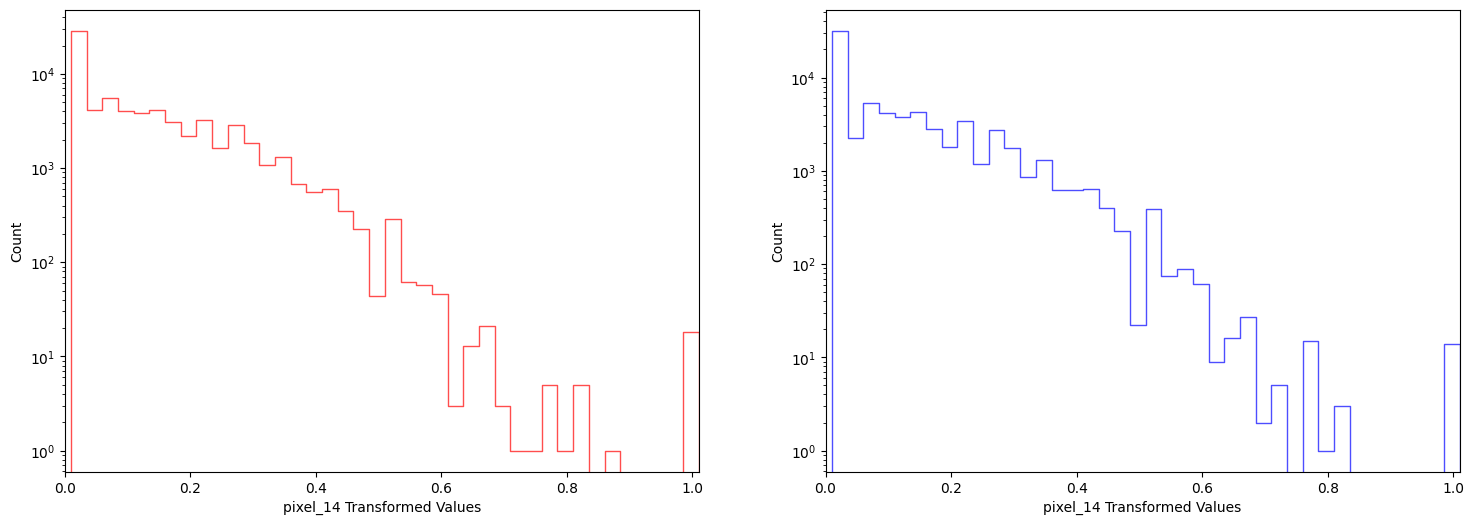

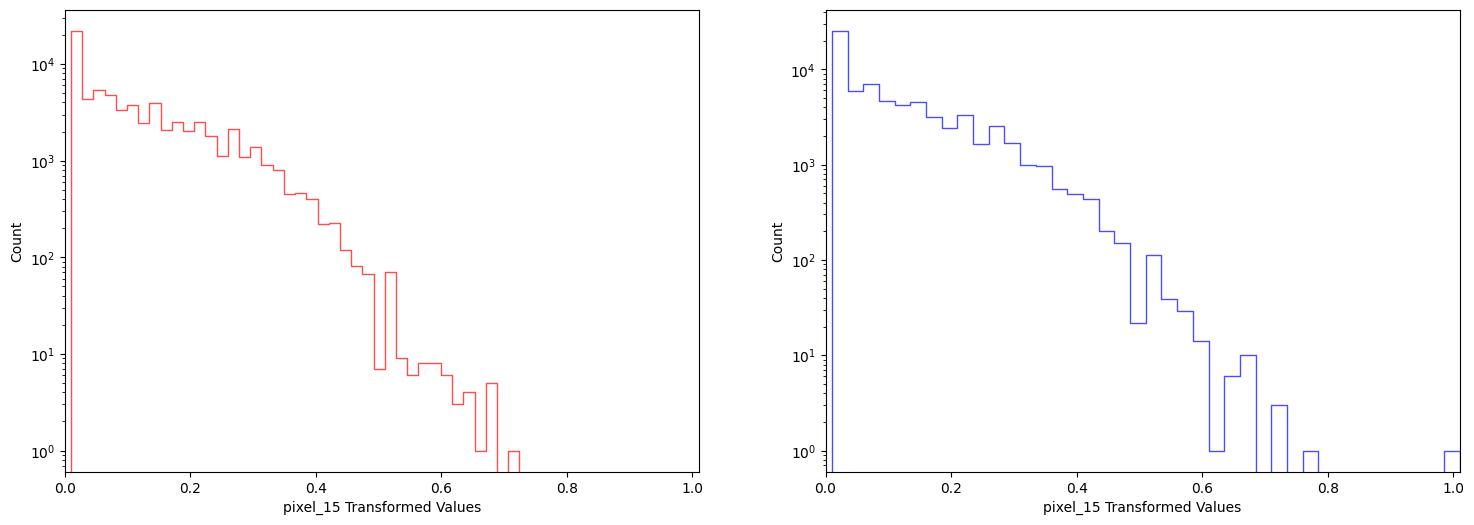

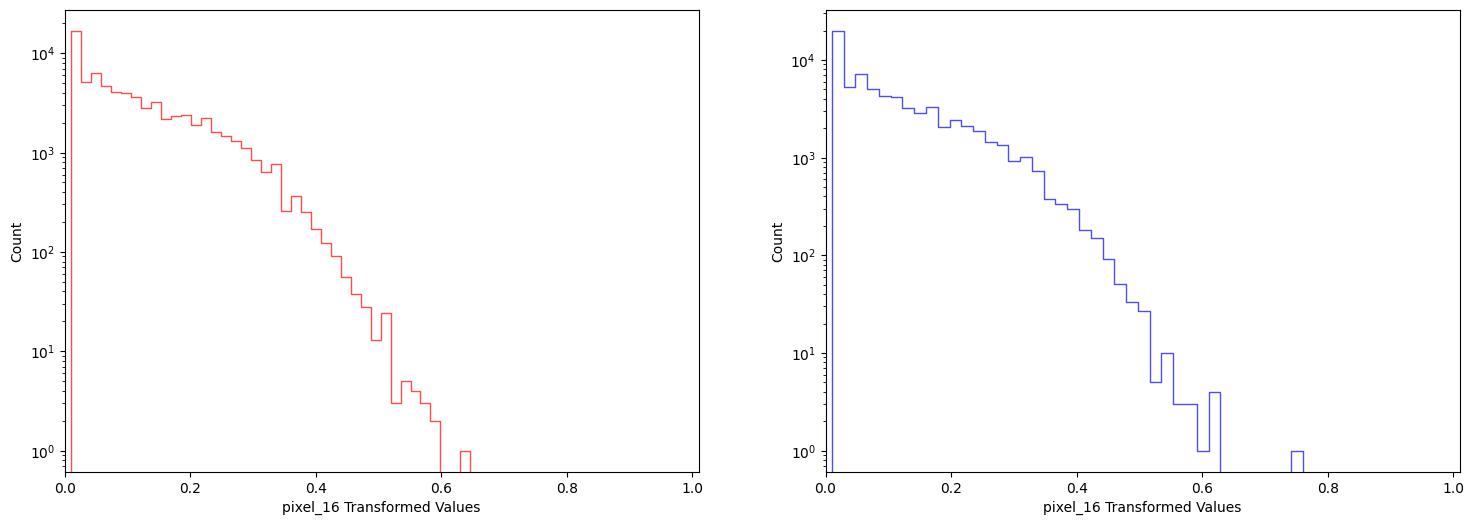

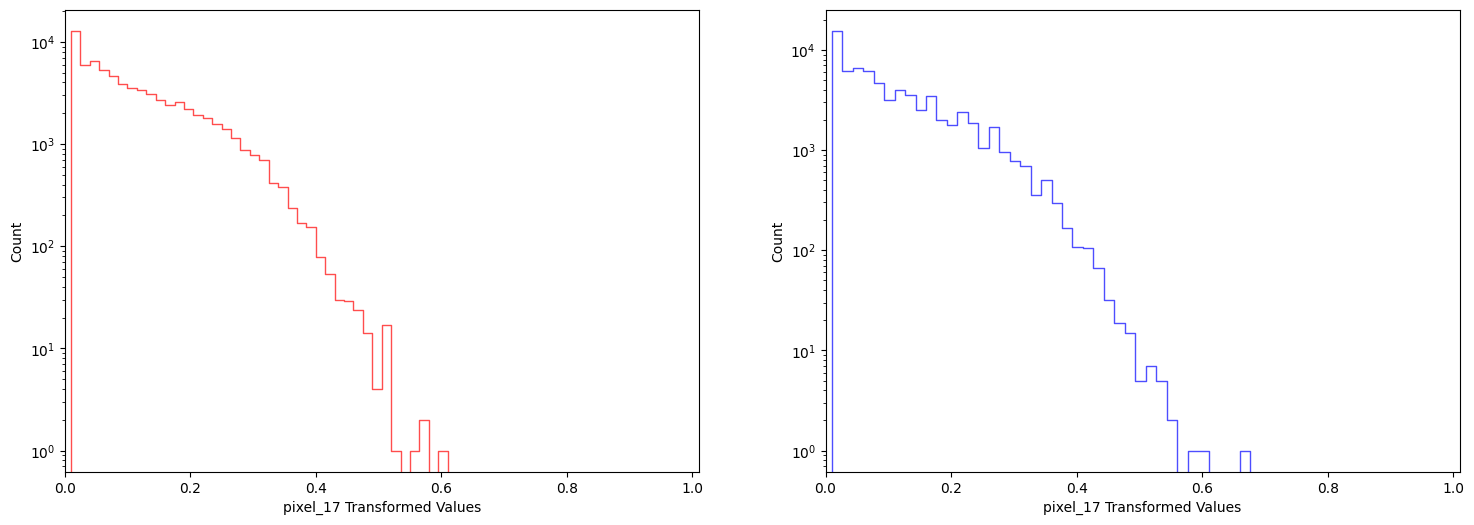

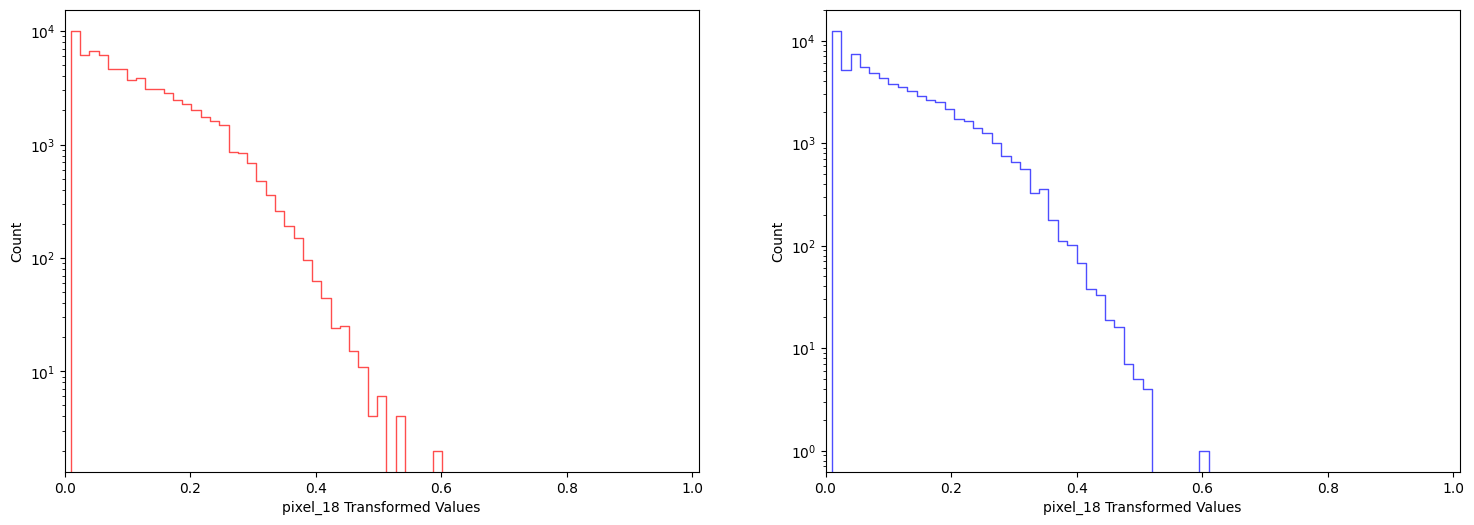

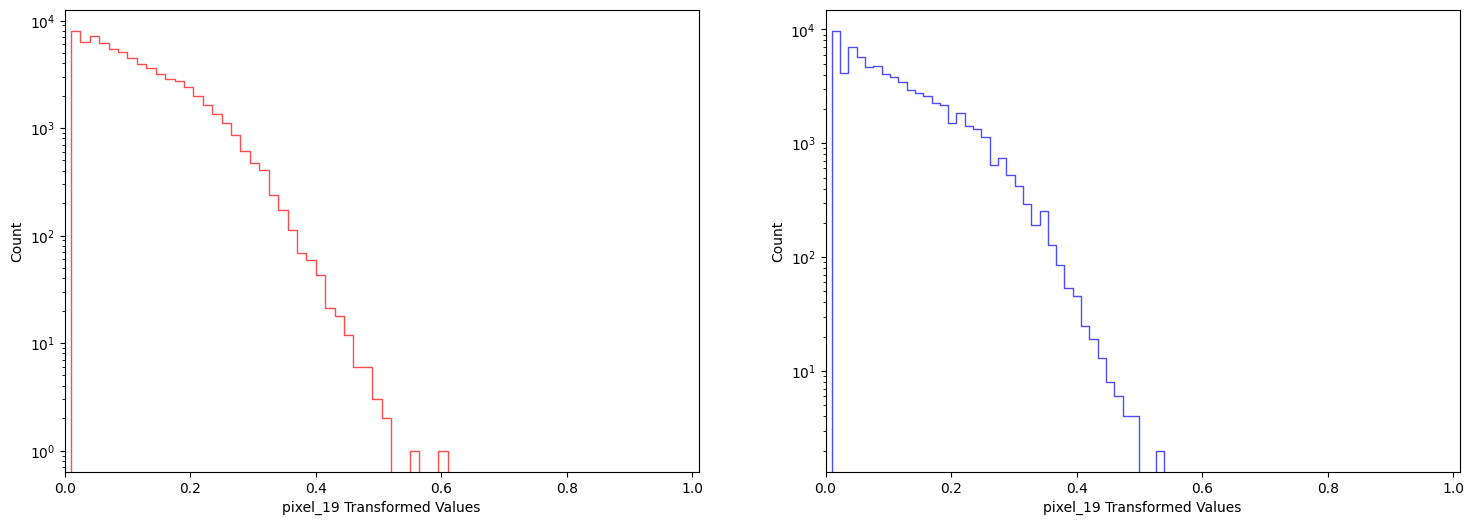

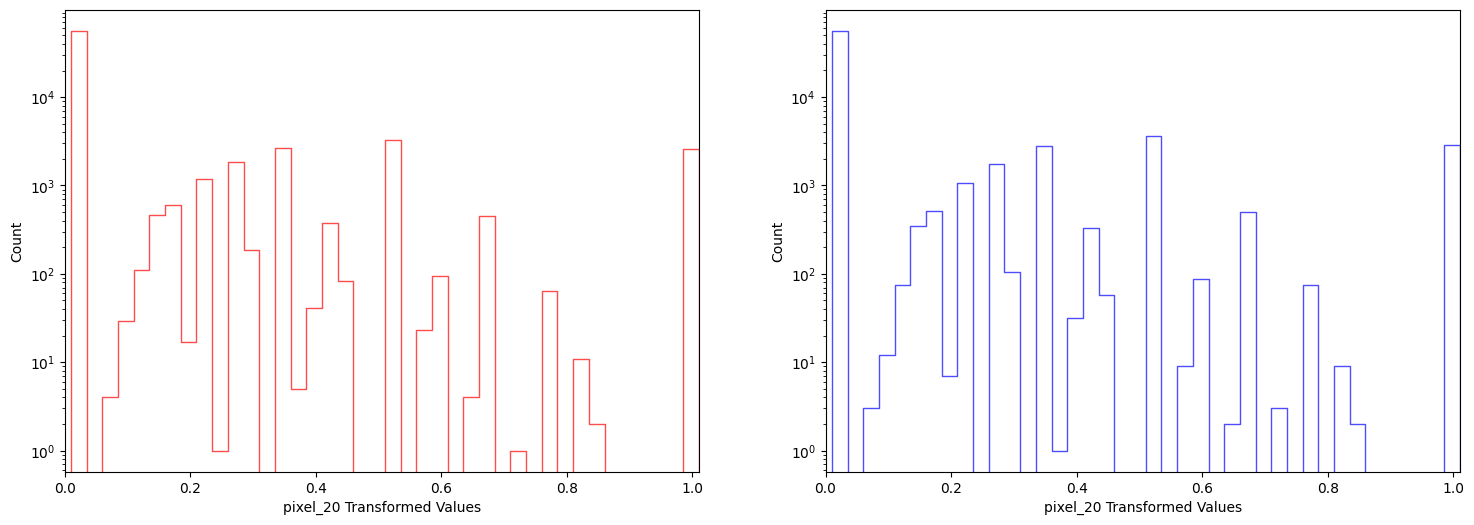

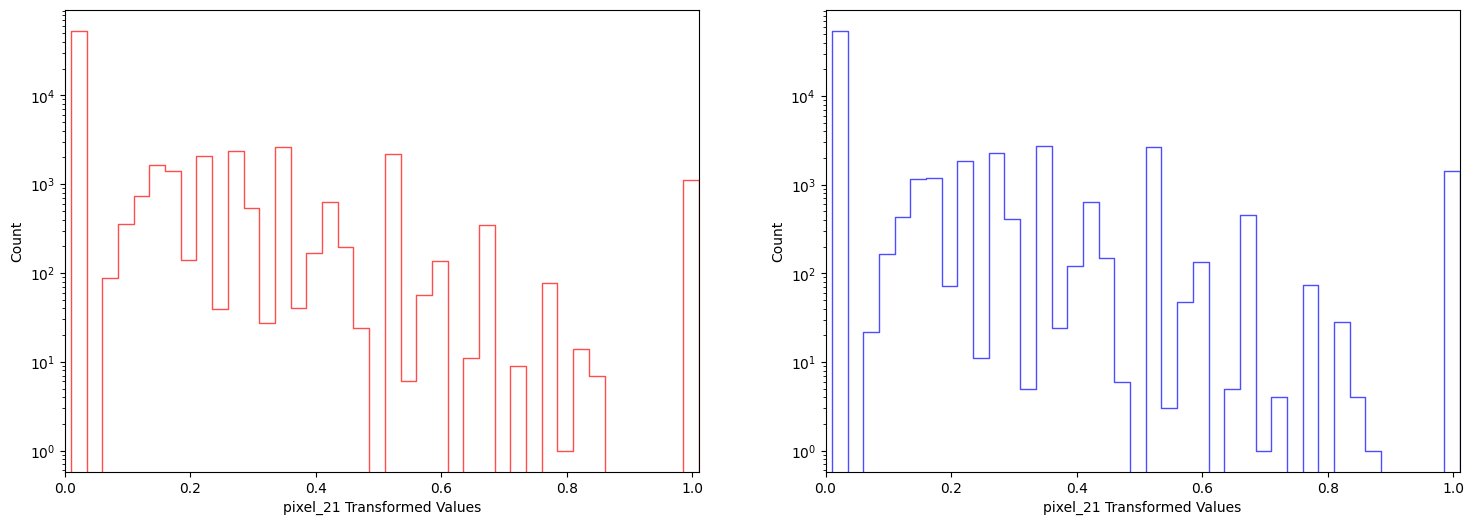

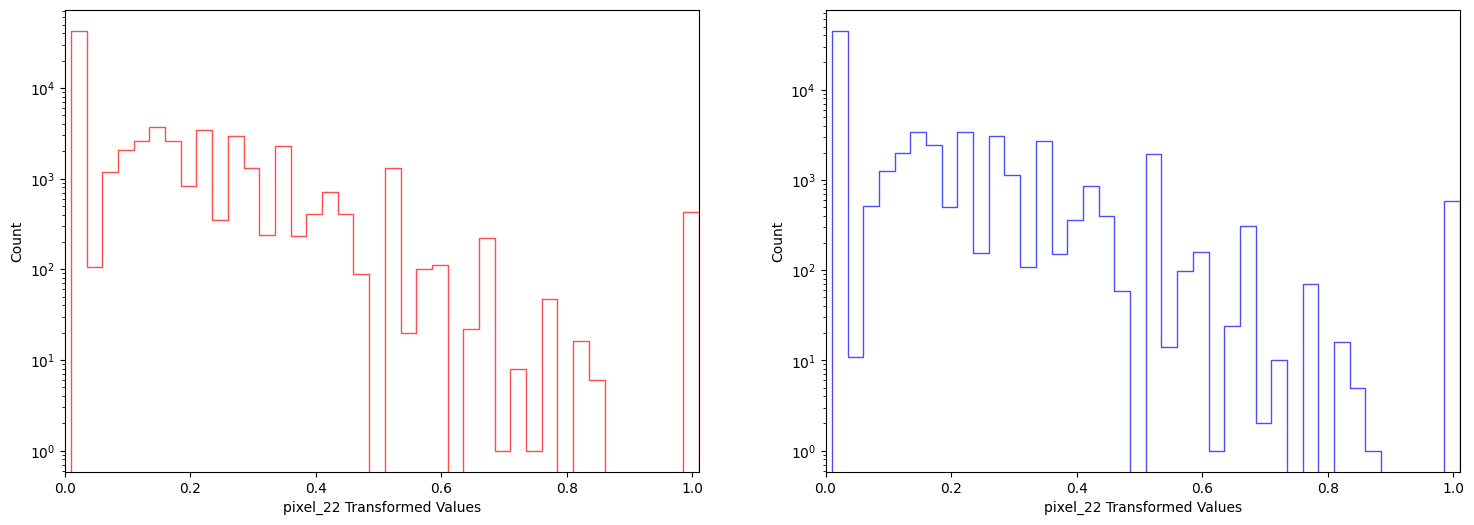

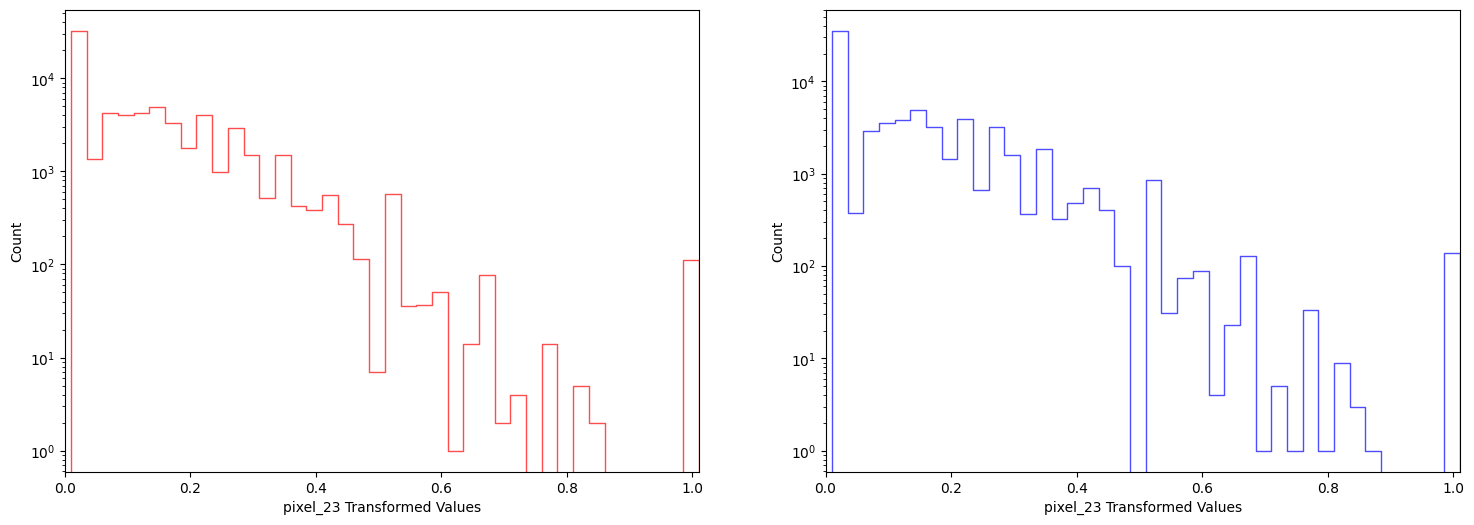

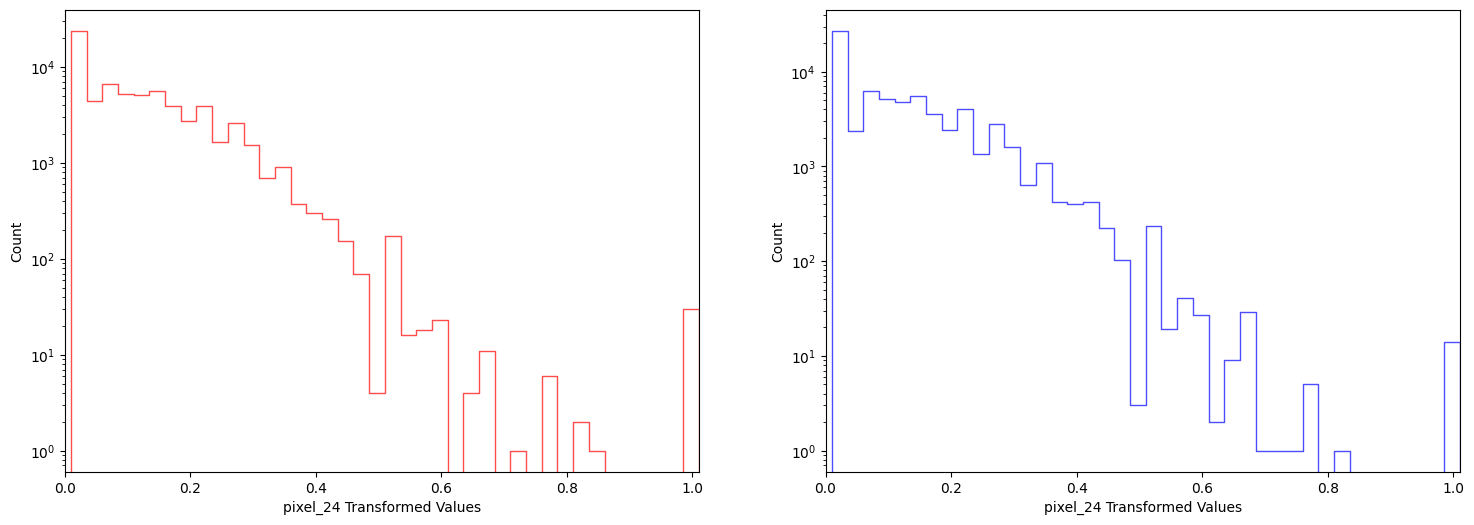

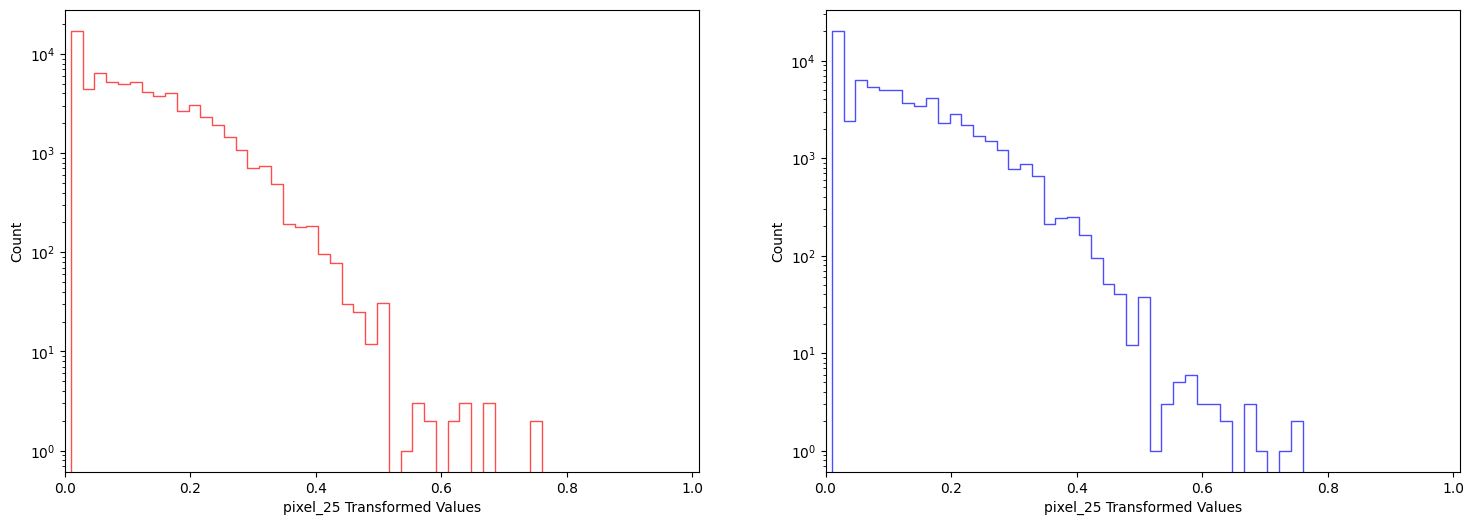

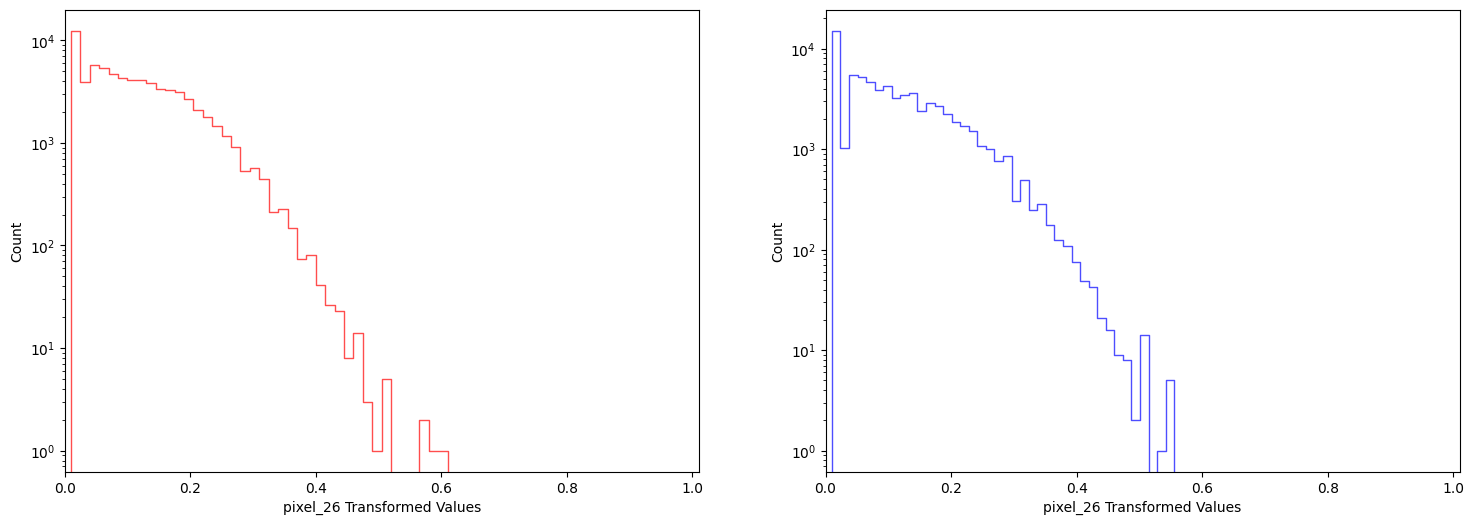

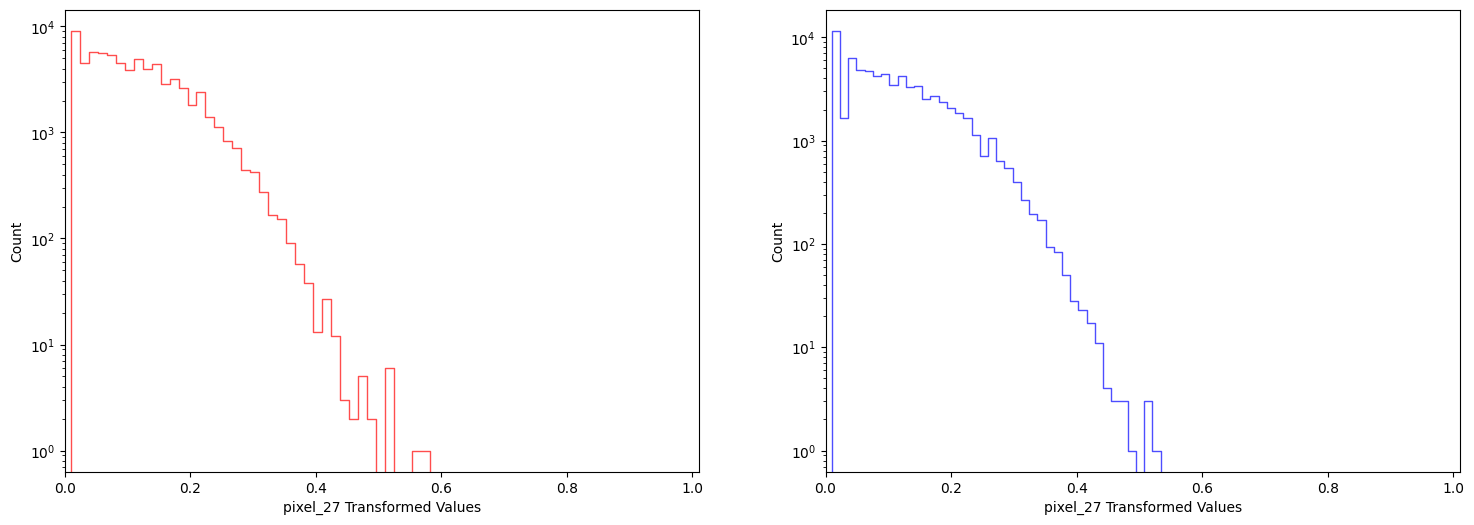

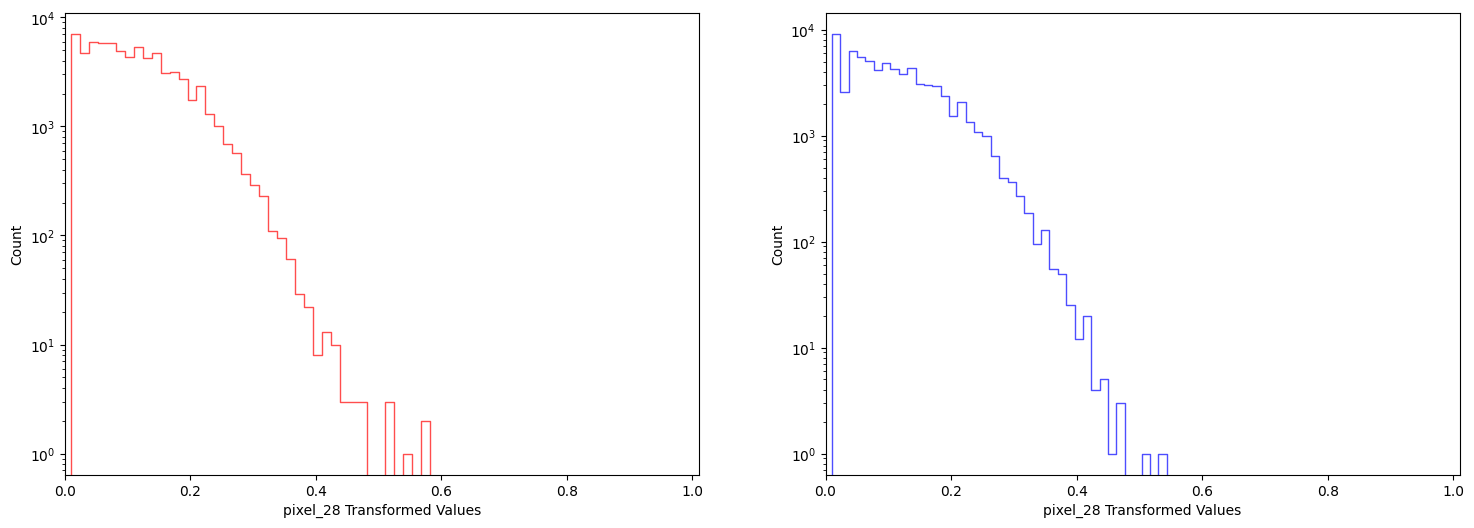

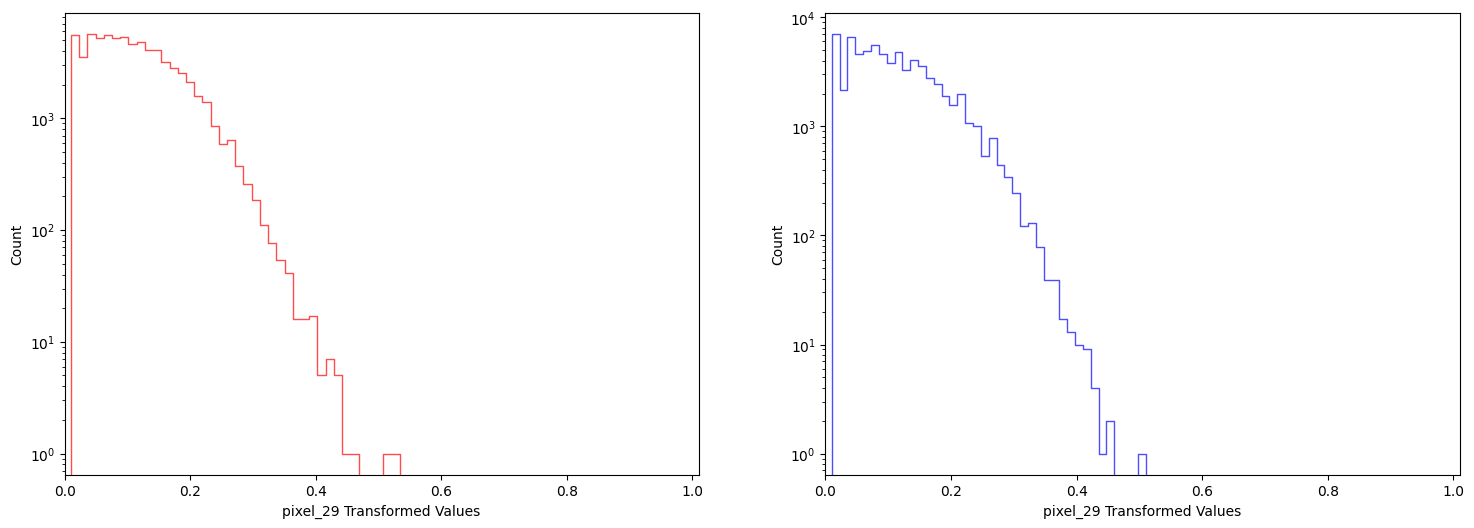

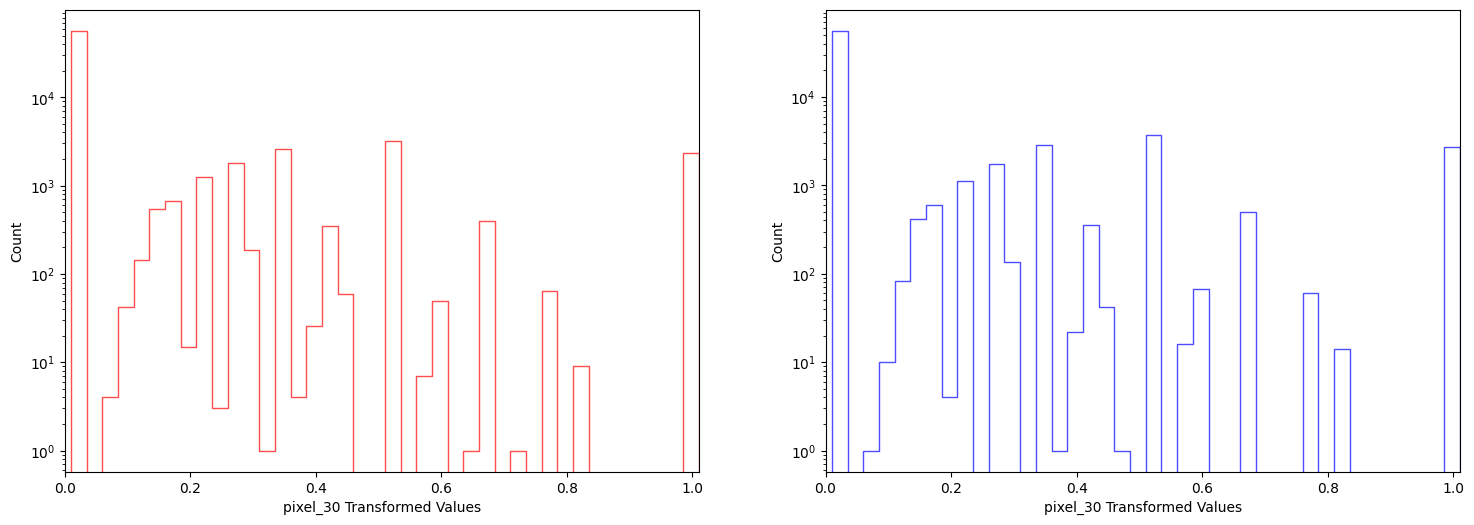

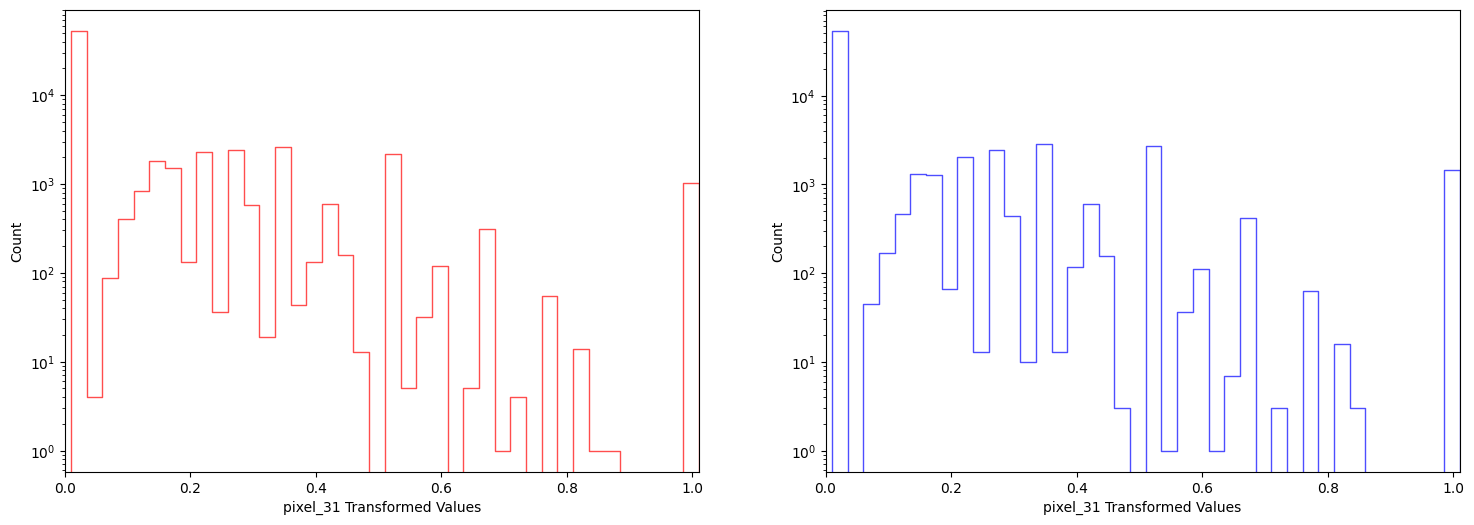

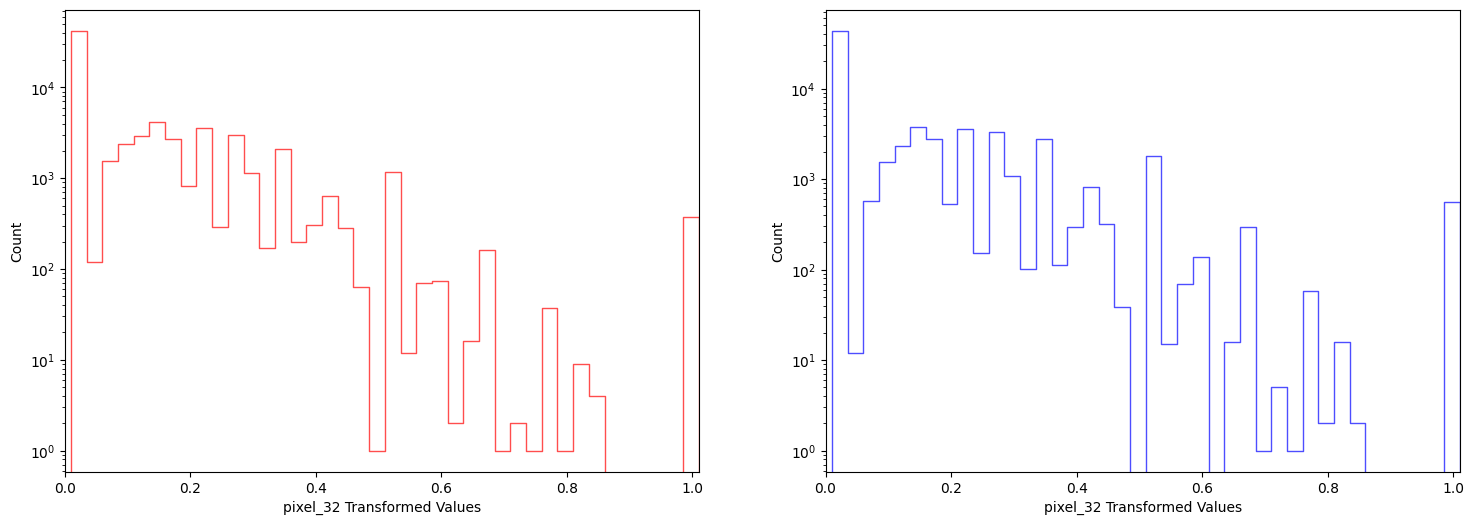

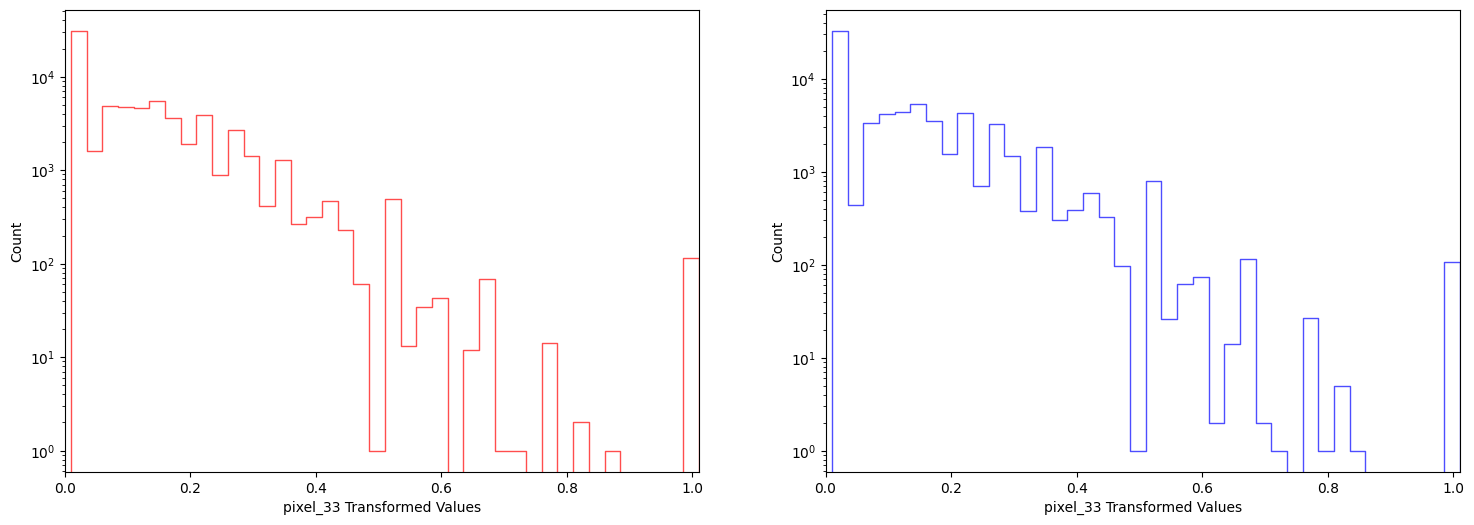

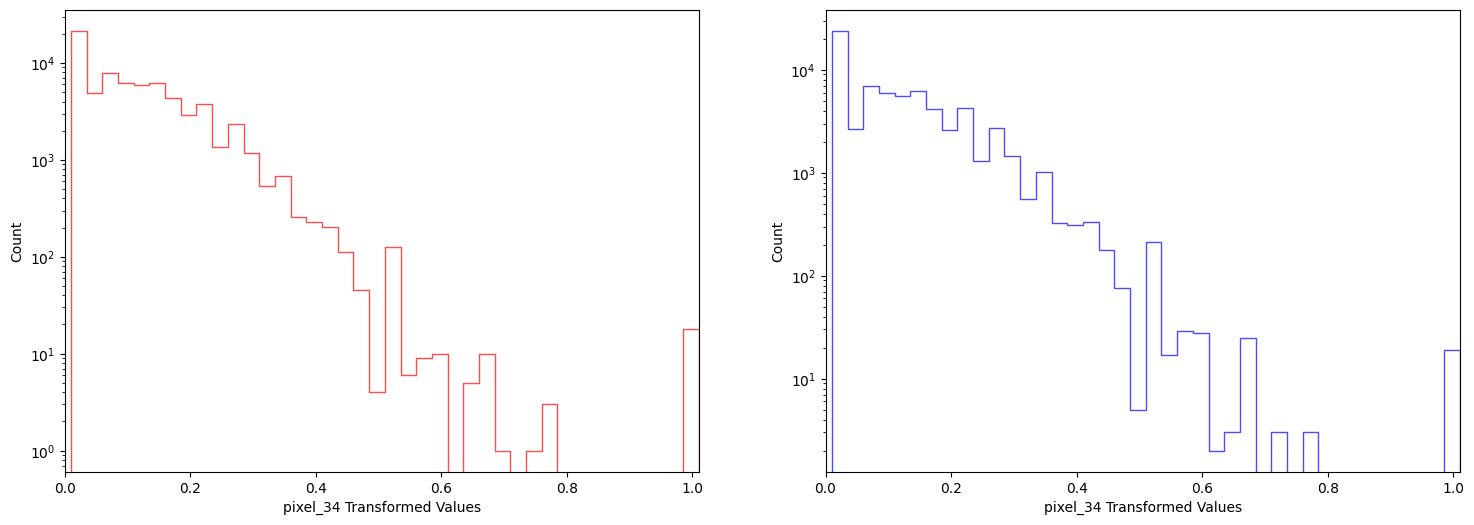

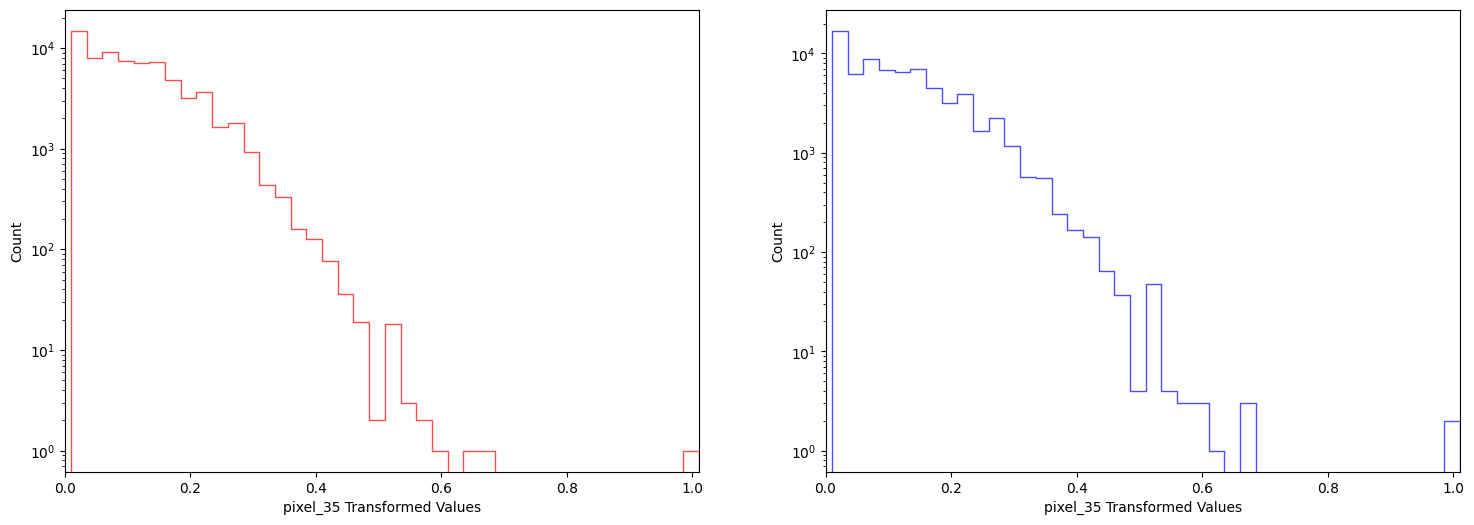

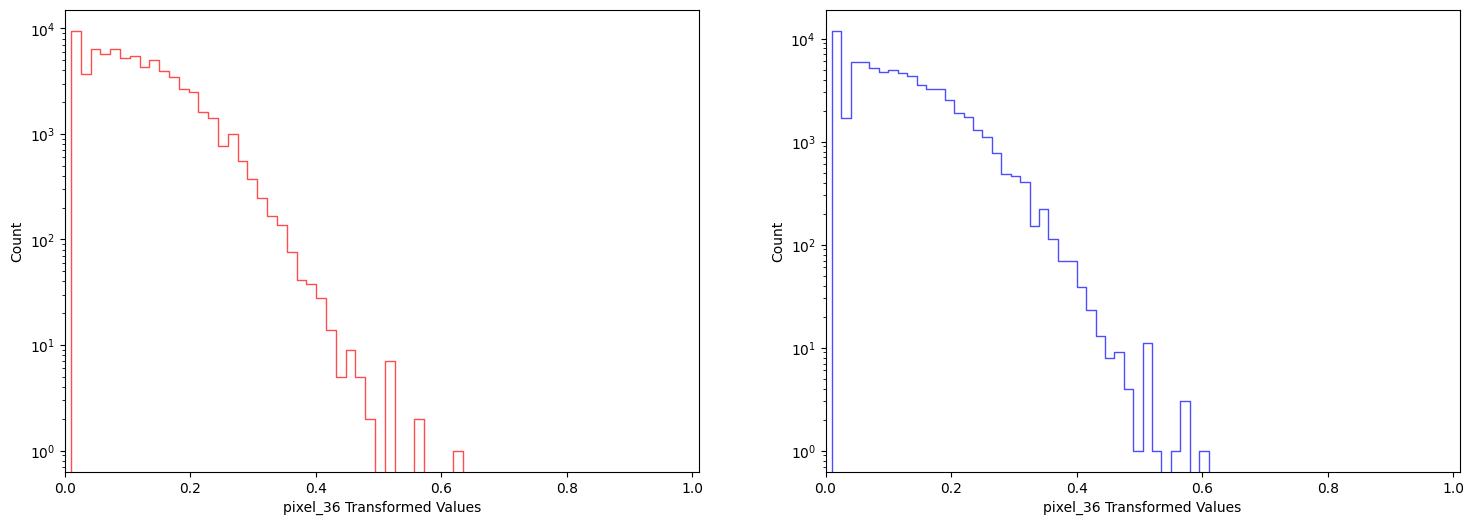

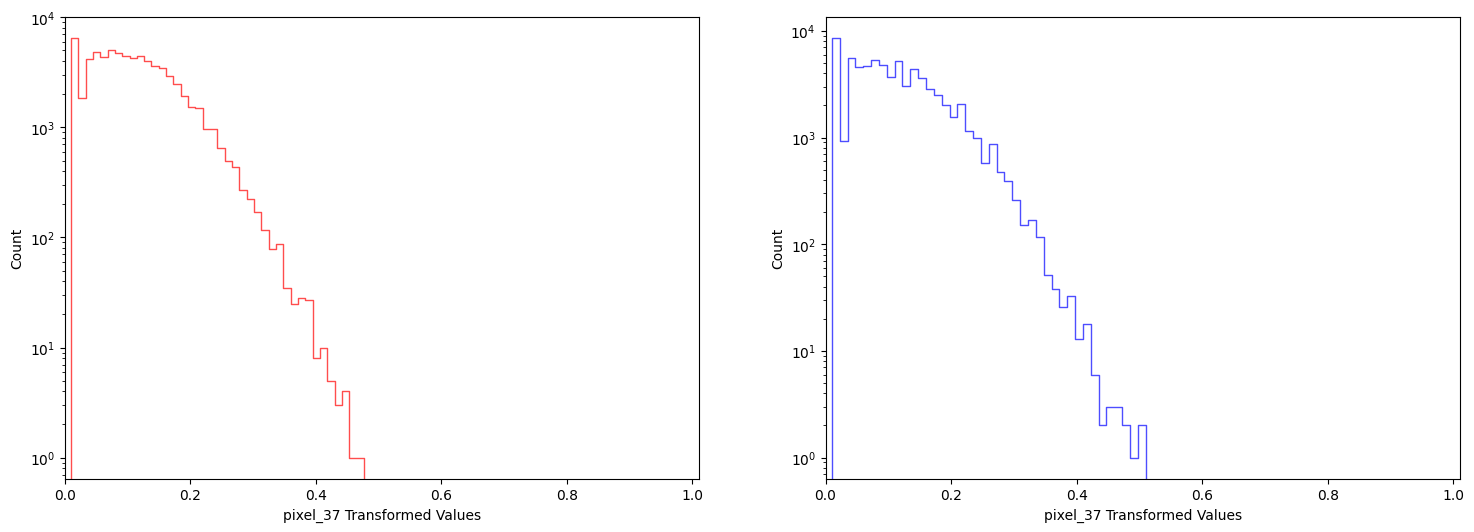

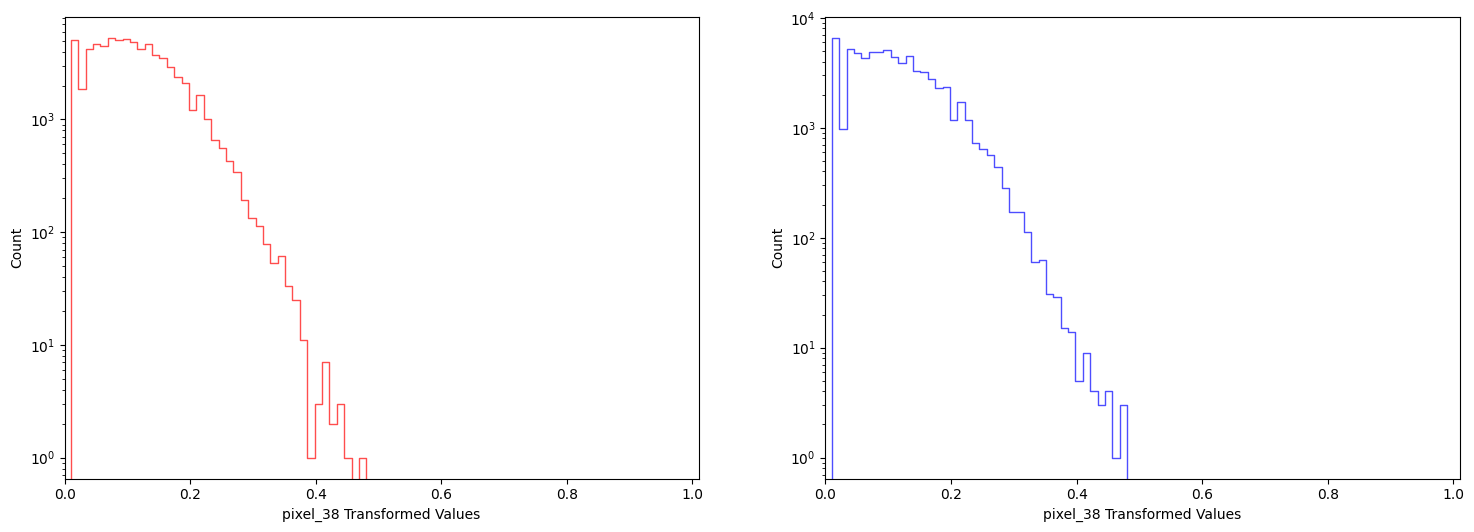

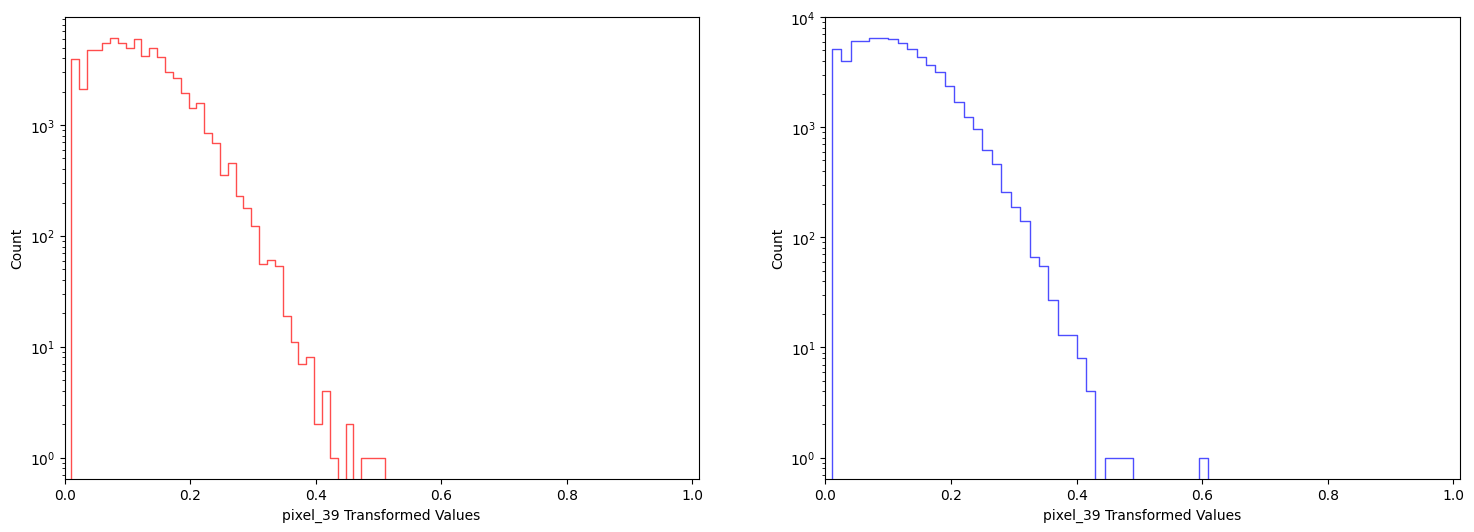

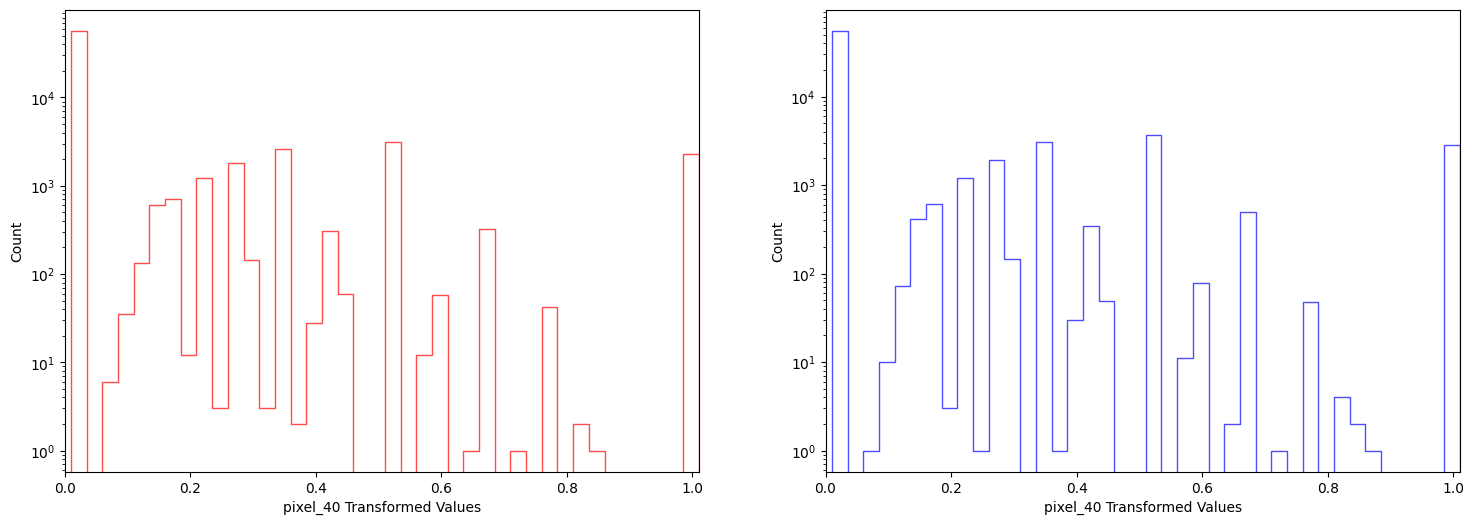

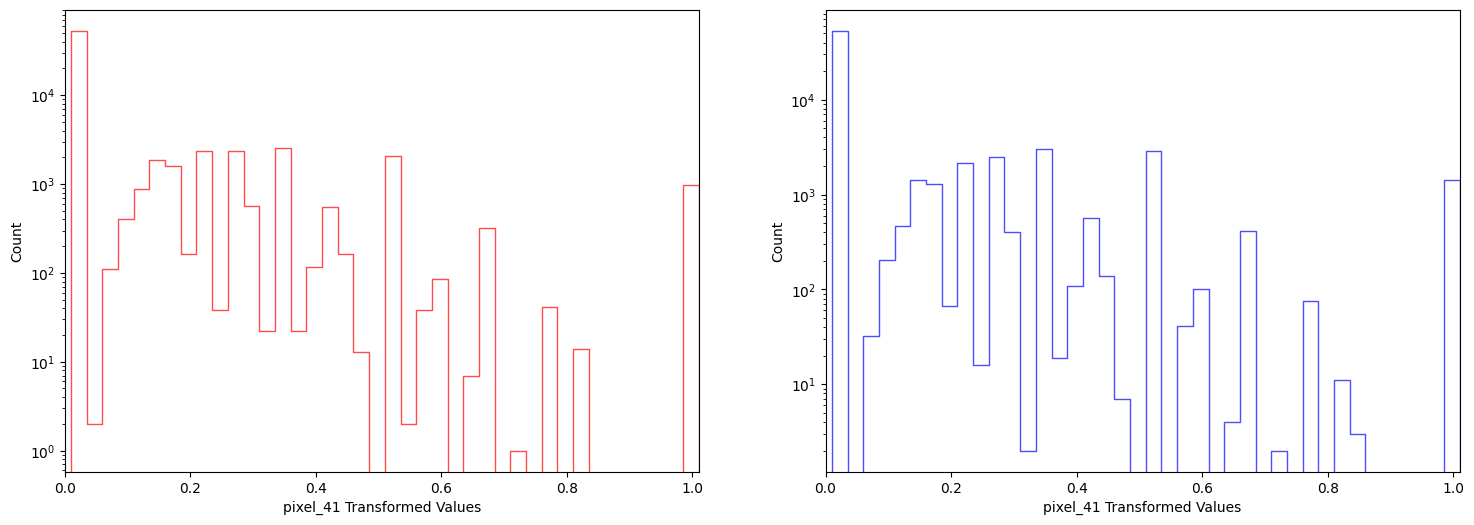

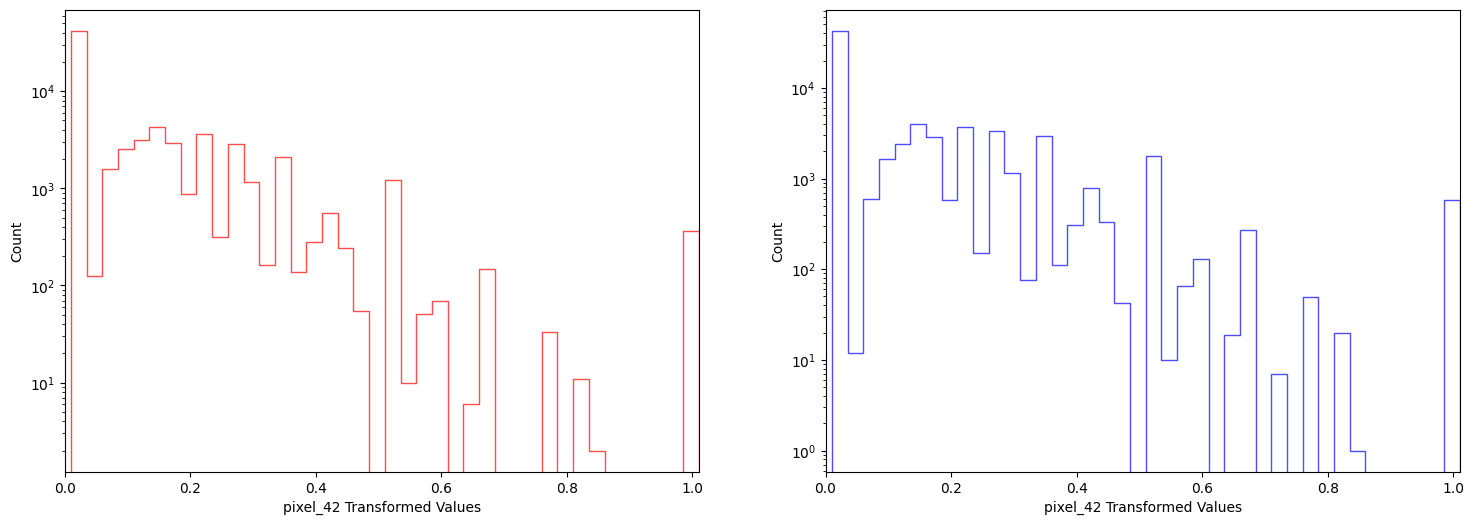

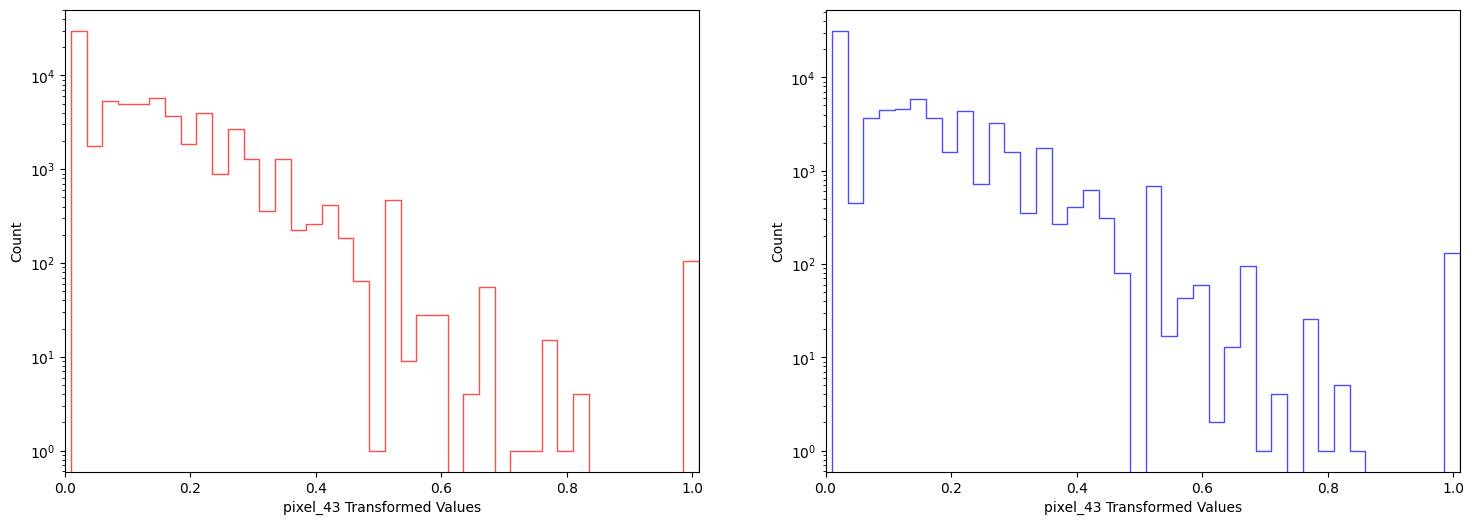

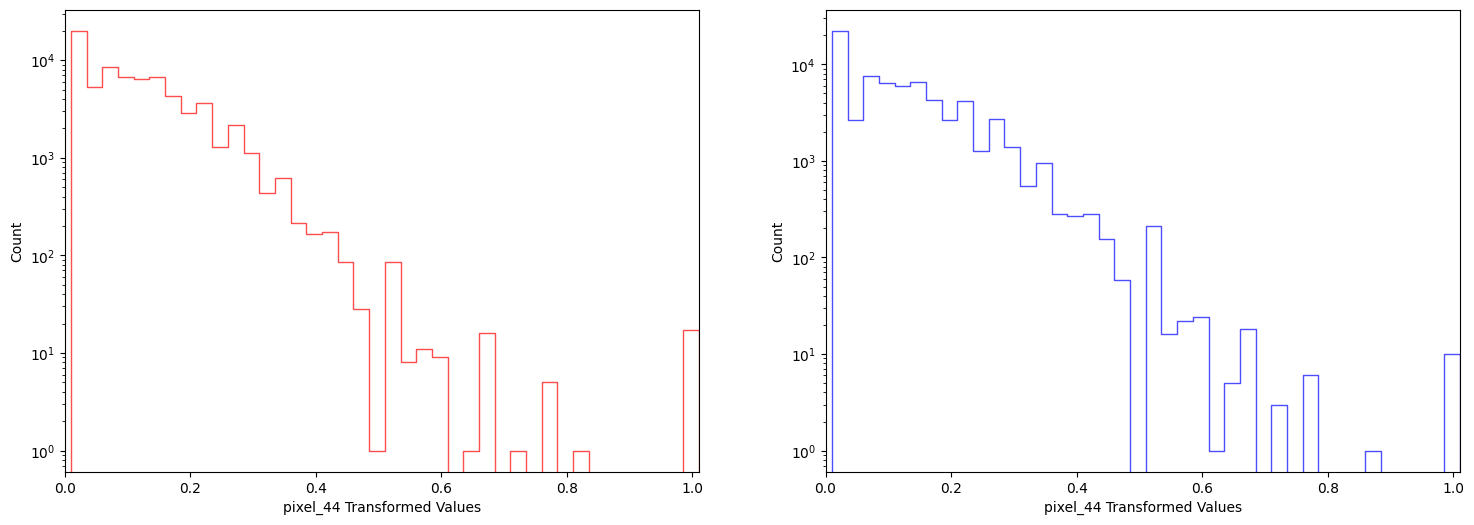

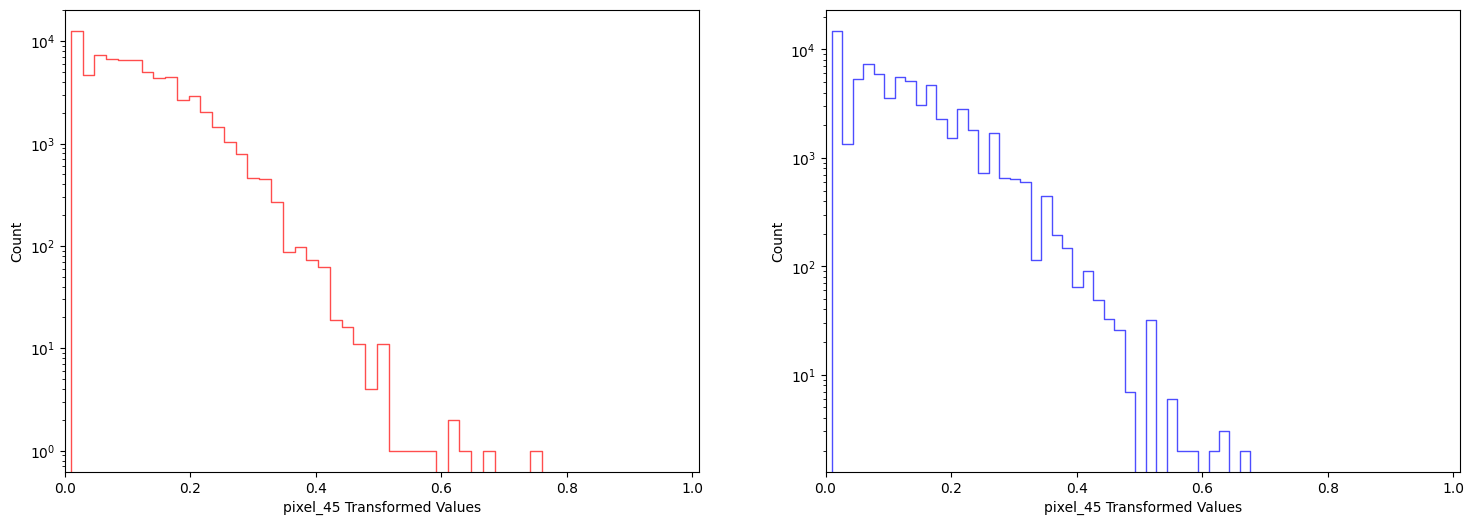

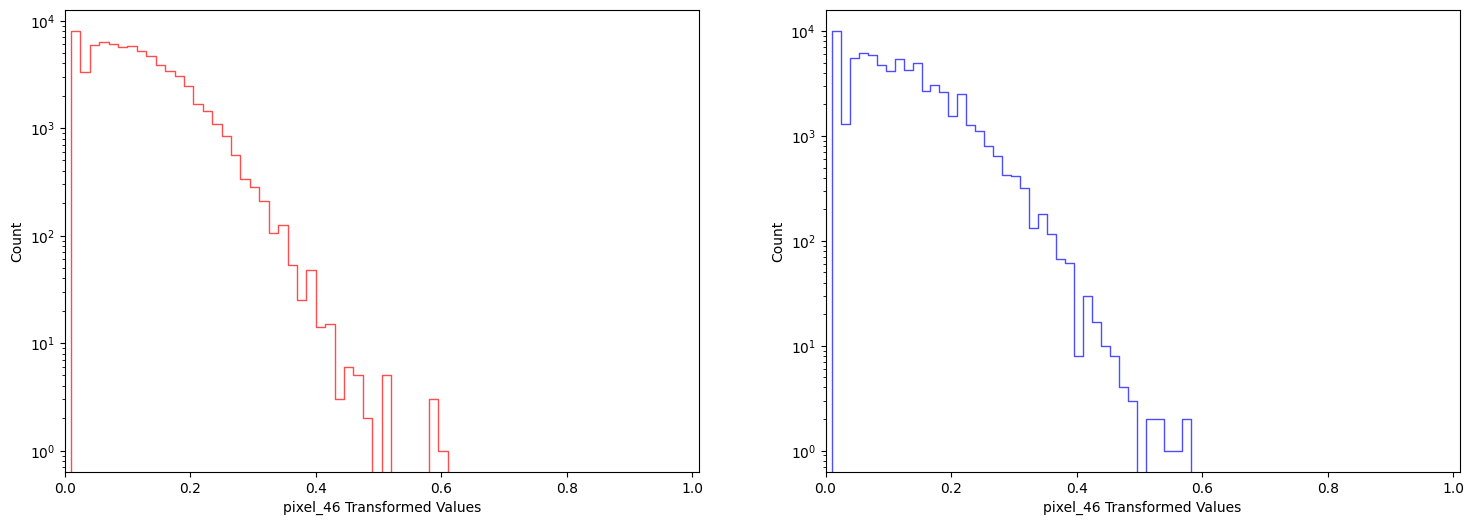

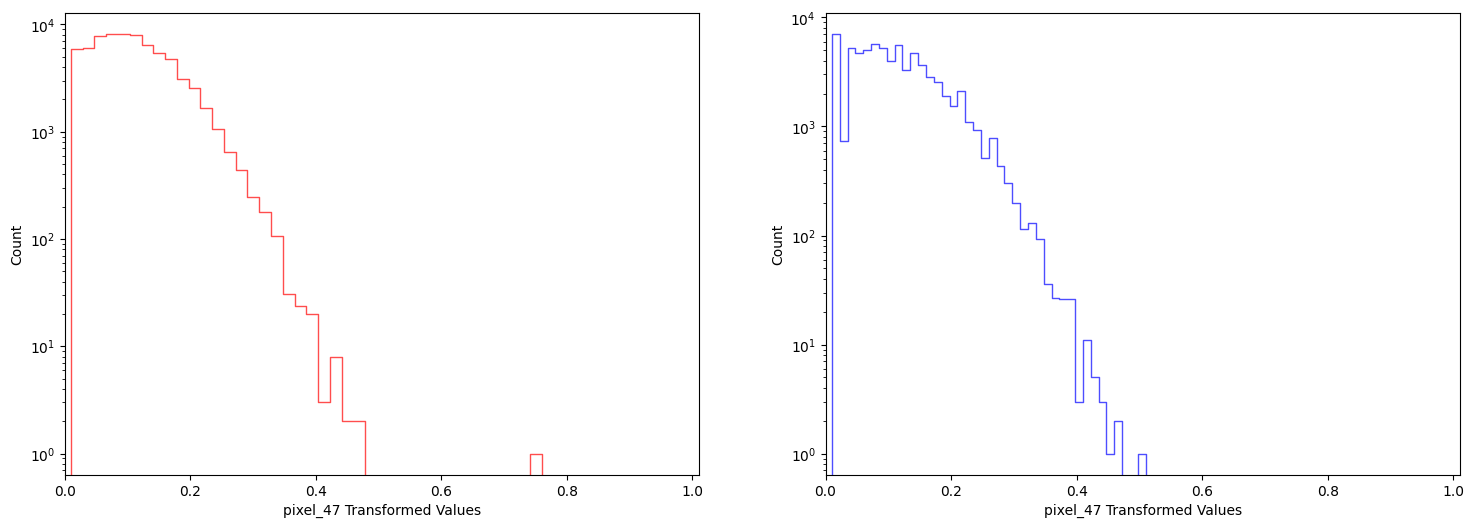

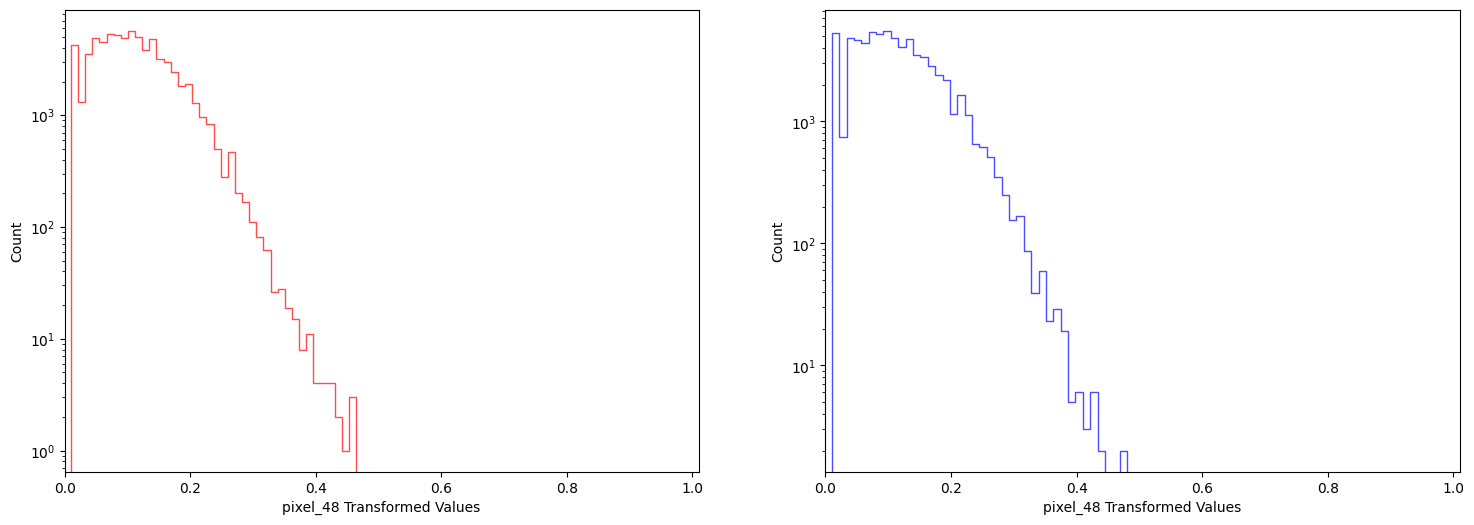

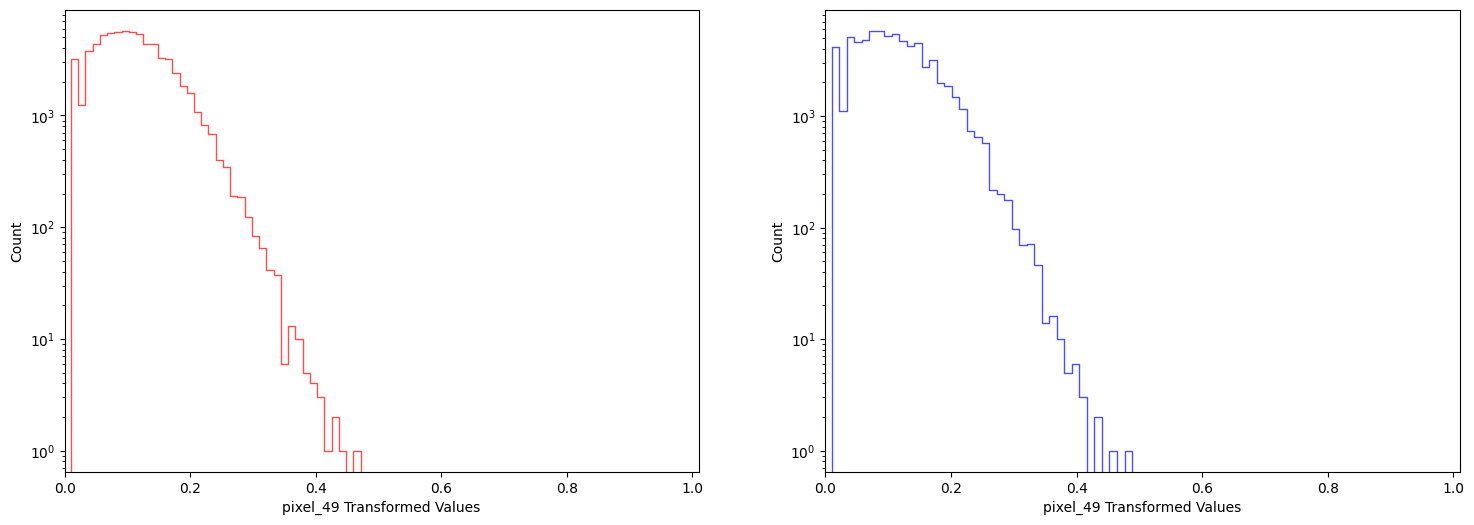

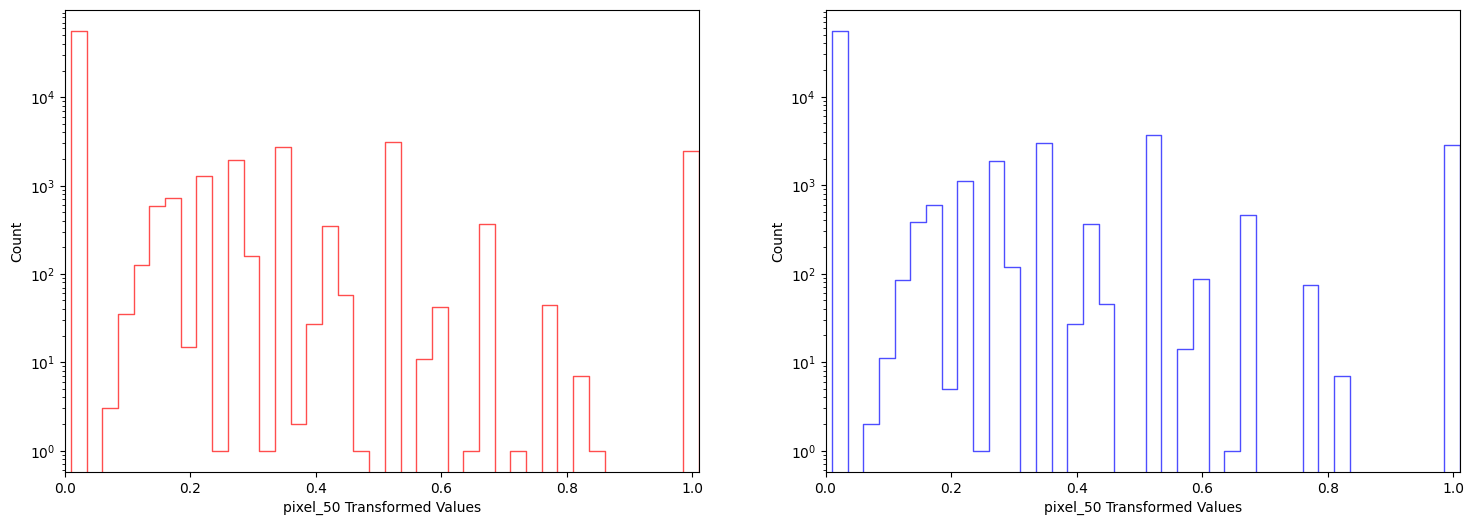

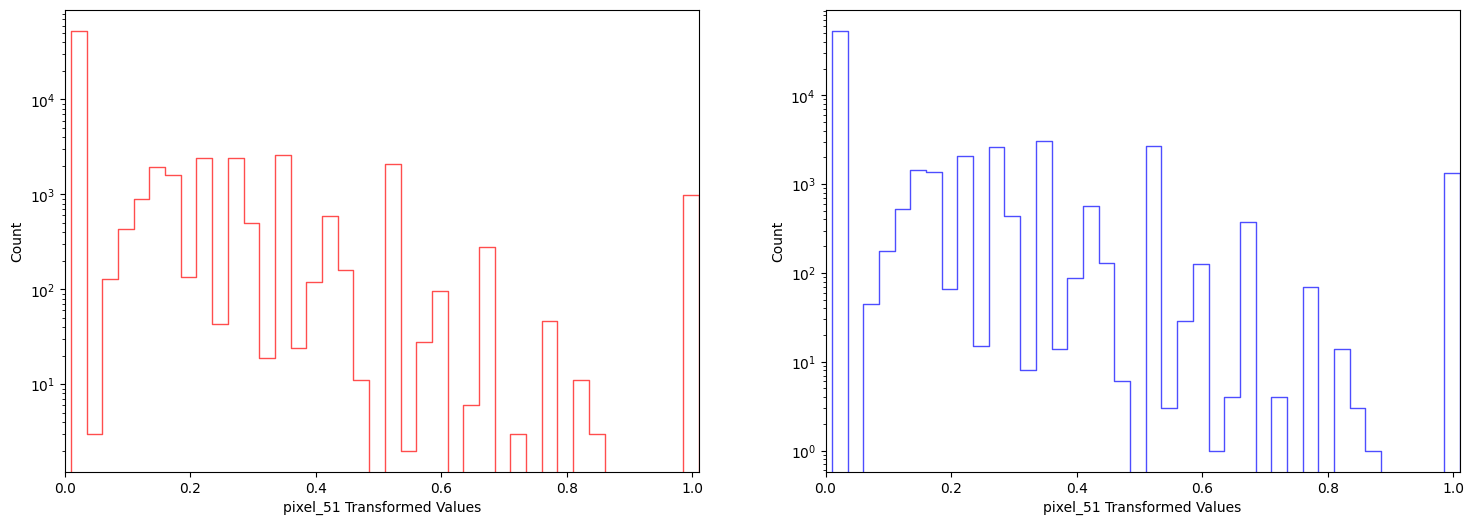

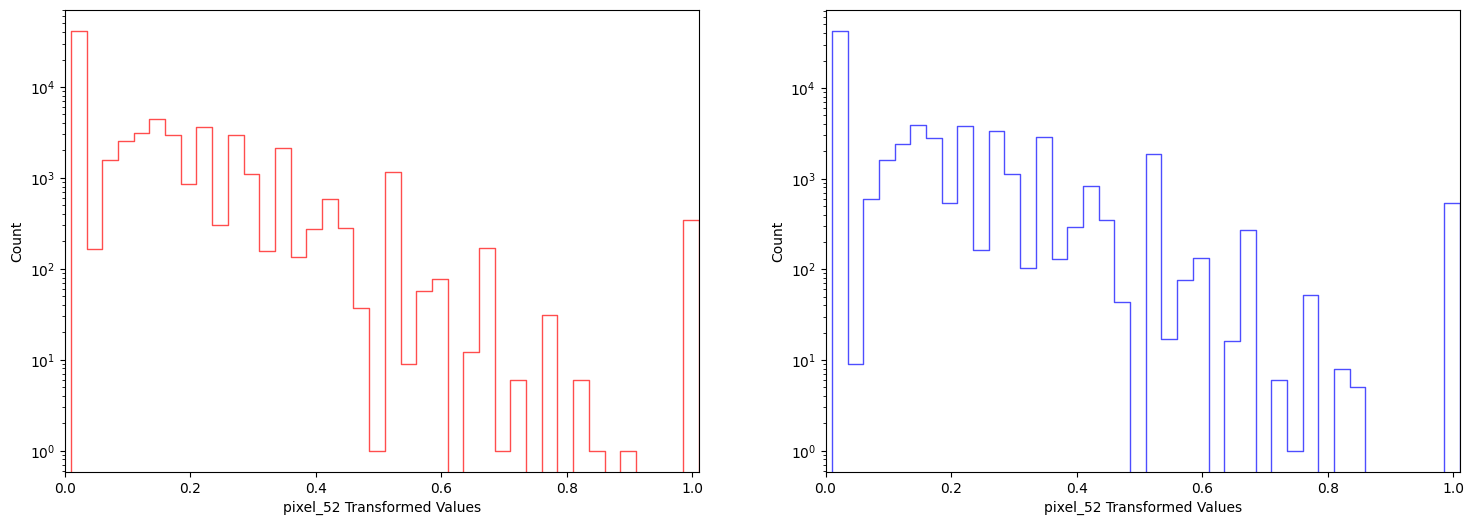

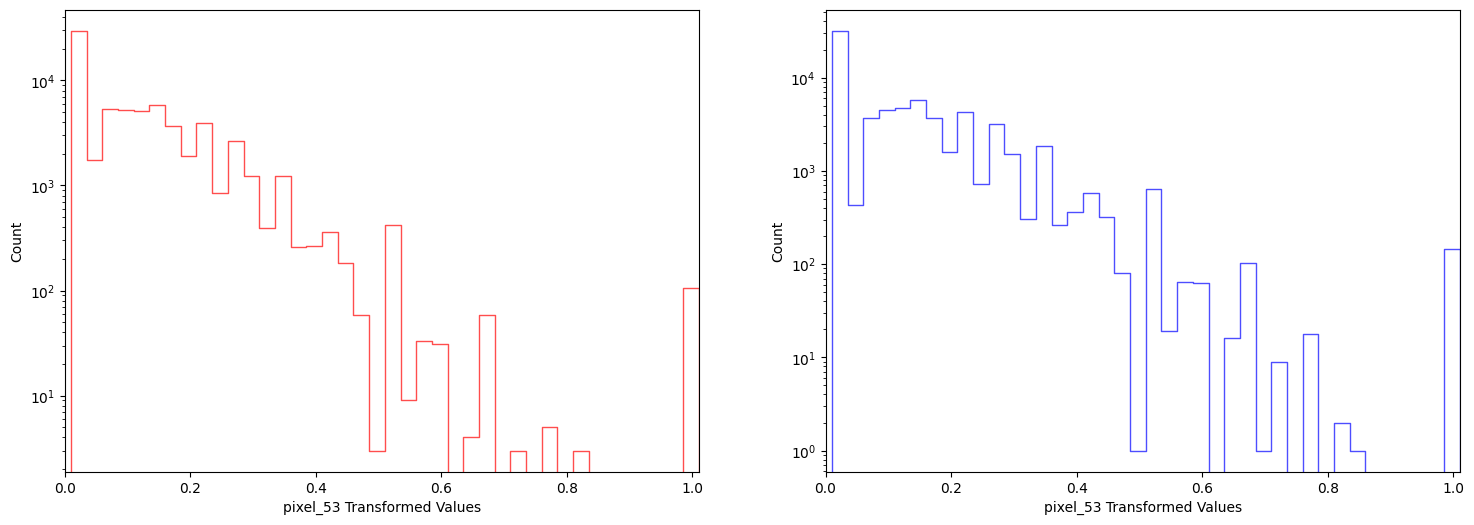

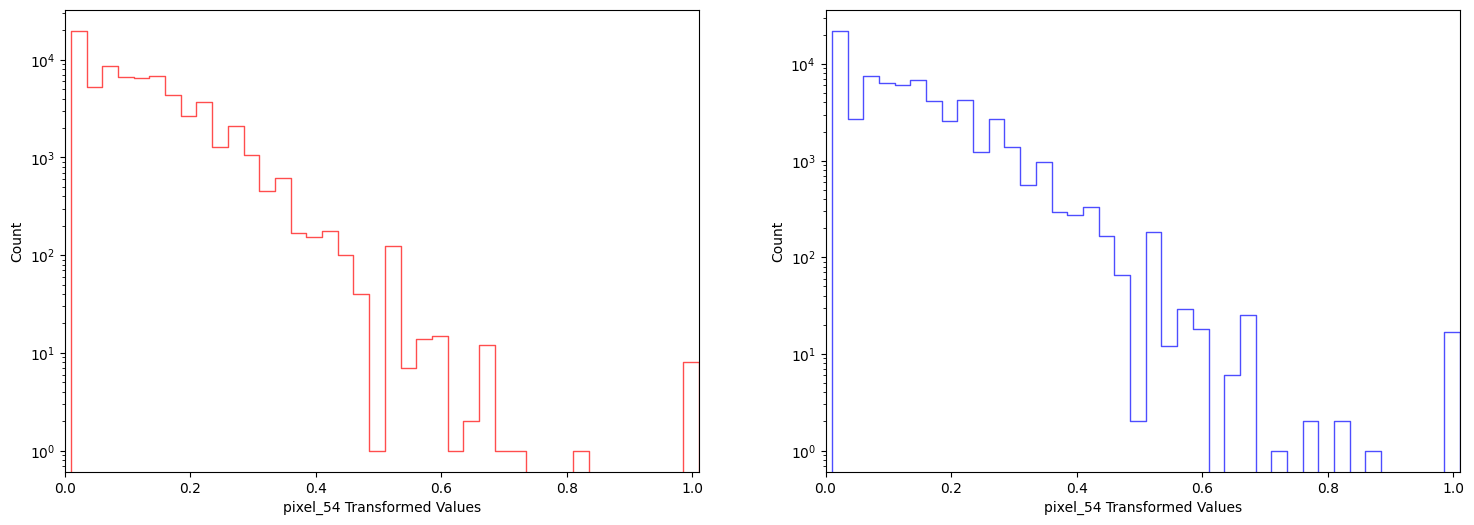

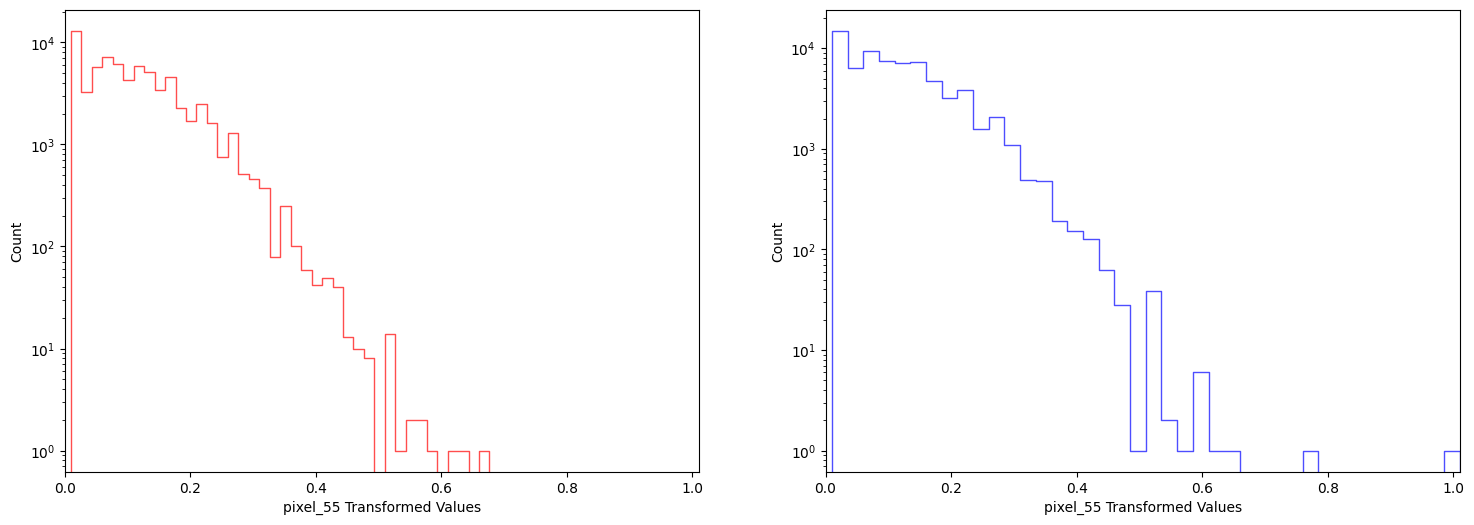

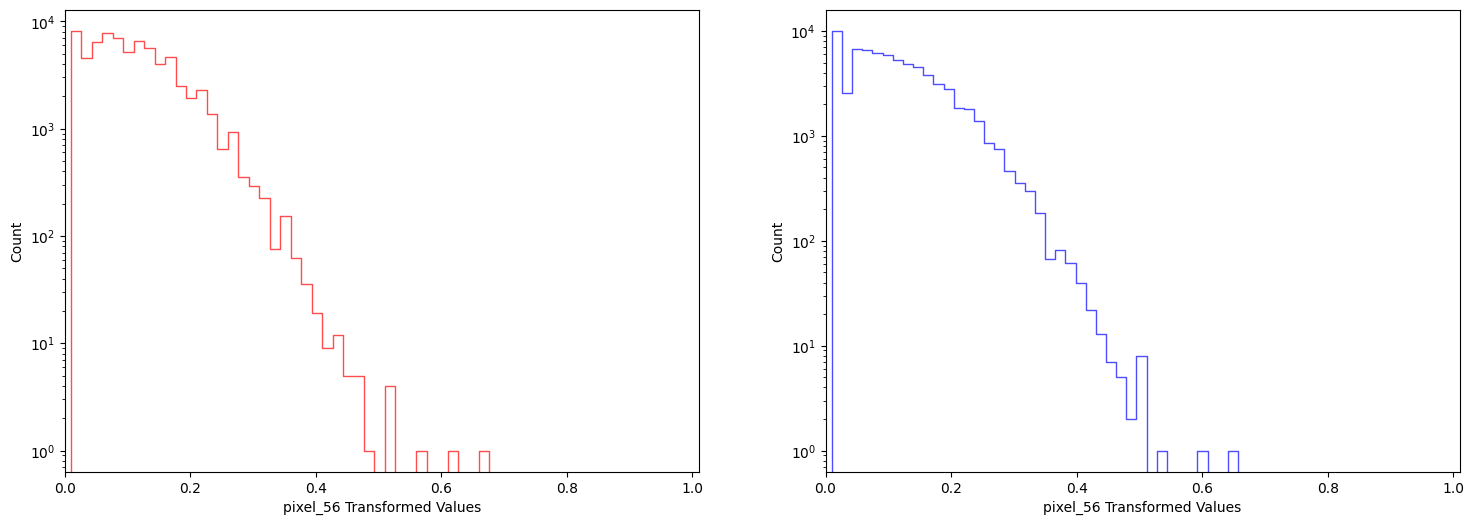

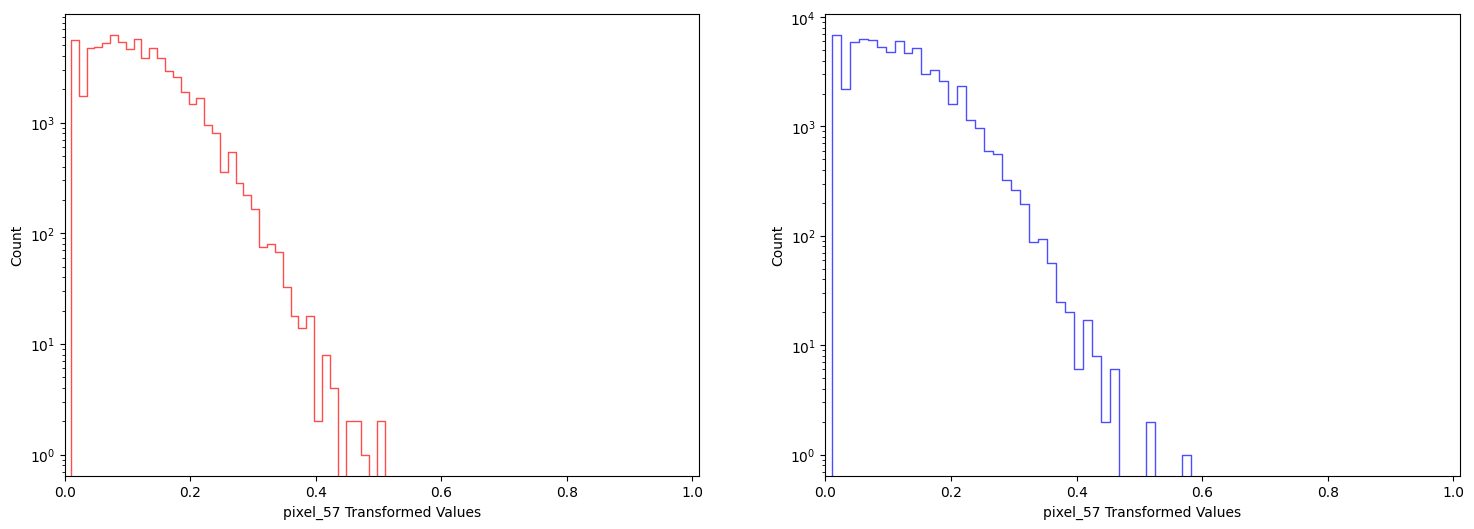

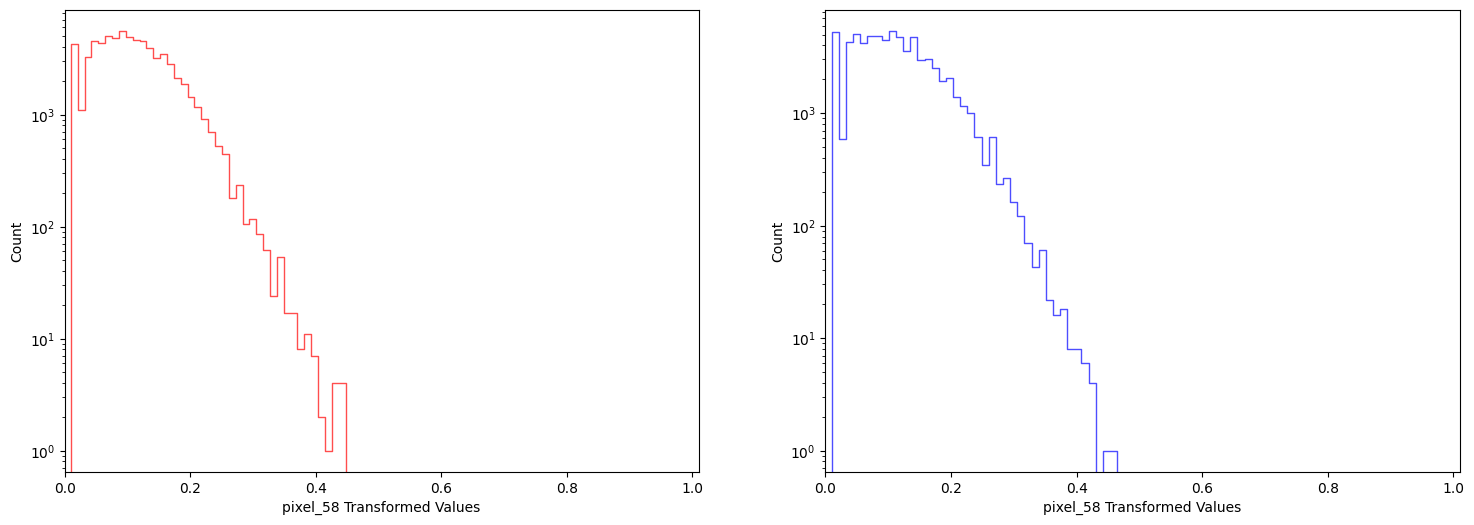

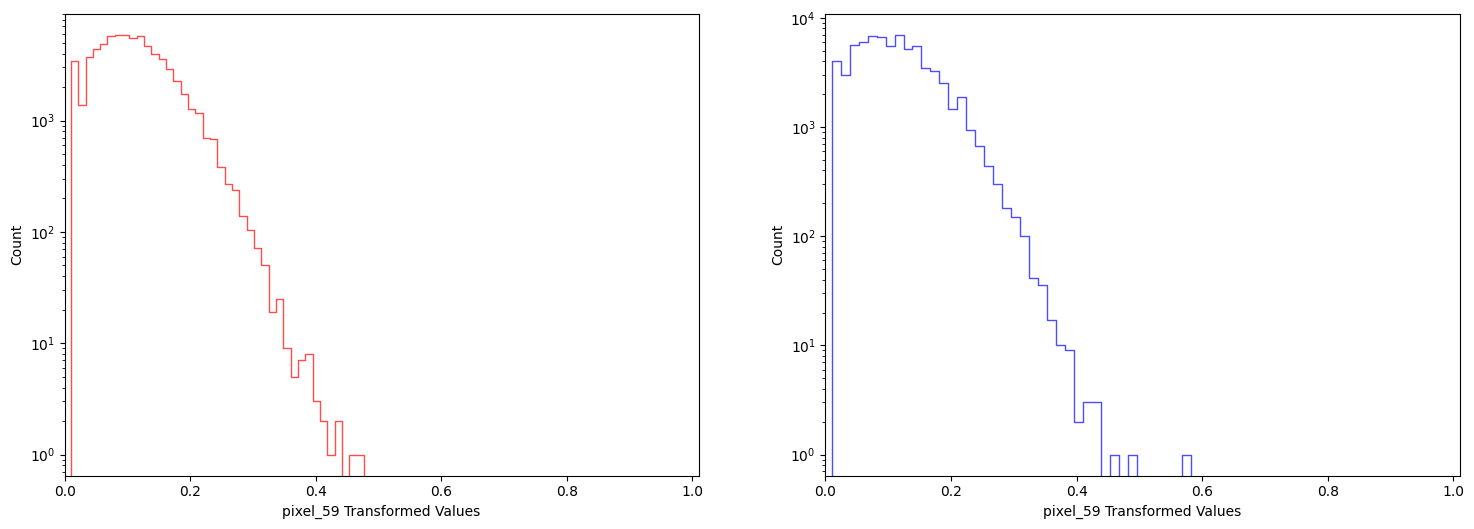

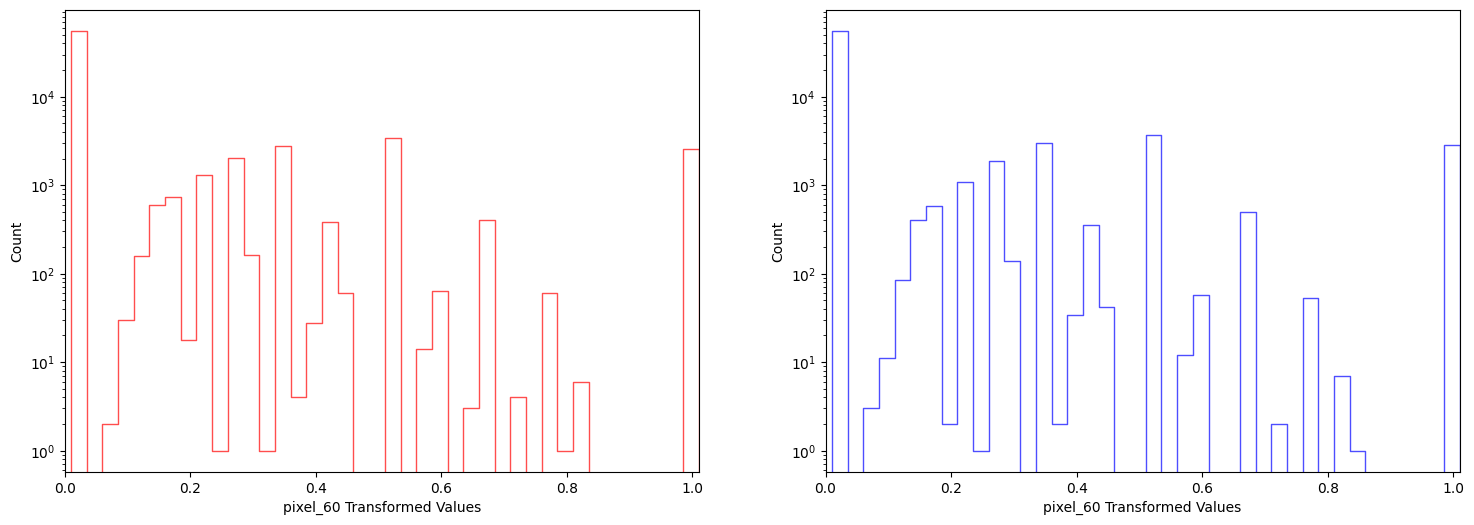

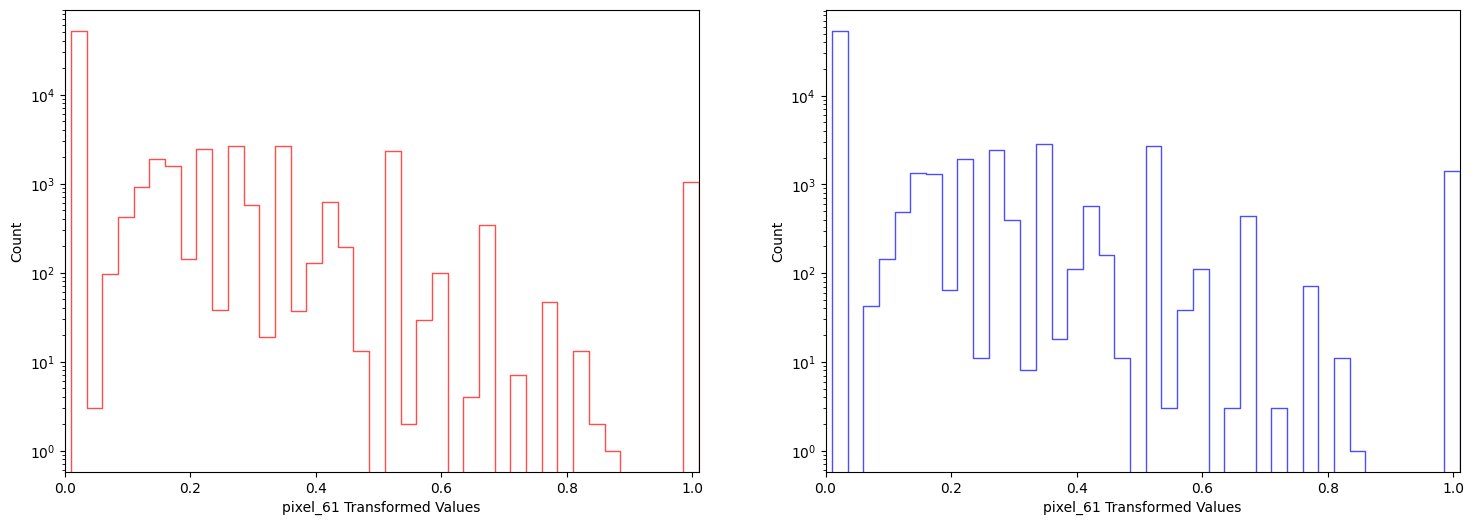

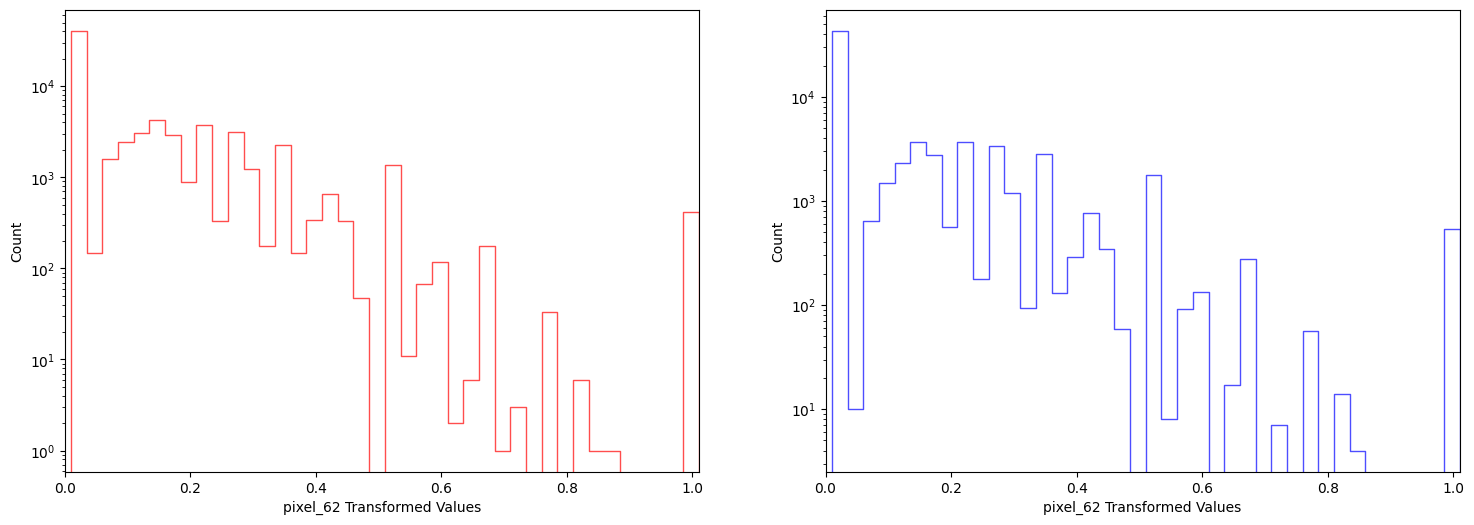

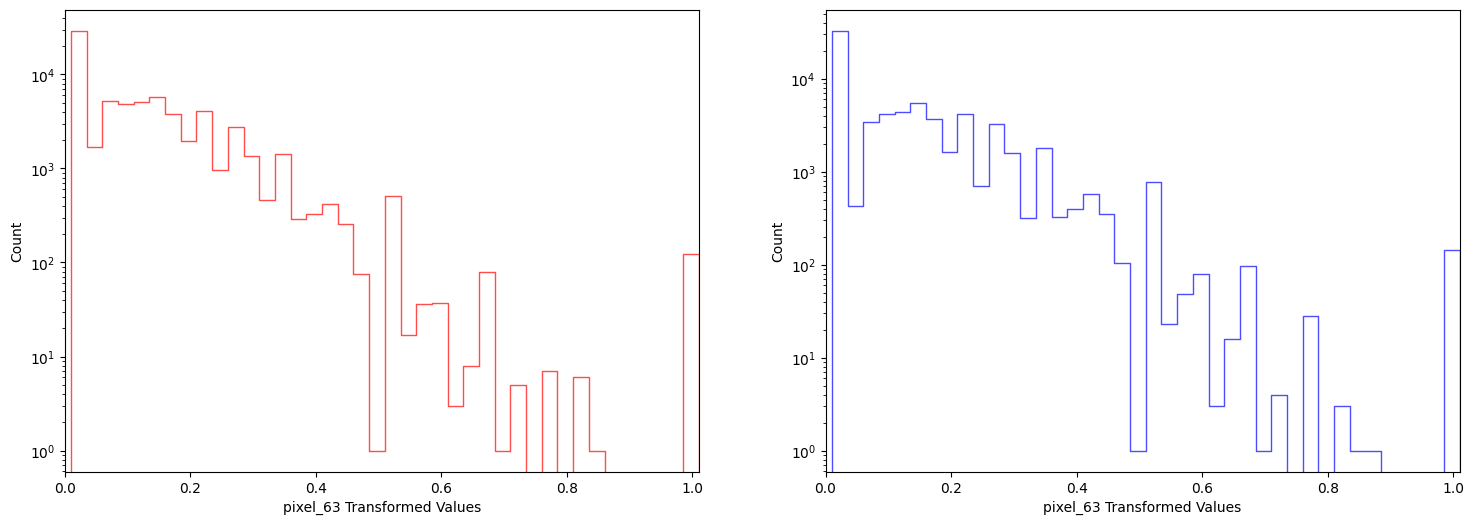

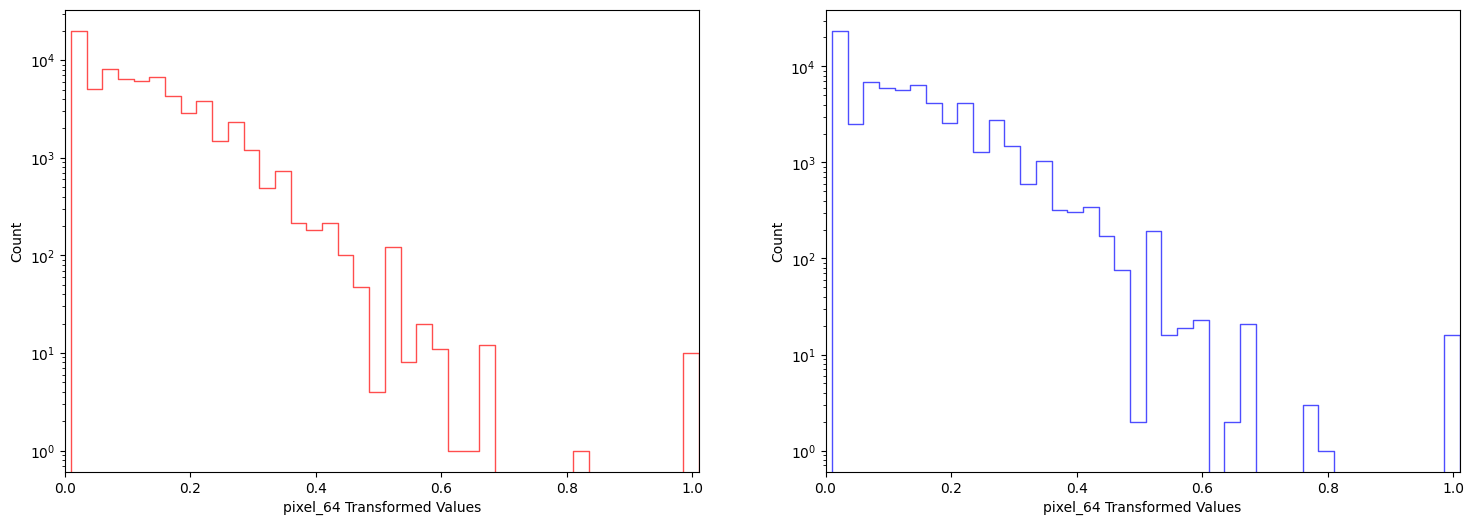

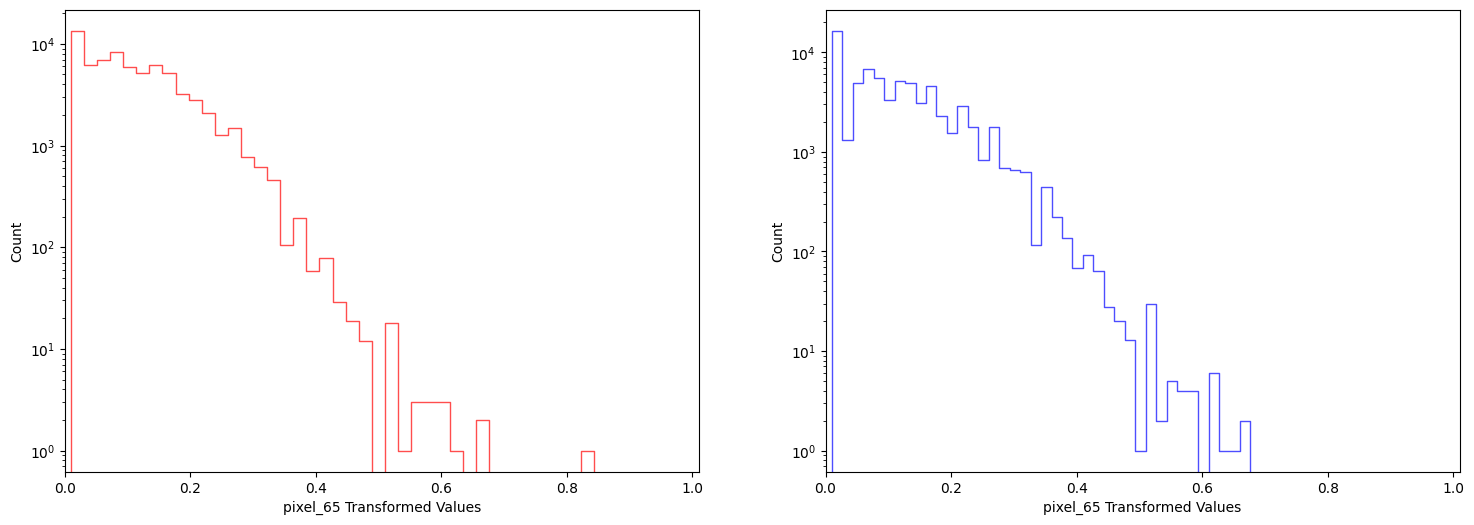

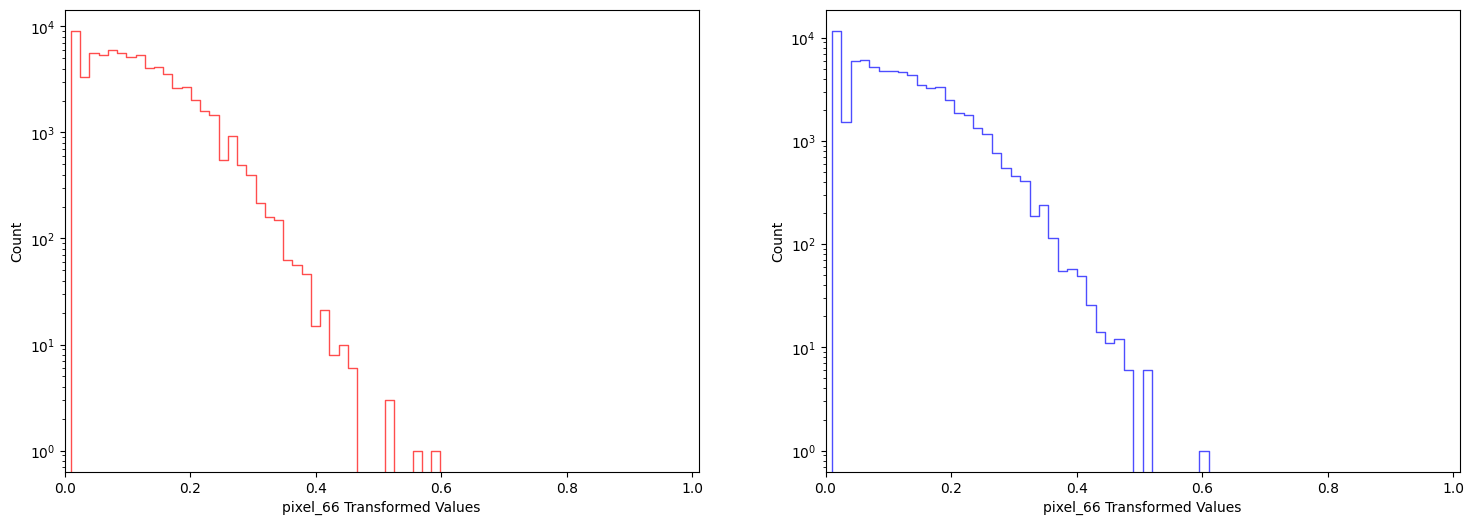

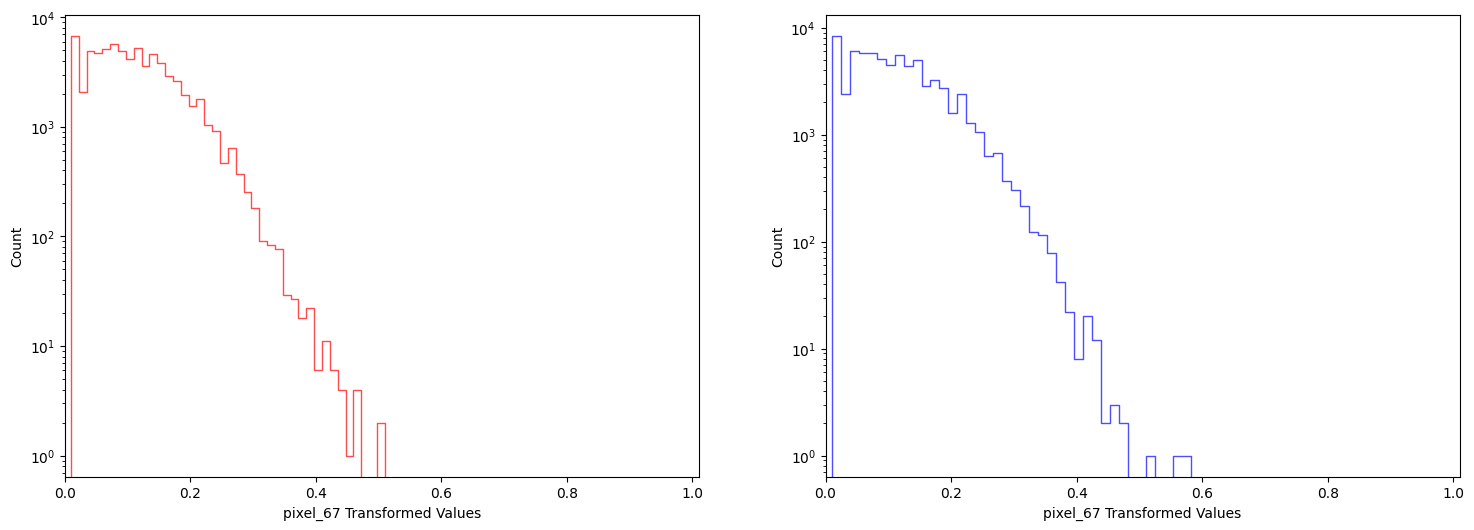

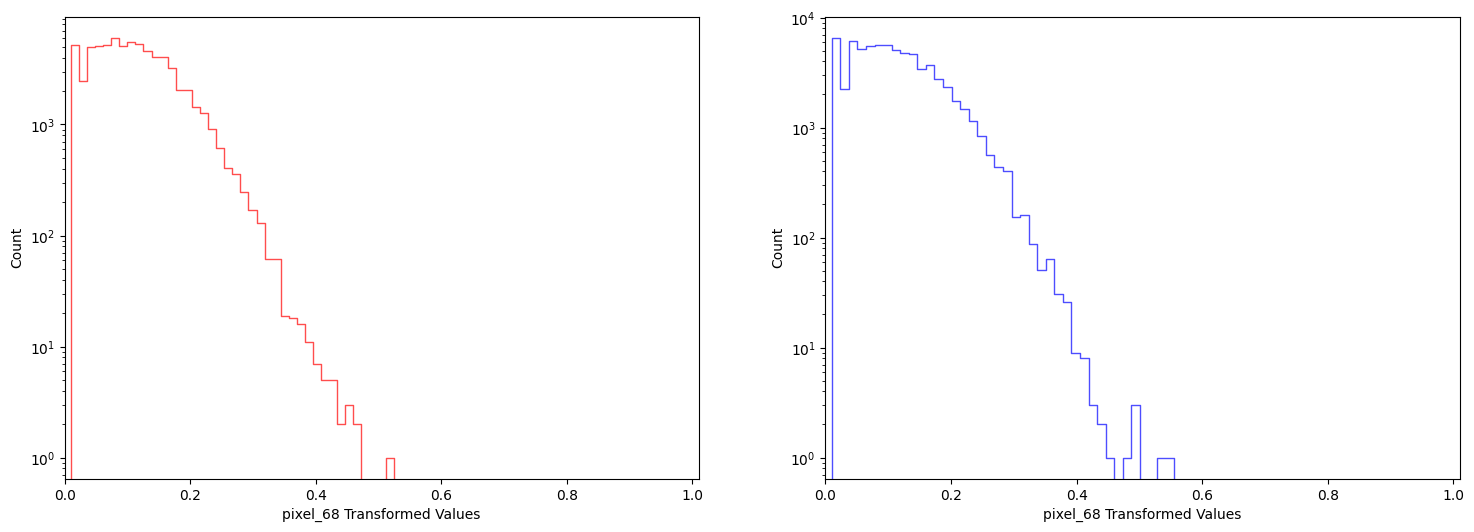

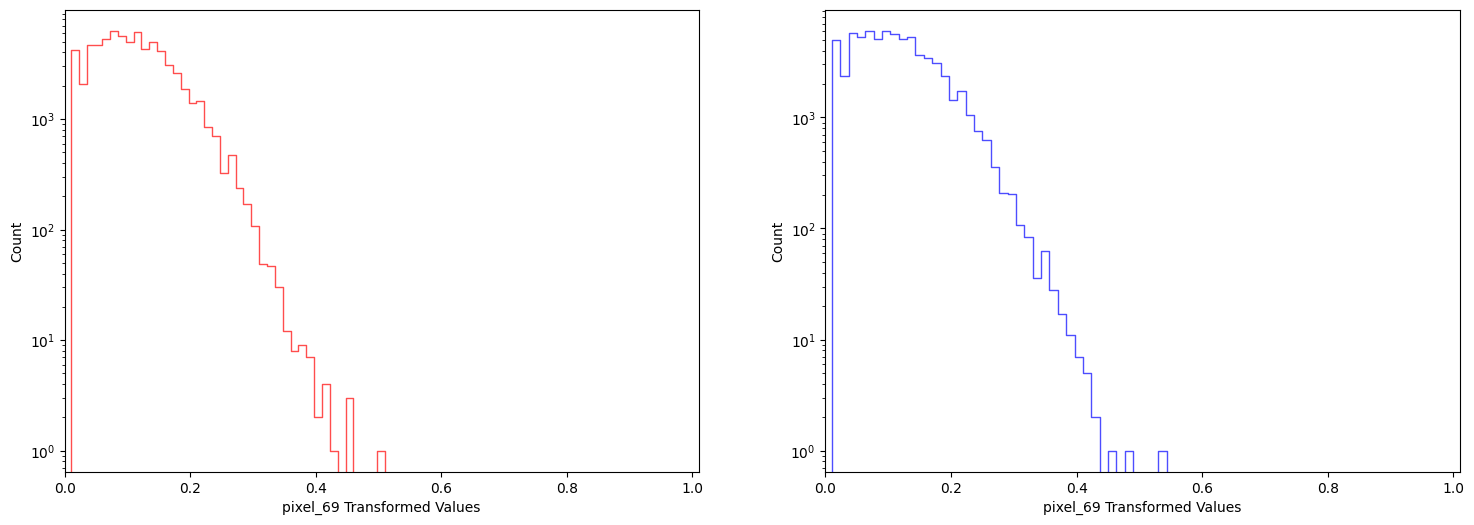

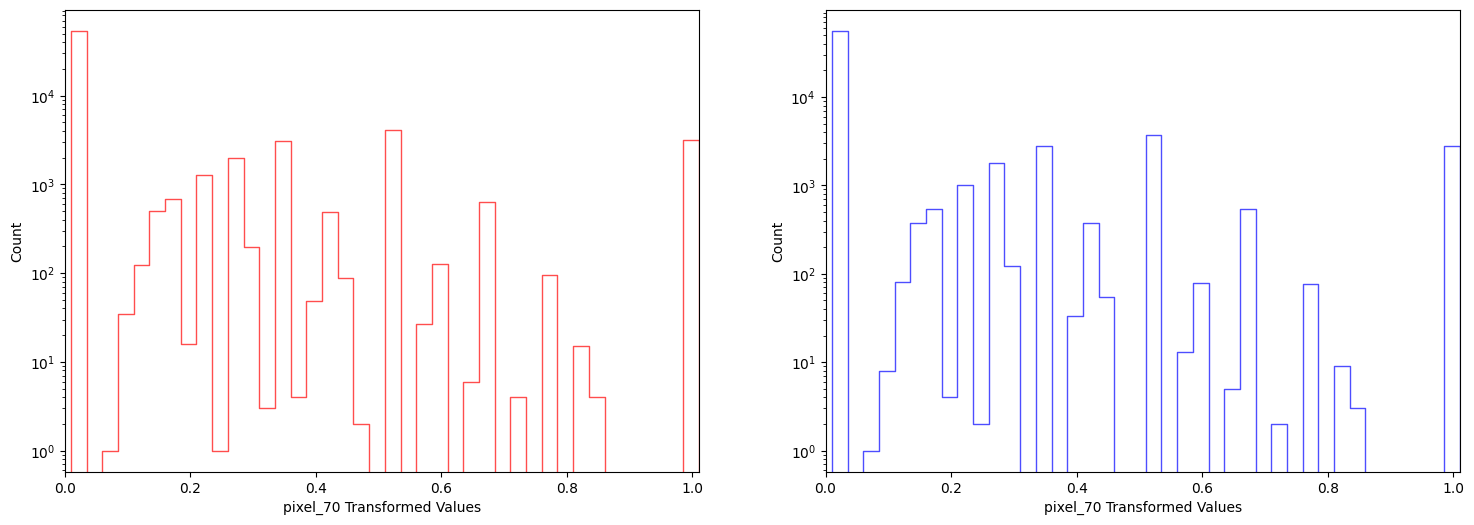

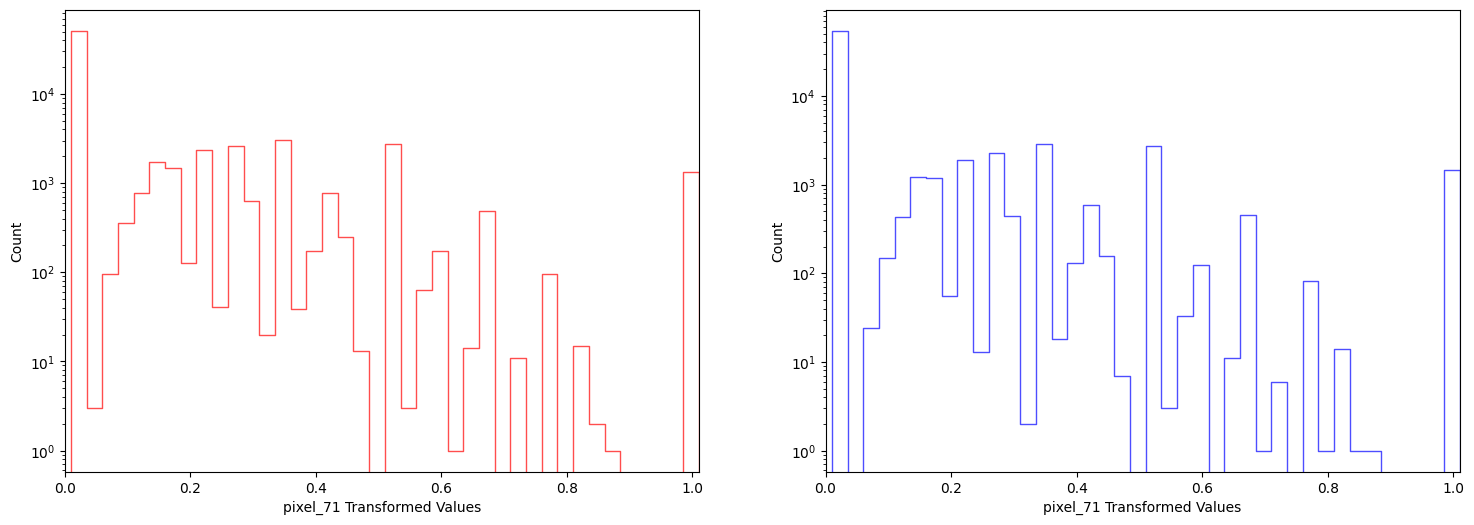

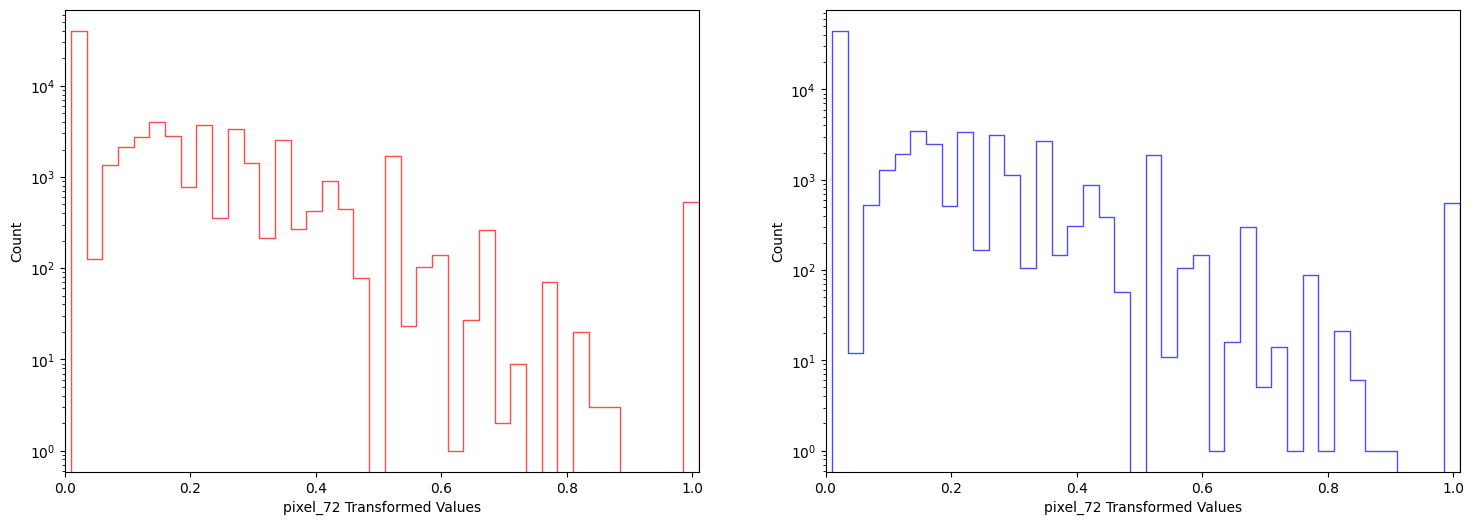

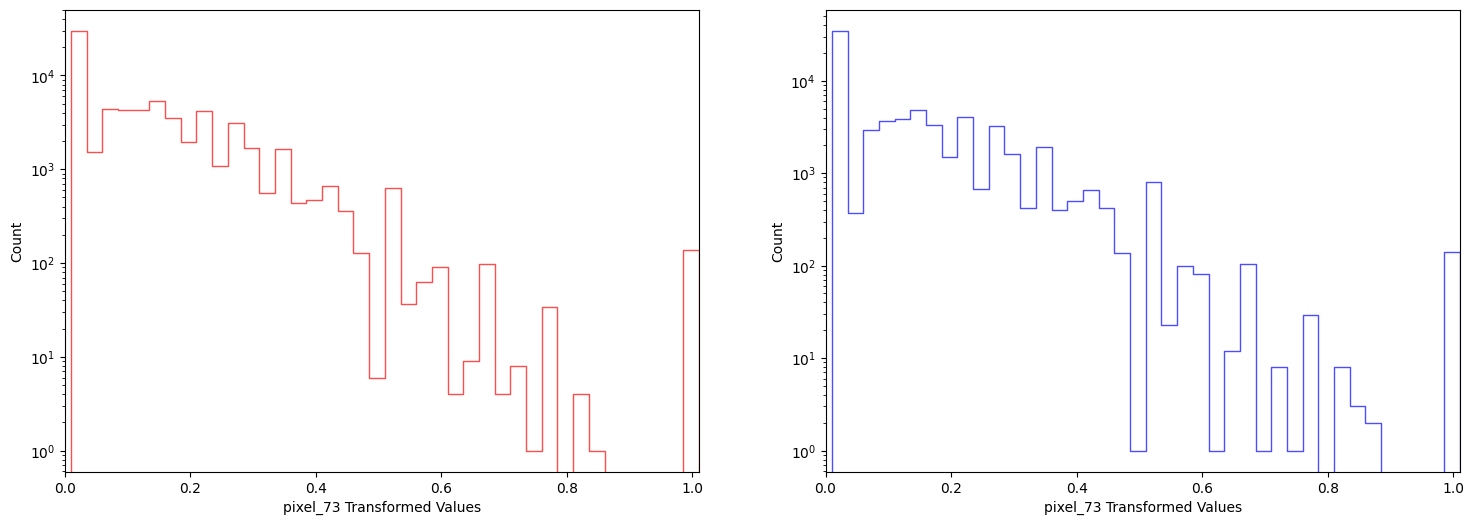

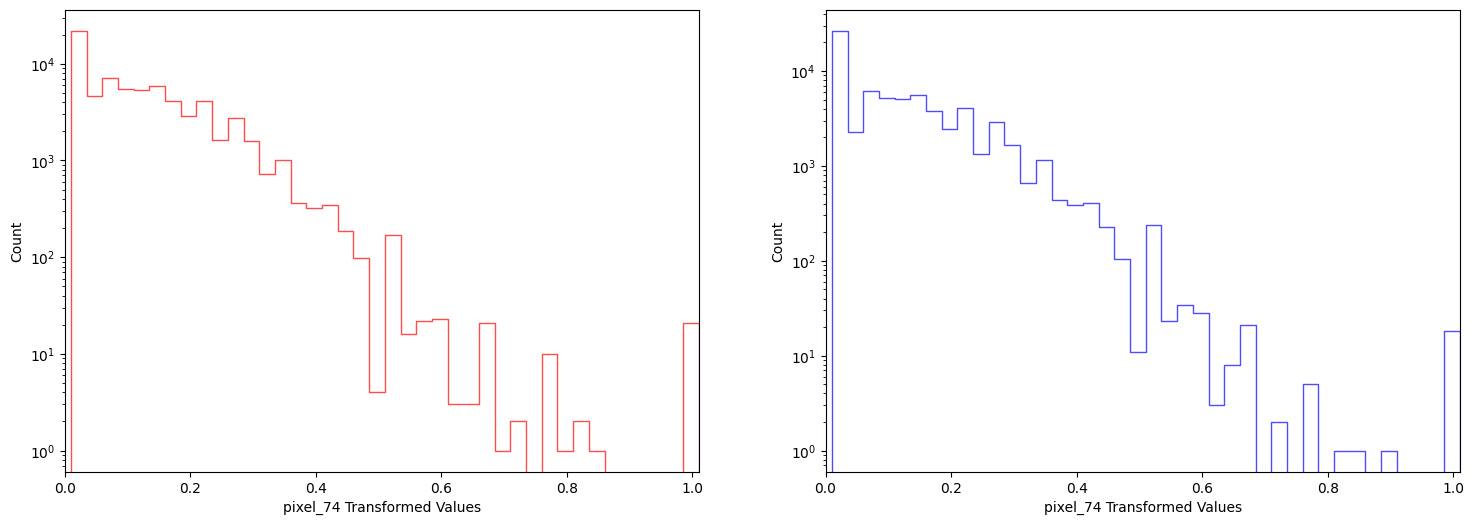

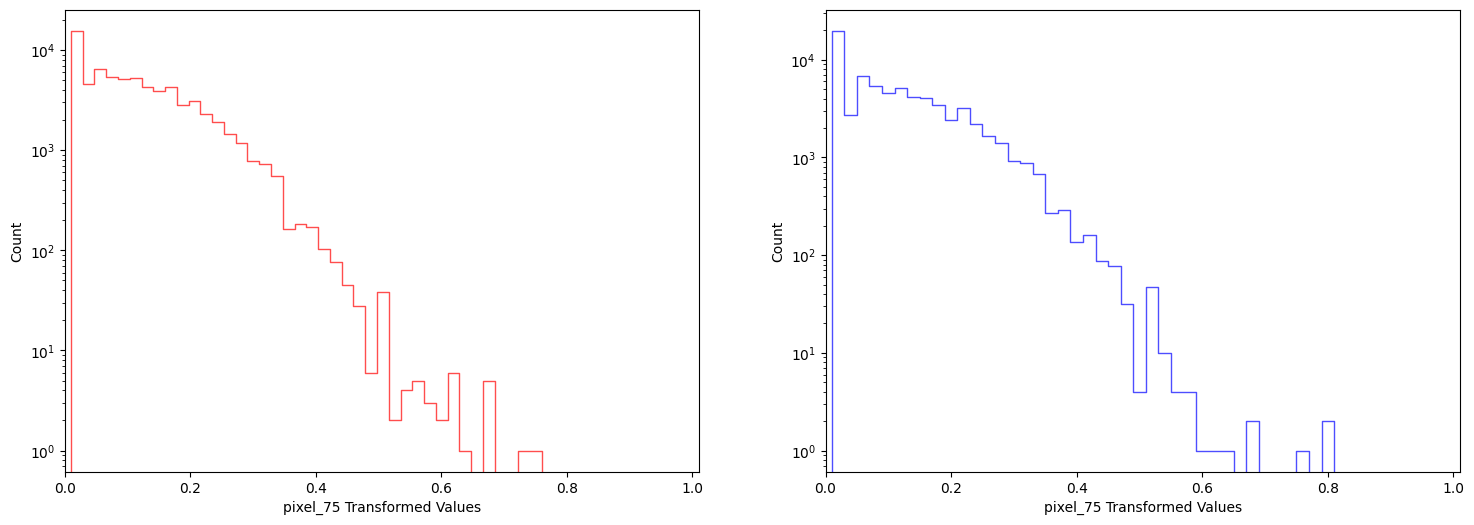

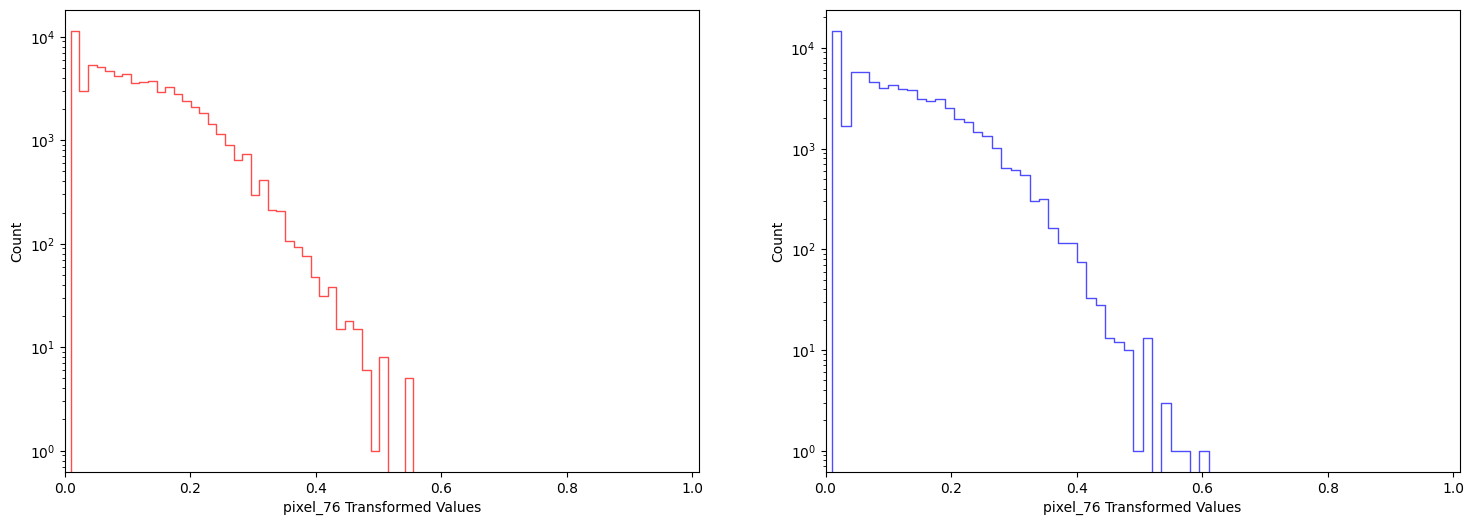

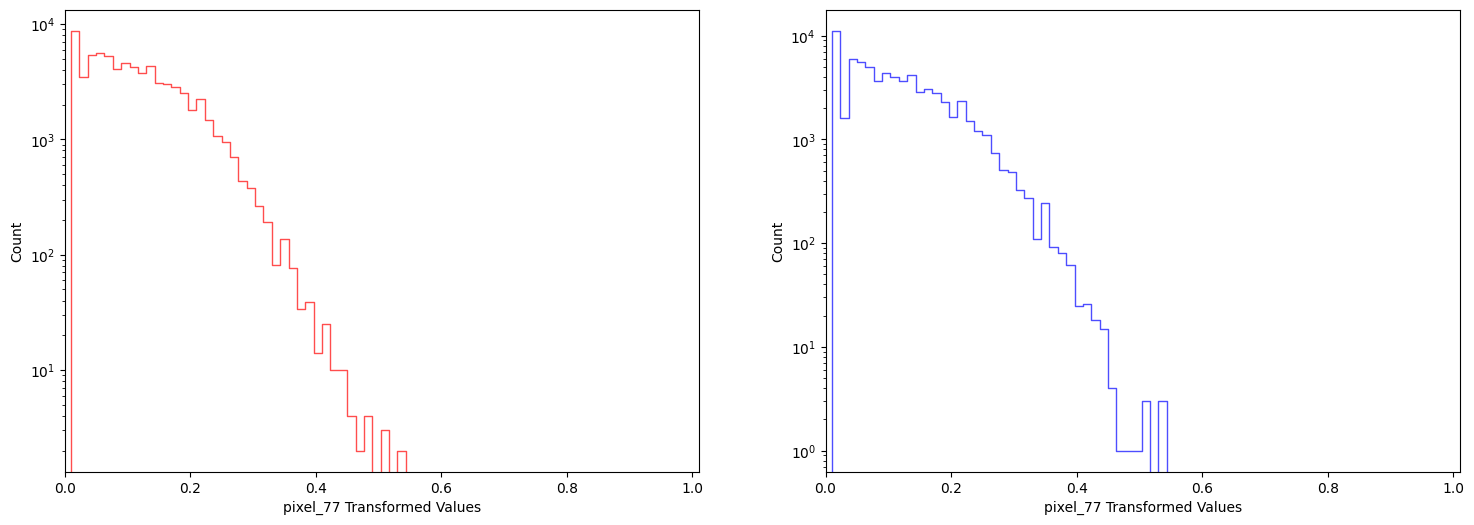

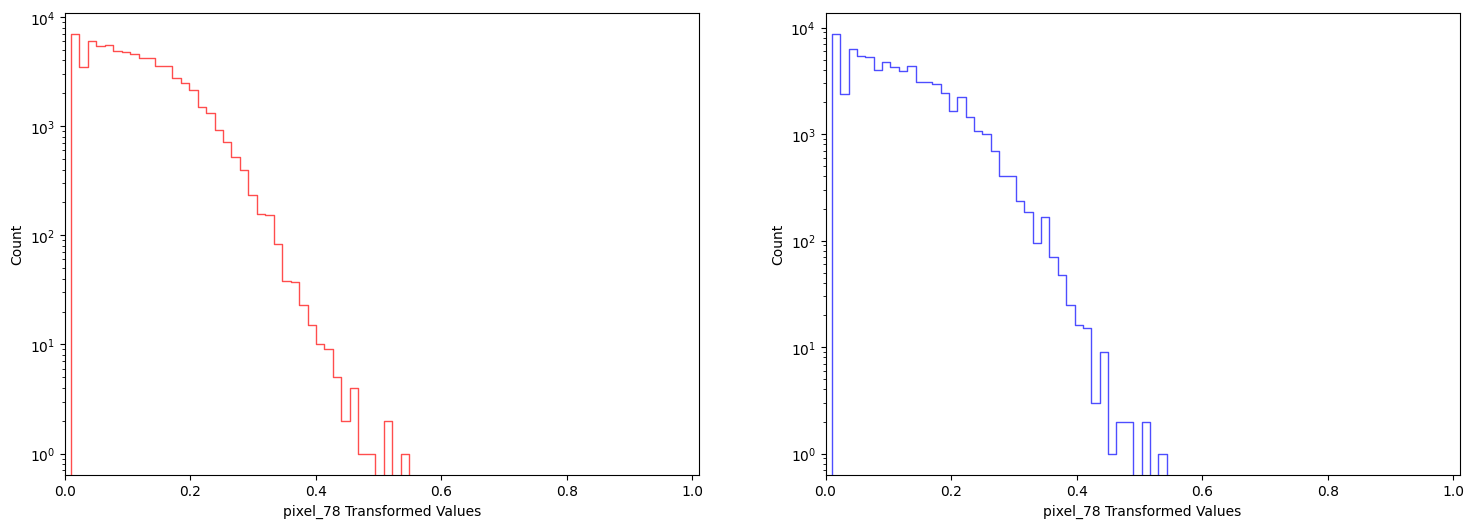

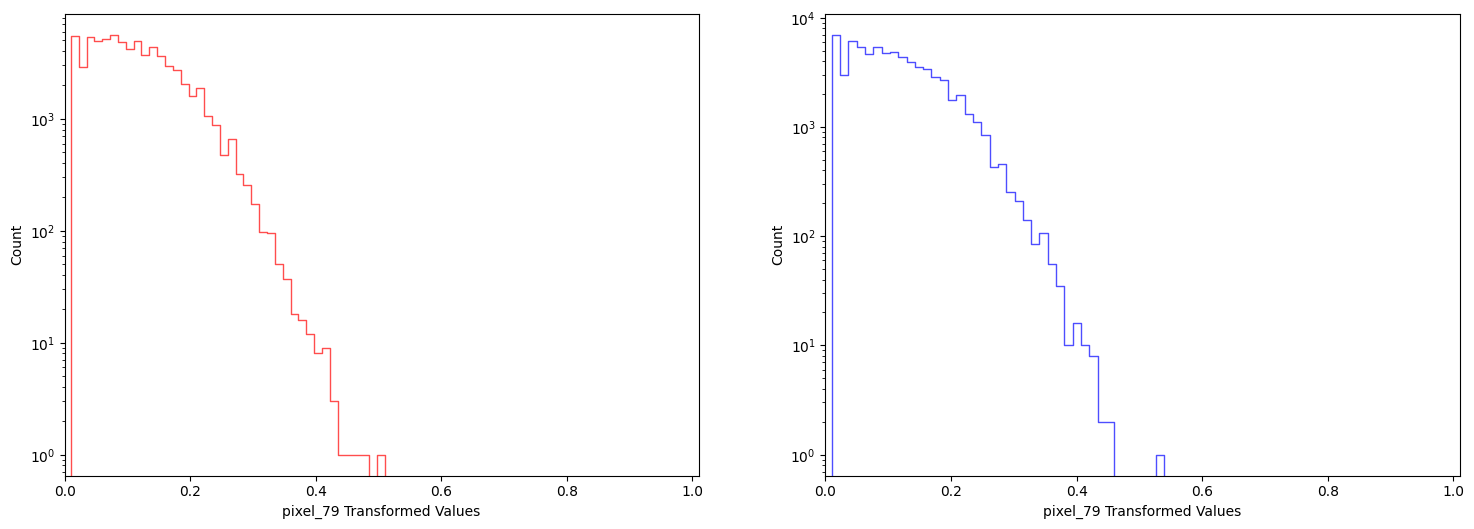

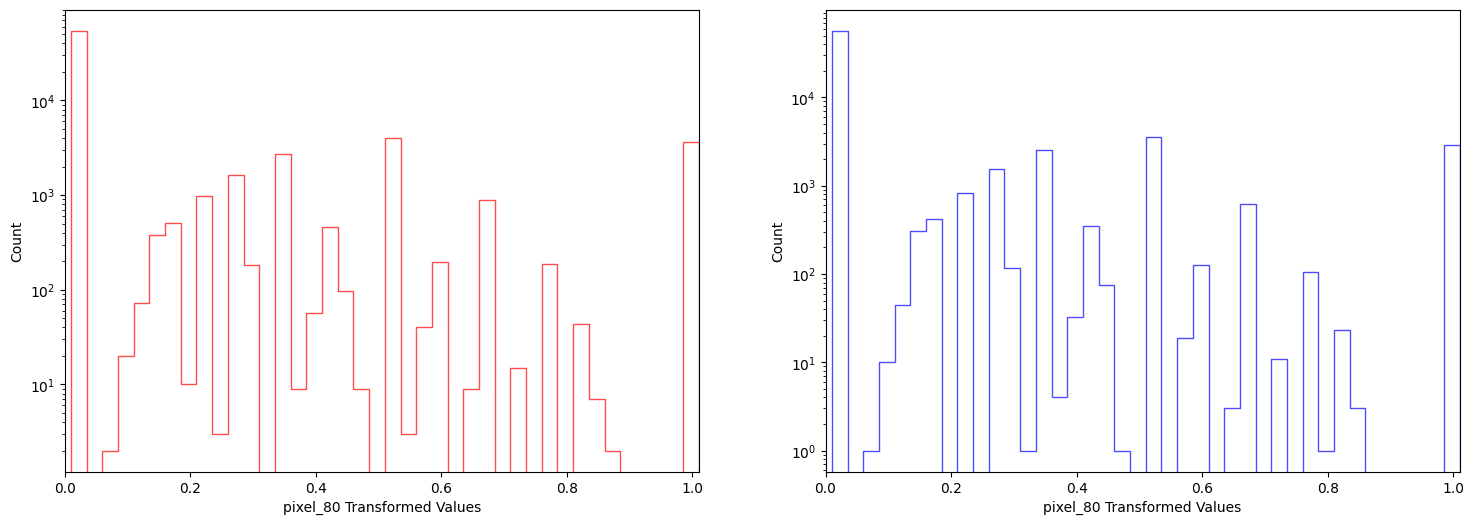

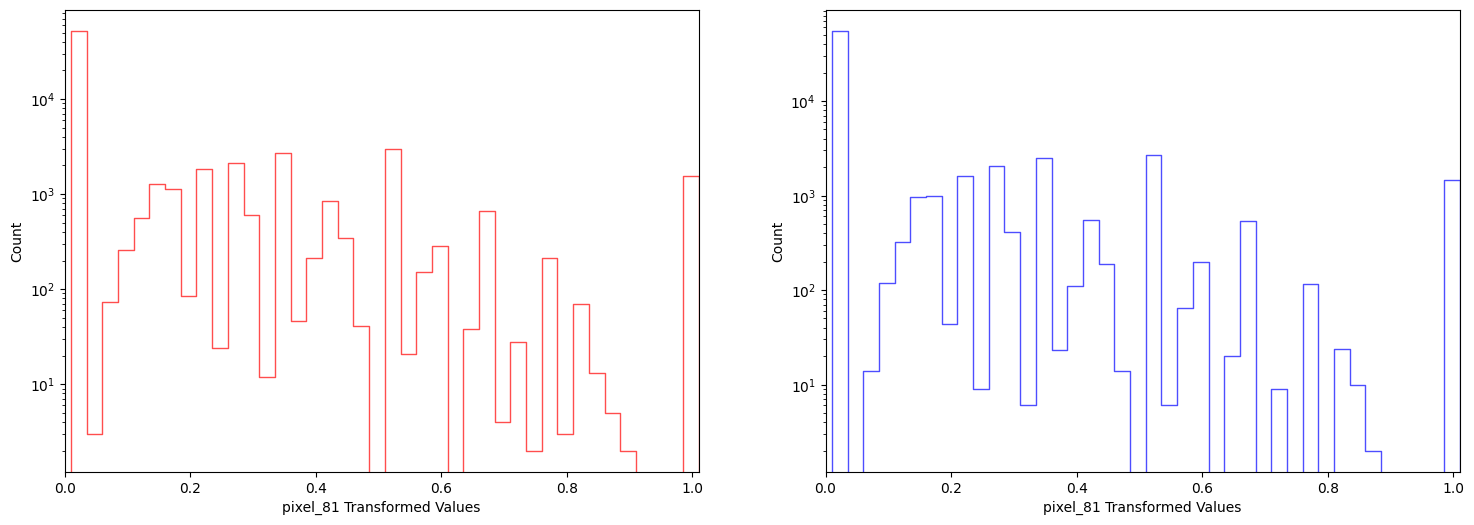

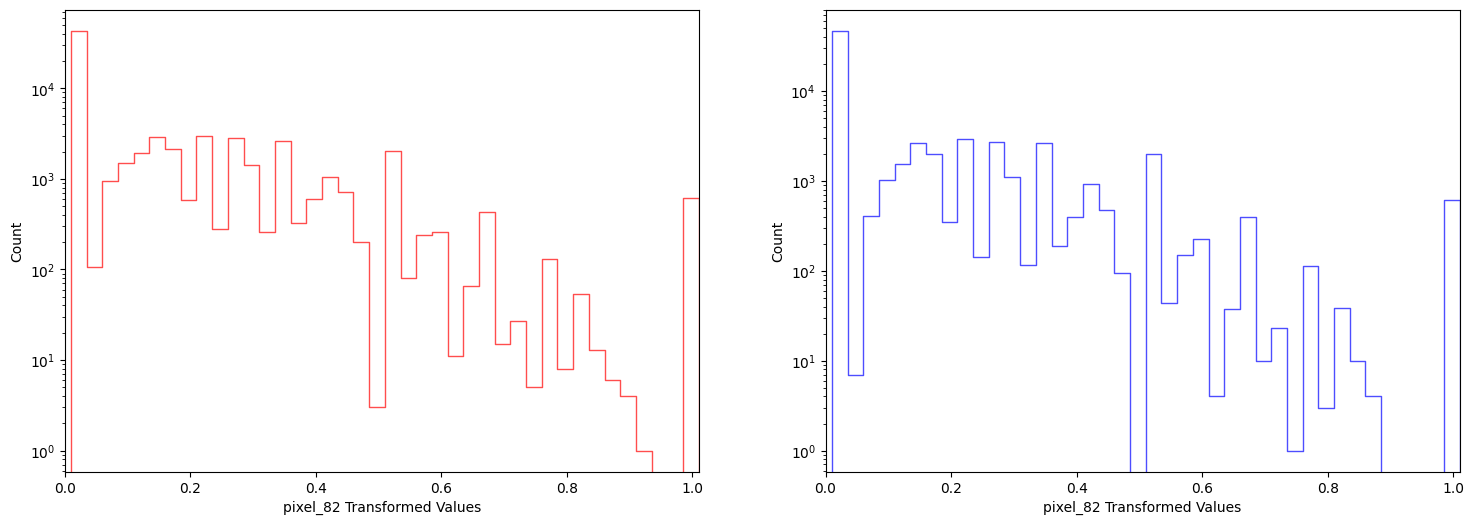

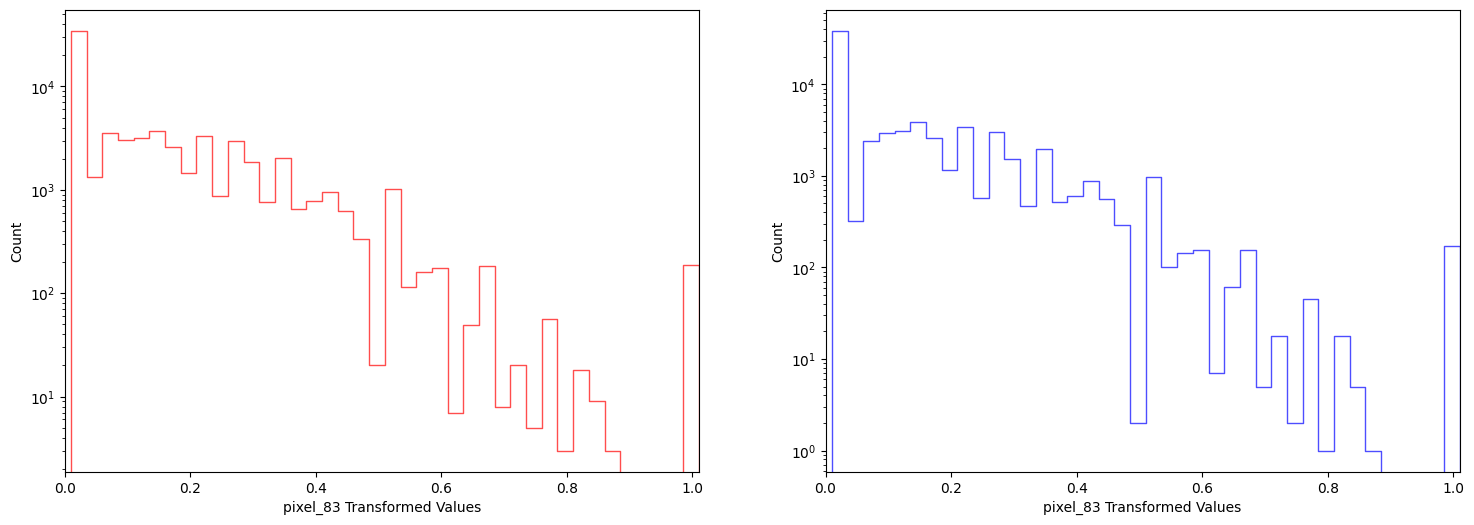

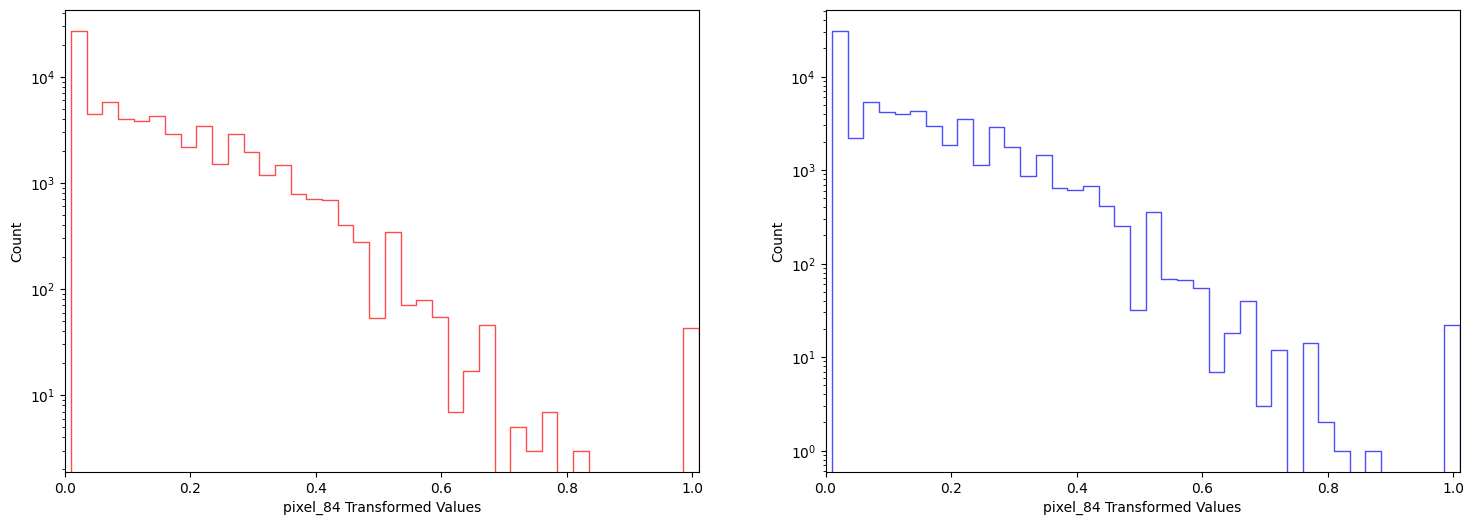

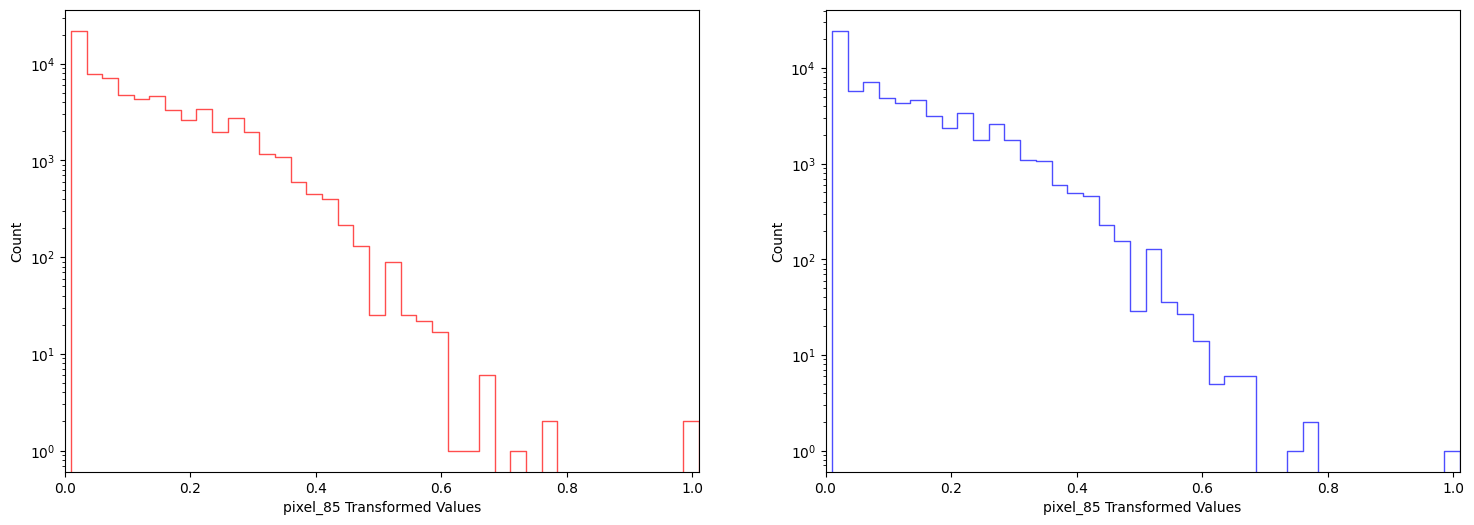

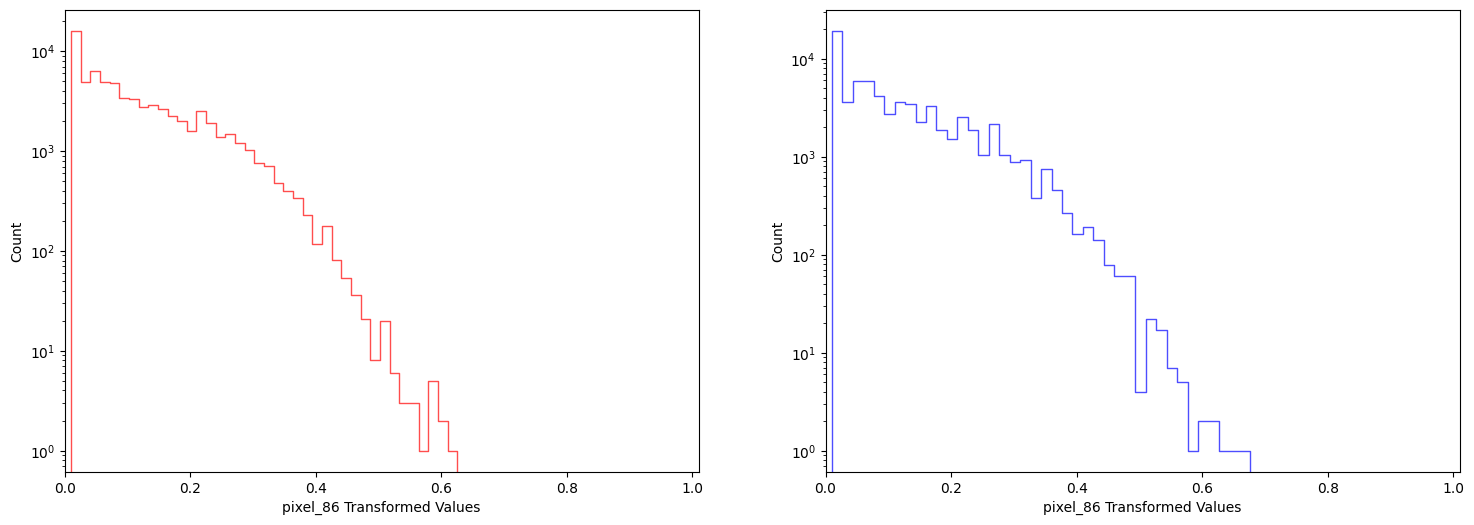

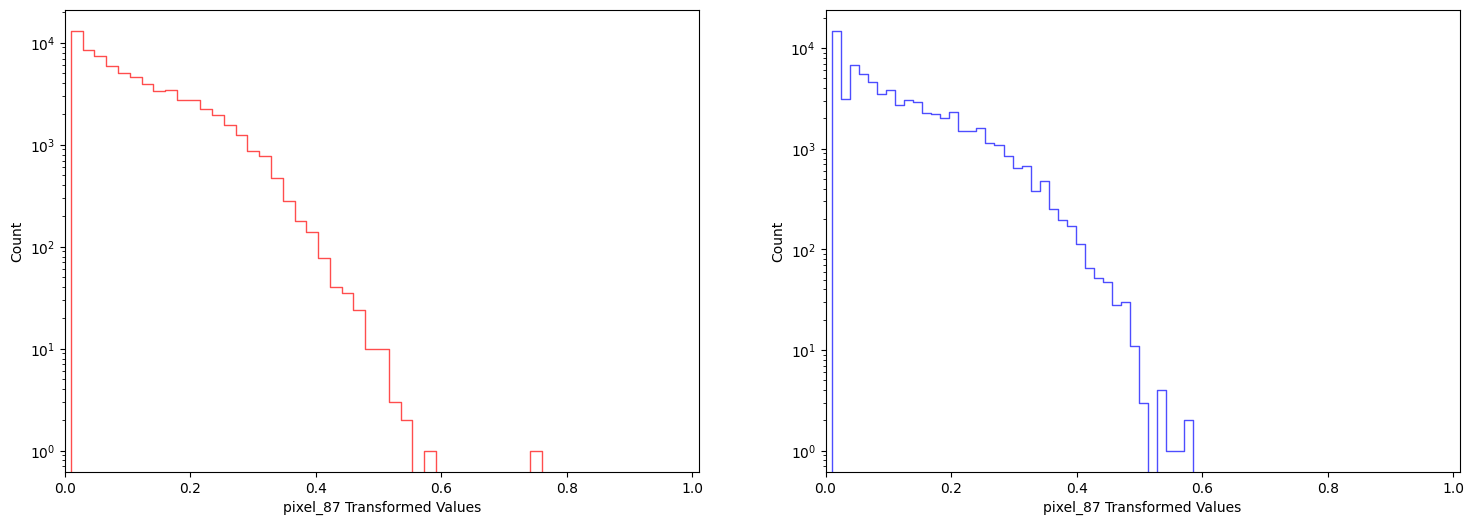

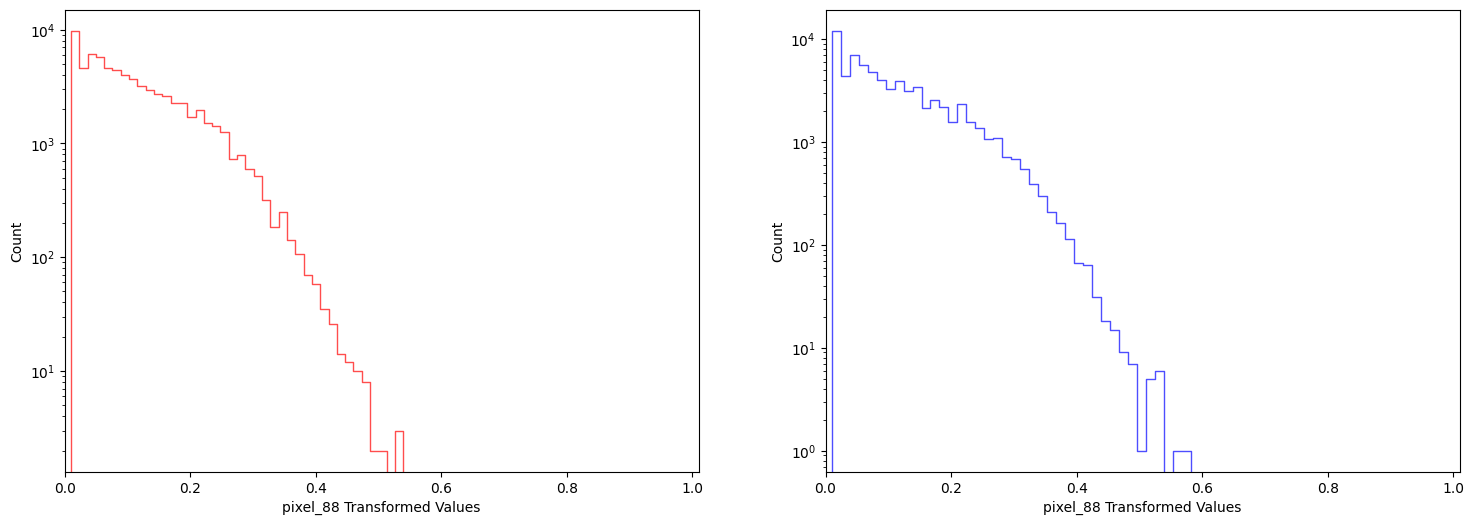

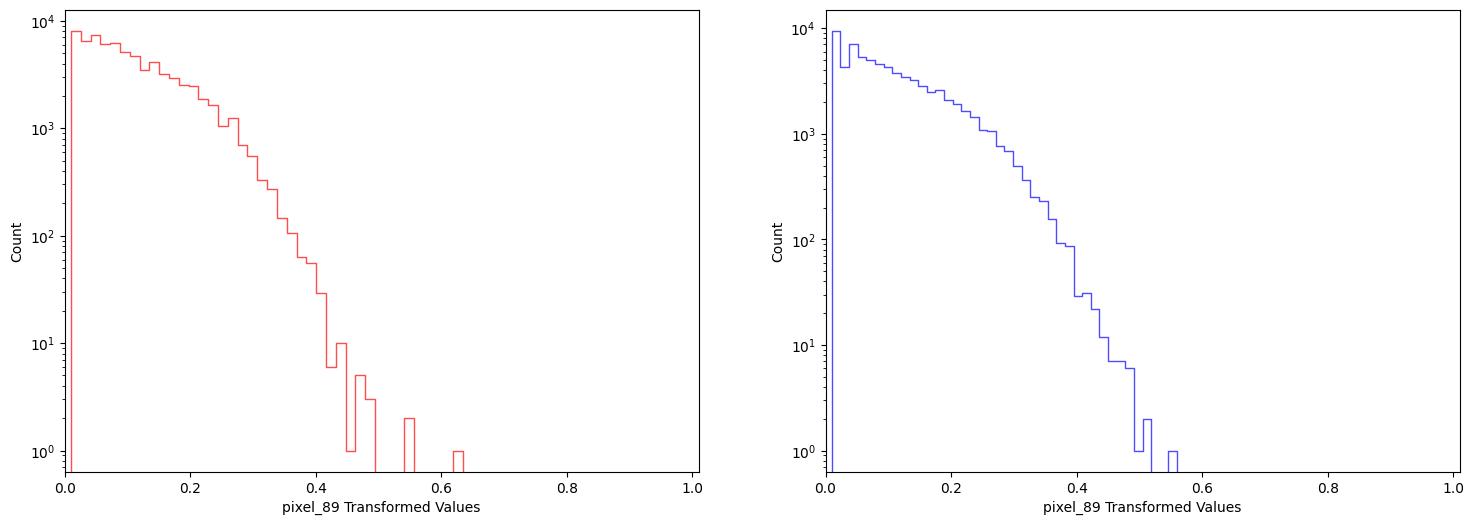

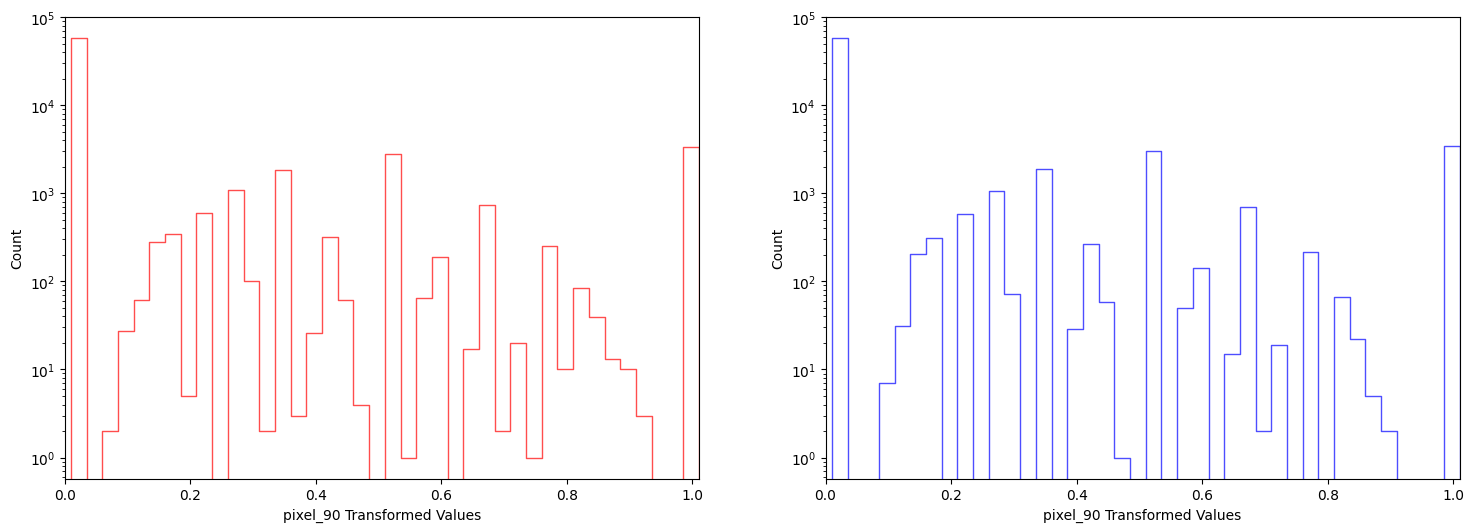

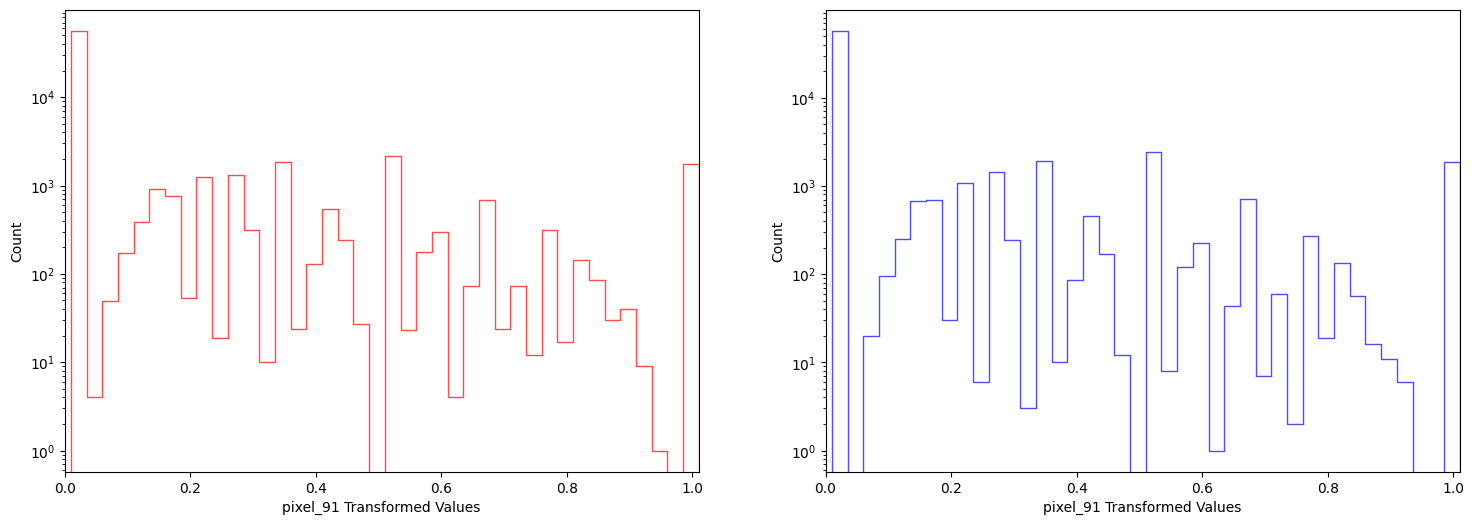

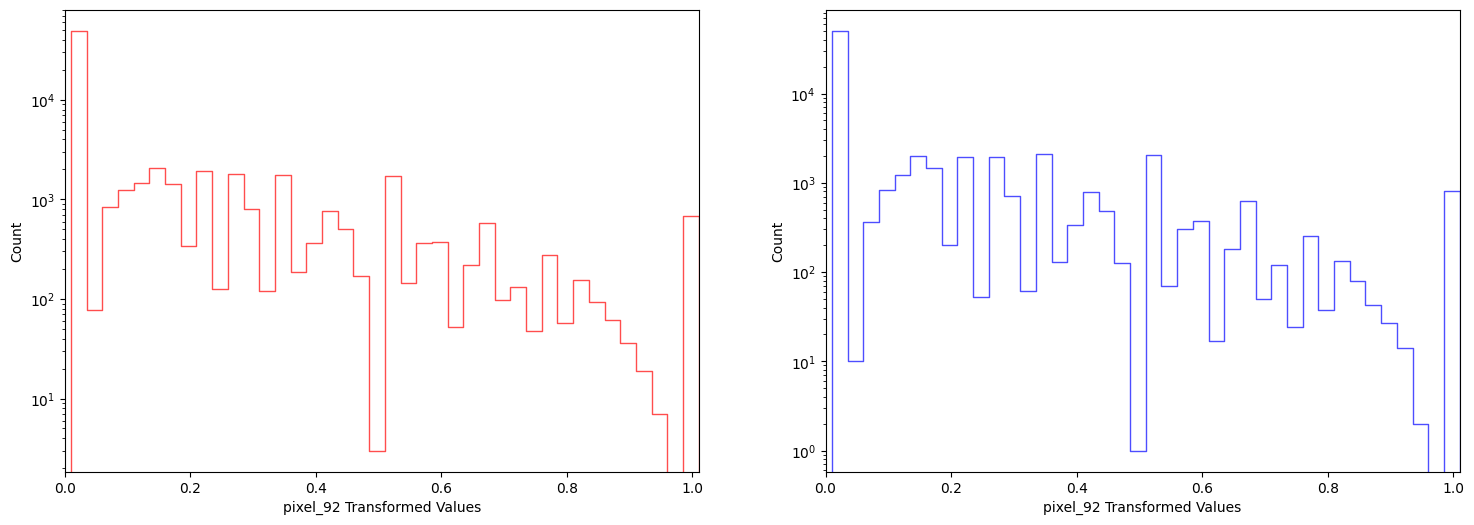

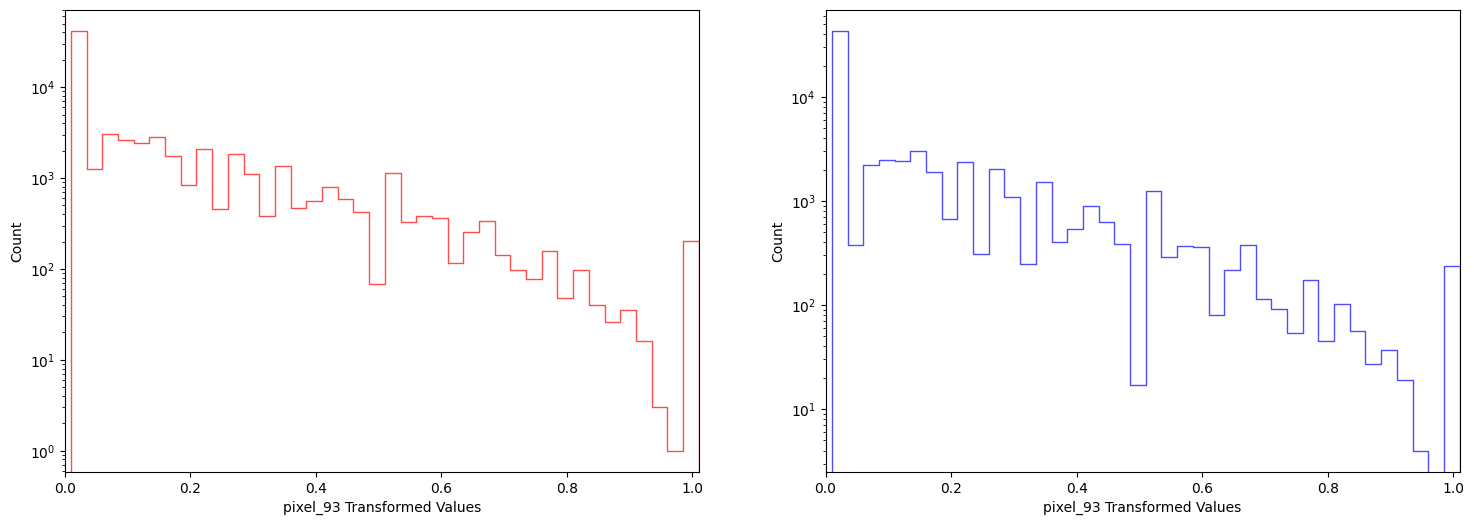

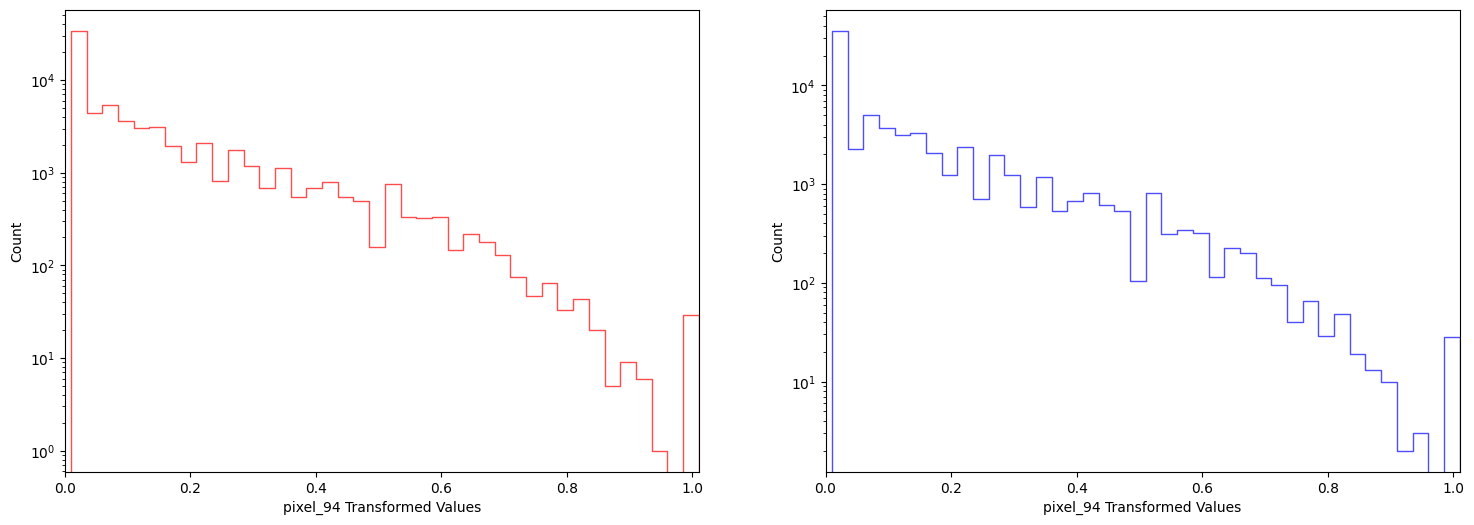

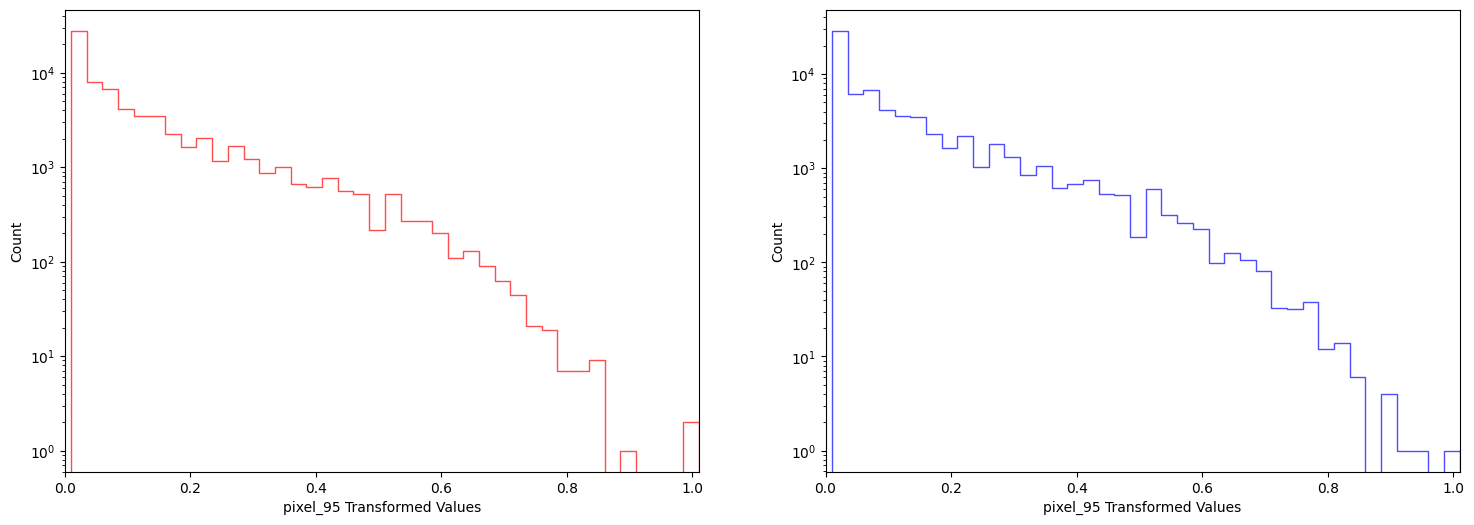

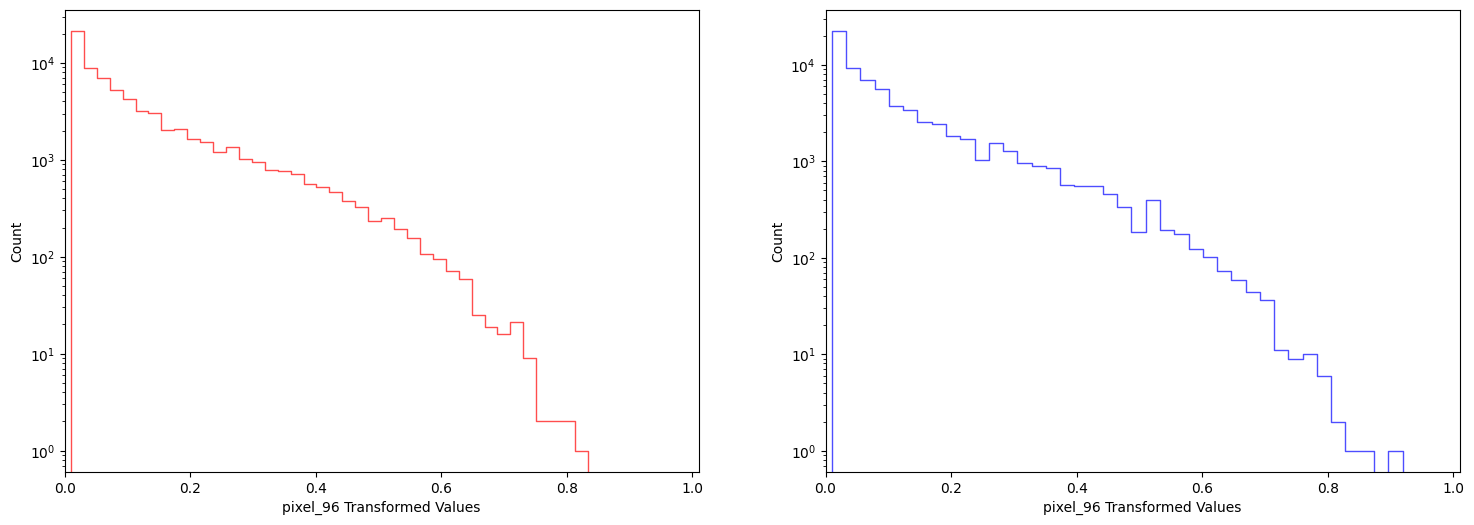

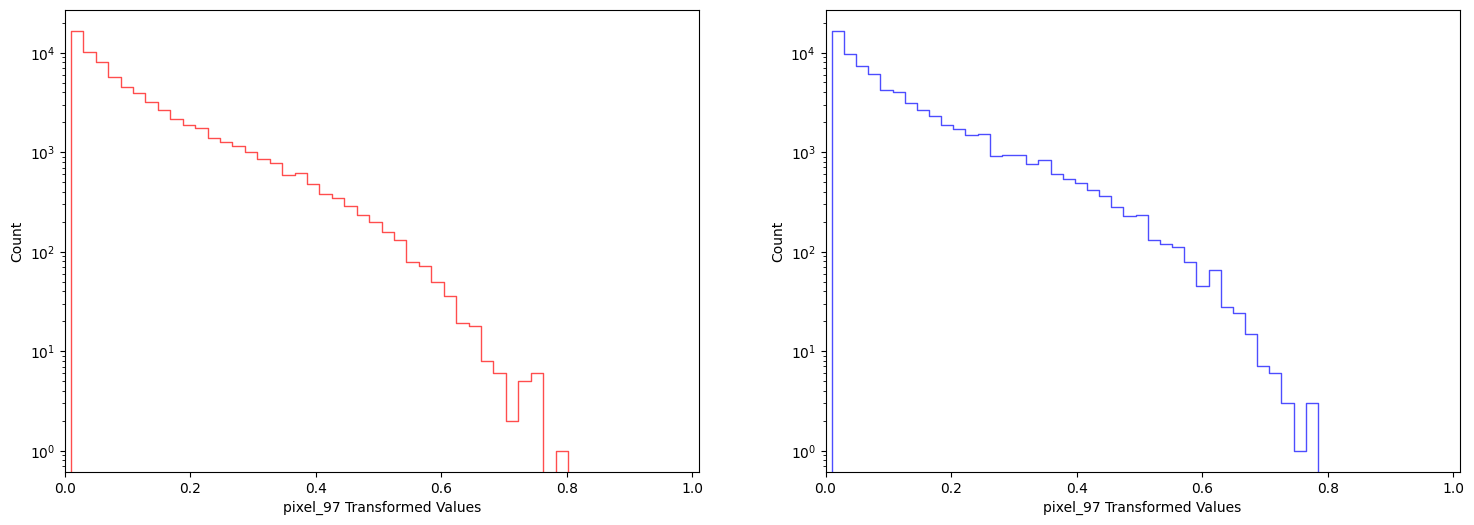

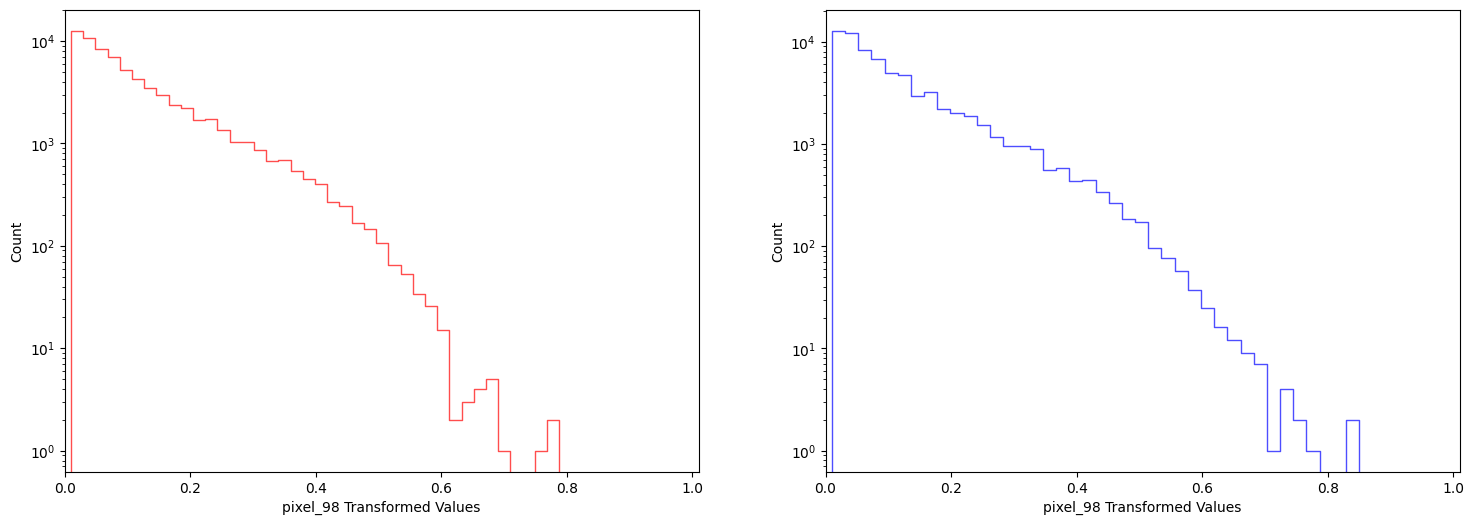

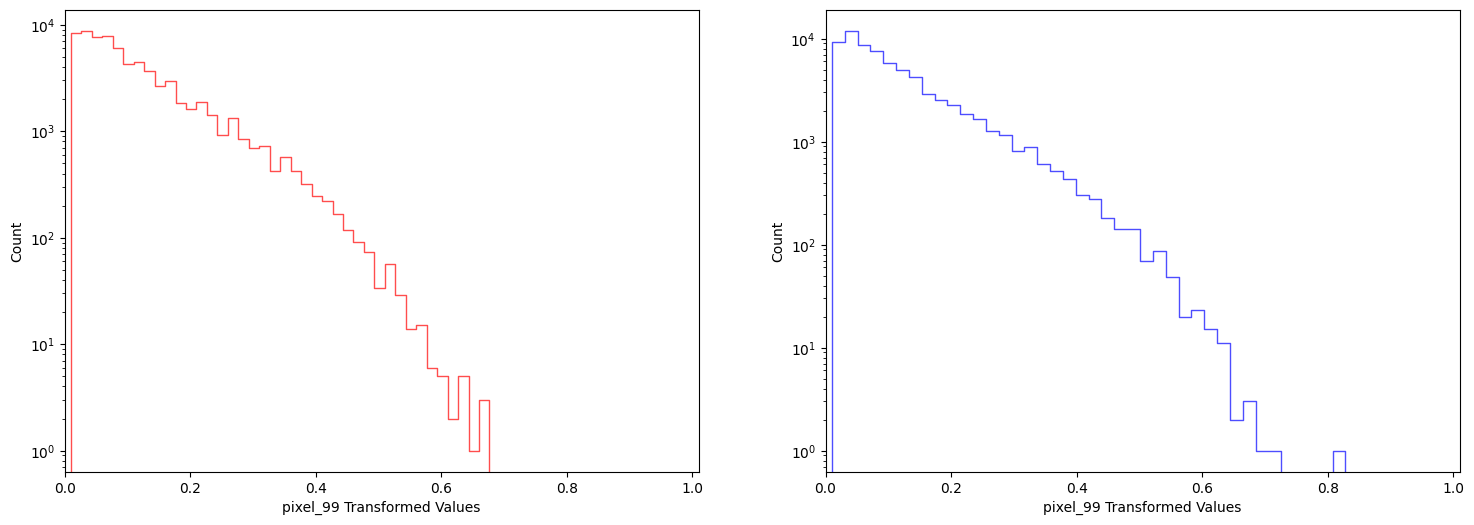

In [20]:
bins_pxl = 40

N_pixels = pixel_train_transf_bkg.shape[1]
for pixel_i in range(N_pixels):
    pixel_i_train_sig = pixel_train_transf_sig[:,pixel_i]
    pixel_i_train_bkg = pixel_train_transf_bkg[:,pixel_i]

    fig, axes = plt.subplots(1, 2,  figsize=(18, 6))
    sn.histplot(pixel_i_train_sig, ax = axes[0], bins = bins_pxl, color = red_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ train')
    sn.histplot(pixel_i_train_bkg, ax = axes[1], bins = bins_pxl, color = blue_variants[0], element = 'step', alpha = 0, label = '208-Tl train')

    axes[0].set_yscale('log')
    axes[0].set_xlabel(f'pixel_{pixel_i} Transformed Values')
    axes[0].set_xlim(0, 1 + epsilon)
    
    axes[1].set_yscale('log')
    axes[1].set_xlabel(f'pixel_{pixel_i} Transformed Values')
    axes[1].set_xlim(0, 1 + epsilon)

    

    plt.show()

#### Energy and Position

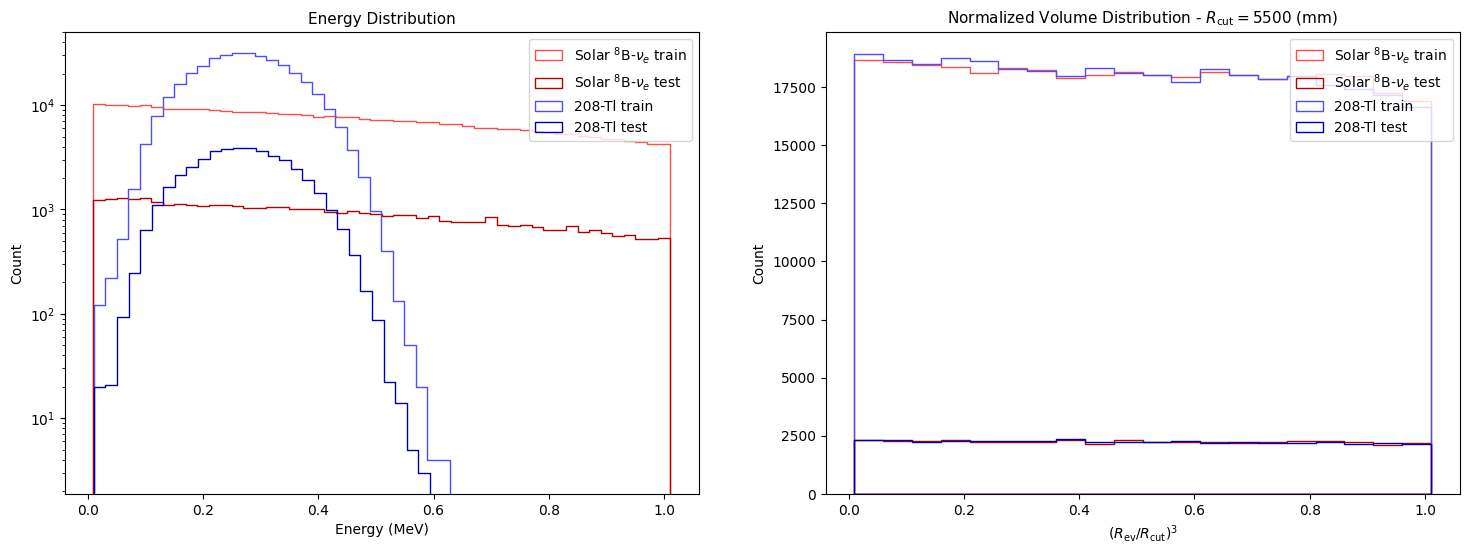

In [18]:
binwidth_en = 0.02
binwidth_rad = 0.05

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#Energy Plots
sn.histplot(energy_train_transf_sig, ax = axes[0], binwidth = binwidth_en, color = red_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ train')
sn.histplot(energy_test_transf_sig, ax = axes[0], binwidth = binwidth_en, color = red_variants[1], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test')
sn.histplot(energy_train_transf_bkg, ax = axes[0], binwidth = binwidth_en, color = blue_variants[0], element = 'step', alpha = 0, label = '208-Tl train')
sn.histplot(energy_test_transf_bkg, ax = axes[0], binwidth = binwidth_en, color = blue_variants[1], element = 'step', alpha = 0, label = '208-Tl test')

#Radial Plots
sn.histplot(position_train_transf_sig, ax = axes[1], binwidth = binwidth_rad, color = red_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ train')
sn.histplot(position_test_transf_sig, ax = axes[1], binwidth = binwidth_rad, color = red_variants[1], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test')
sn.histplot(position_train_transf_bkg, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[0], element = 'step', alpha = 0, label = '208-Tl train')
sn.histplot(position_test_transf_bkg, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[1], element = 'step', alpha = 0, label = '208-Tl test')

axes[0].set_xlabel('Energy (MeV)')
axes[0].legend(loc='upper right')
axes[0].set_title('Energy Distribution', fontsize = 11)
axes[0].set_yscale('log')

axes[1].set_xlabel(r'$(R_\text{ev}/R_\text{cut})^{3}$')
axes[1].legend(loc='upper right')
axes[1].set_title(r'Normalized Volume Distribution - $R_\text{cut} = $5500 (mm)', fontsize = 11)
#axes[1].set_ylim(500, 6000)

#plt.savefig('figs/Optimized Models/10x10/Std_Rad_Norm_Vol and Std_Scaler_default Solar Energy/MLM4_5500_(2.5_12)_(-5_7)_aucOP_test_split/split_test_energy.png', format = 'png', bbox_inches = 'tight')
plt.show()

## Extract a Validation Dataset to be implemented in the Model

In [19]:
pixel_train1_transf, pixel_val_transf, \
energy_train1_transf, energy_val_transf, \
position_train1_transf, position_val_transf, \
labels_train1, labels_val = train_test_split(pixel_train_transf, energy_train_transf, position_train_transf,
                                            labels_train, test_size = 0.3,
                                            stratify = labels_train,
                                            random_state=42)

### Plots with Validation Dataset split

In [20]:
#Separar sig from bkg in new train1 and validation
IsNu = np.array([1,0])
IsTl = np.array([0,1])

sig_mask_train = np.all(labels_train1 == IsNu, axis=1)
bkg_mask_train = np.all(labels_train1 == IsTl, axis=1)

sig_mask_val = np.all(labels_val == IsNu, axis=1)
bkg_mask_val = np.all(labels_val == IsTl, axis=1)

#Train: Separation sig from bkg
pixel_train1_transf_sig = pixel_train1_transf[sig_mask_train]
pixel_train1_transf_bkg = pixel_train1_transf[bkg_mask_train]

energy_train1_transf_sig = energy_train1_transf[sig_mask_train]
energy_train1_transf_bkg = energy_train1_transf[bkg_mask_train]

position_train1_transf_sig = position_train1_transf[sig_mask_train]
position_train1_transf_bkg = position_train1_transf[bkg_mask_train]

#Validation: Separation sig from bkg
pixel_val_transf_sig = pixel_val_transf[sig_mask_val]
pixel_val_transf_bkg = pixel_val_transf[bkg_mask_val]

energy_val_transf_sig = energy_val_transf[sig_mask_val]
energy_val_transf_bkg = energy_val_transf[bkg_mask_val]

position_val_transf_sig = position_val_transf[sig_mask_val]
position_val_transf_bkg = position_val_transf[bkg_mask_val]

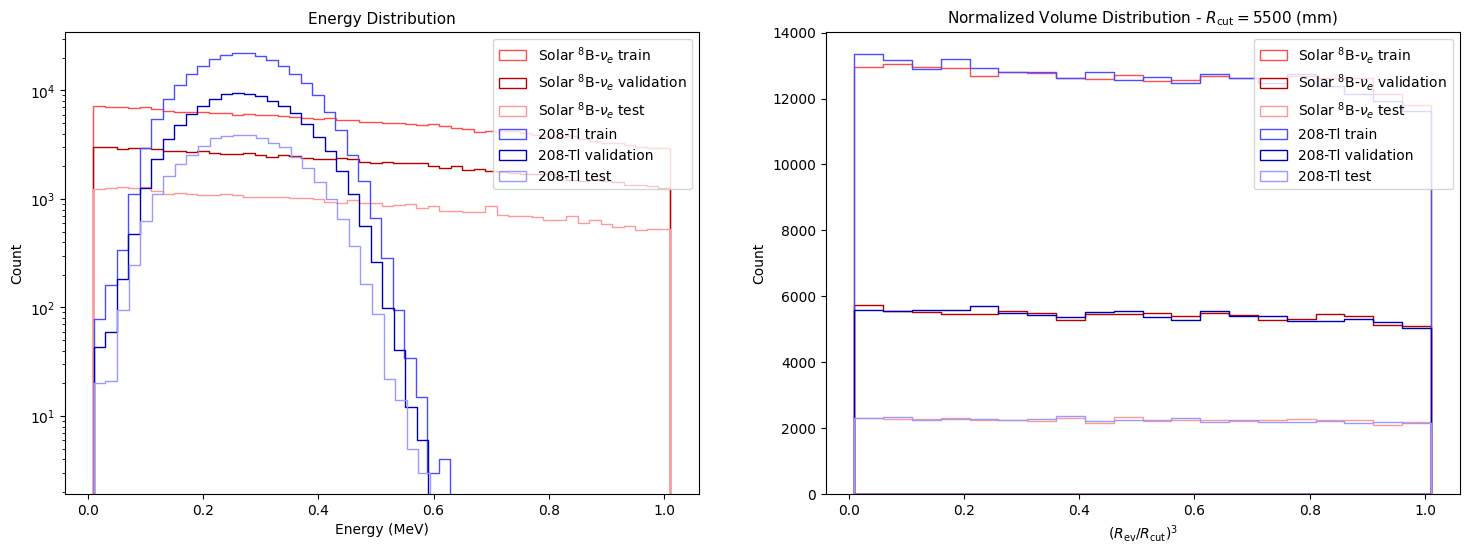

In [21]:
binwidth_en = 0.02
binwidth_rad = 0.05

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#Energy Plots
sn.histplot(energy_train1_transf_sig, ax = axes[0], binwidth = binwidth_en, color = red_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ train')
sn.histplot(energy_val_transf_sig, ax = axes[0], binwidth = binwidth_en, color = red_variants[1], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ validation')
sn.histplot(energy_test_transf_sig, ax = axes[0], binwidth = binwidth_en, color = red_variants[2], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test')
sn.histplot(energy_train1_transf_bkg, ax = axes[0], binwidth = binwidth_en, color = blue_variants[0], element = 'step', alpha = 0, label = '208-Tl train')
sn.histplot(energy_val_transf_bkg, ax = axes[0], binwidth = binwidth_en, color = blue_variants[1], element = 'step', alpha = 0, label = '208-Tl validation')
sn.histplot(energy_test_transf_bkg, ax = axes[0], binwidth = binwidth_en, color = blue_variants[2], element = 'step', alpha = 0, label = '208-Tl test')

#Radial Plots
sn.histplot(position_train1_transf_sig, ax = axes[1], binwidth = binwidth_rad, color = red_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ train')
sn.histplot(position_val_transf_sig, ax = axes[1], binwidth = binwidth_rad, color = red_variants[1], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ validation')
sn.histplot(position_test_transf_sig, ax = axes[1], binwidth = binwidth_rad, color = red_variants[2], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test')
sn.histplot(position_train1_transf_bkg, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[0], element = 'step', alpha = 0, label = '208-Tl train')
sn.histplot(position_val_transf_bkg, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[1], element = 'step', alpha = 0, label = '208-Tl validation')
sn.histplot(position_test_transf_bkg, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[2], element = 'step', alpha = 0, label = '208-Tl test')

axes[0].set_xlabel('Energy (MeV)')
axes[0].legend(loc='upper right')
axes[0].set_title('Energy Distribution', fontsize = 11)
axes[0].set_yscale('log')

axes[1].set_xlabel(r'$(R_\text{ev}/R_\text{cut})^{3}$')
axes[1].legend(loc='upper right')
axes[1].set_title(r'Normalized Volume Distribution - $R_\text{cut} = $5500 (mm)', fontsize = 11)
#axes[1].set_yscale('log')
#axes[1].set_ylim(500, 5000)

#plt.savefig('figs/Optimized Models/10x10/Std_Rad_Norm_Vol and Std_Scaler_default Solar Energy/MLM4_5500_(2.5_12)_(-5_7)_aucOP_test_split/split_test_energy.png', format = 'png', bbox_inches = 'tight')
plt.show()

## Recover the Shape of the Images 10x10 for the Train, Validation and Test Subsets

In [22]:
dim1 = 10
dim2 = 10

imag_train1_sig_transf, imag_train1_bkg_transf = resize_array(pixel_train1_transf_sig, dim1, dim2), resize_array(pixel_train1_transf_bkg, dim1, dim2) 

imag_train1_transf, imag_val_transf = resize_array(pixel_train1_transf, dim1, dim2), resize_array(pixel_val_transf, dim1, dim2) 
imag_test_transf_sig, imag_test_transf_bkg = resize_array(pixel_test_transf_sig, dim1, dim2), resize_array(pixel_test_transf_bkg, dim1, dim2)

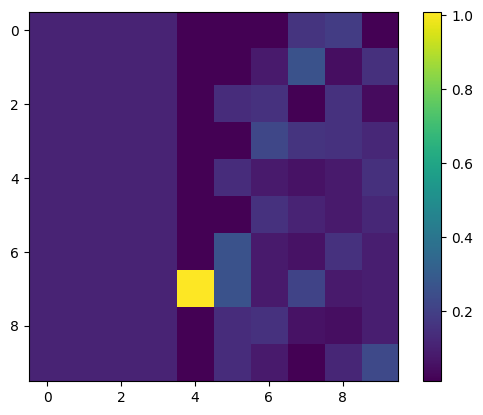

In [23]:
plt.imshow(imag_train1_bkg_transf[5])
plt.colorbar()

In [24]:
imag_train1_transf.shape

(505765, 10, 10)

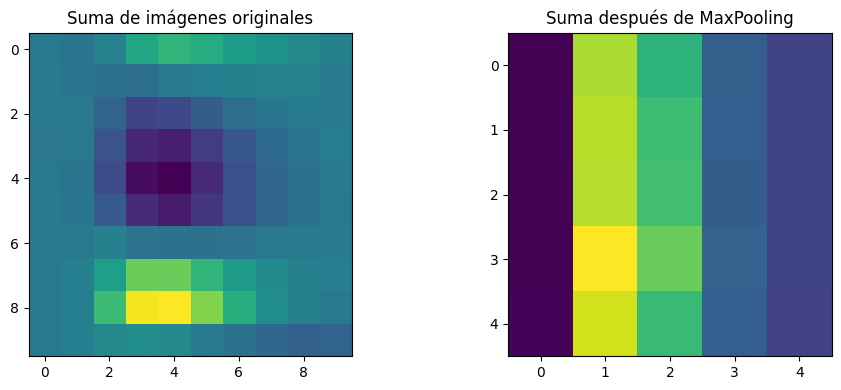

In [28]:
X_pooled = MaxPooling2D(pool_size=(2, 2))(imag_train1_transf.reshape(imag_train1_transf.shape[0], 10, 10, 1)).numpy() 
# Quitar canal para plotear
image_sum_before = np.sum(imag_train1_transf, axis=0).squeeze()  # (10, 10)
image_sum_after = np.sum(X_pooled, axis=0).squeeze()   # (5, 5)

# Mostrar lado a lado
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(image_sum_before, cmap='viridis')
axs[0].set_title("Suma de imágenes originales")

axs[1].imshow(image_sum_after, cmap='viridis')
axs[1].set_title("Suma después de MaxPooling")

plt.tight_layout()
plt.show()


# Conv2D + Sequential DNN Model Building

In [25]:
n_samples, imag_shape_0, imag_shape_1 = imag_train1_transf.shape

#Input Layers ---------------------------------------------------------------------------
input_imag = Input(shape = (imag_shape_0, imag_shape_1,))
input_imag = Reshape((imag_shape_0, imag_shape_1, 1,), name = 'image_input')(input_imag)

input_energy = Input(shape = (1,), name = 'energy_input')

input_position = Input(shape = (1,), name = 'position_input')

#Convolutional 2D Layers ----------------------------------------------------------------
conv2D_ly = Conv2D(filters = 2,
                   kernel_size=(2, 2),
                   padding='same',
                   activation = 'gelu',
                   name = 'conv_ly0')(input_imag)

conv2D_ly = Conv2D(filters = 4,
                   kernel_size=(2, 2),
                   padding='same',
                   activation = 'gelu',
                   name = 'conv_ly1')(conv2D_ly)

#Flatten DNN -----------------------------------------------------------------------------
#Flatten the images
imag_flat = Flatten()(conv2D_ly)

#Concatenate layers:
x_ly = concatenate([imag_flat, input_energy, input_energy], name = 'concatenate_ly')
concat_shape = x_ly.shape[-1]
print(concat_shape)

#Deep Layers
x_ly = Dense(concat_shape, activation = 'gelu')(x_ly)
x_ly = Dense(400, activation = 'gelu')(x_ly)
x_ly = Dense(350, activation = 'gelu')(x_ly)
x_ly = Dense(300, activation = 'gelu')(x_ly)
x_ly = Dense(250, activation = 'gelu')(x_ly)
x_ly = Dense(200, activation = 'gelu')(x_ly)
x_ly = Dense(150, activation = 'gelu')(x_ly)
x_ly = Dense(100, activation = 'gelu')(x_ly)
x_ly = Dense(80, activation = 'gelu')(x_ly)
x_ly = Dense(50, activation = 'gelu')(x_ly)
x_ly = Dense(40, activation = 'gelu')(x_ly)
x_ly = Dense(20, activation = 'gelu')(x_ly)
x_ly = Dense(5, activation = 'gelu')(x_ly)

output_layer = Dense(2, activation = 'sigmoid', name = 'nu_predict')(x_ly)

402


In [26]:
#Model Trainning -----------------------------------------------------------------------
model = Model(inputs = [input_imag, input_energy, input_position], outputs = output_layer)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss = tf.keras.losses.BinaryCrossentropy(), 
              metrics = ['AUC', 'accuracy'])

history = model.fit(x = [imag_train1_transf, energy_train1_transf, position_train1_transf], 
                    y = {'nu_predict':labels_train1}, 
                    epochs = 200, 
                    batch_size = 5000,
                    validation_data=([imag_val_transf, energy_val_transf, position_val_transf], labels_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience = 20, min_delta = 1e-3, monitor="val_loss")],
                    shuffle = True)

Epoch 1/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - AUC: 0.5238 - accuracy: 0.5172 - loss: 0.6883 - val_AUC: 0.7797 - val_accuracy: 0.7711 - val_loss: 0.5803
Epoch 2/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - AUC: 0.7964 - accuracy: 0.7806 - loss: 0.5587 - val_AUC: 0.8195 - val_accuracy: 0.7828 - val_loss: 0.5133
Epoch 3/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - AUC: 0.8353 - accuracy: 0.7800 - loss: 0.4877 - val_AUC: 0.8600 - val_accuracy: 0.7842 - val_loss: 0.4513
Epoch 4/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step - AUC: 0.8610 - accuracy: 0.7835 - loss: 0.4496 - val_AUC: 0.8694 - val_accuracy: 0.7864 - val_loss: 0.4390
Epoch 5/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - AUC: 0.8690 - accuracy: 0.7866 - loss: 0.4390 - val_AUC: 0.8705 - val_accuracy: 0.7874 - val_loss: 0.4375
Epoch 6/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - AUC: 0.8689 - accuracy: 0.7861 - loss: 0.4390 - val_AUC: 0.8709 - val_accuracy: 0.7870 - val_loss: 0.4367
Epoch 7/200
102/

KeyboardInterrupt: 

## Learning Curves

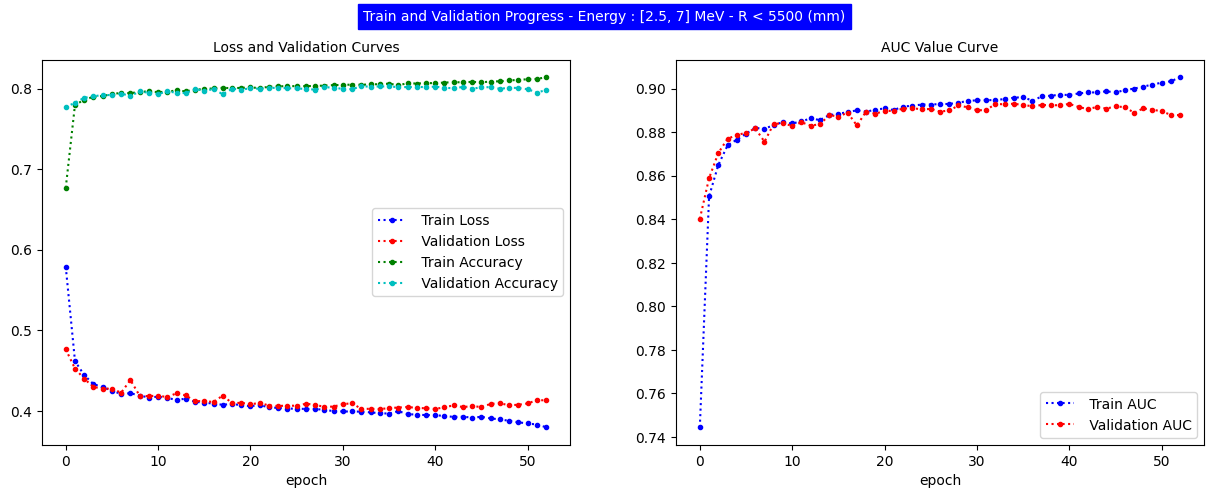

In [33]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
fig, axes = plt.subplots(1,2, figsize=(15, 5))

axes[0].plot(history.history['loss'], 'b:.', label = ' Train Loss')
axes[0].plot(history.history['val_loss'], 'r:.', label = ' Validation Loss')
axes[0].plot(history.history['accuracy'], 'g:.',  label = ' Train Accuracy')
axes[0].plot(history.history['val_accuracy'], 'c:.', label = ' Validation Accuracy')
axes[1].plot(history.history['AUC'], 'b:.',  label = ' Train AUC')
axes[1].plot(history.history['val_AUC'], 'r:.', label = ' Validation AUC')

axes[0].set_title('Loss and Validation Curves', fontsize = 10)
axes[0].set_xlabel('epoch')
axes[0].legend(loc = 'best')
axes[1].set_title('AUC Value Curve', fontsize = 10)
axes[1].set_xlabel('epoch')
axes[1].legend(loc = 'lower right')

#axes[0].set_ylim(0, 1.2)
#axes[1].set_ylim(0, 1.05)

#axes[0].set_xlim(-2, len(history.history['loss']))
#axes[1].set_xlim(-2, len(history.history['loss']))

fig.suptitle(f'Train and Validation Progress - Energy : [2.5, {energy_cut_train}] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white', fontsize = 10)
plt.show()

# Model Predictions

In [34]:
X_sig_pred = model.predict([imag_test_transf_sig, energy_test_transf_sig, position_test_transf_sig])
X_bkg_pred = model.predict([imag_test_transf_bkg, energy_test_transf_bkg, position_test_transf_bkg])

1397/1397 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1397/1397 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [35]:
X_sig_pred

array([[1.00000000e+00, 2.28399487e-11],
       [9.78000402e-01, 2.34874506e-02],
       [1.19225651e-01, 8.79637480e-01],
       ...,
       [2.74390906e-01, 7.24652052e-01],
       [9.87864673e-01, 1.32167125e-02],
       [8.57043505e-01, 1.43250465e-01]], dtype=float32)

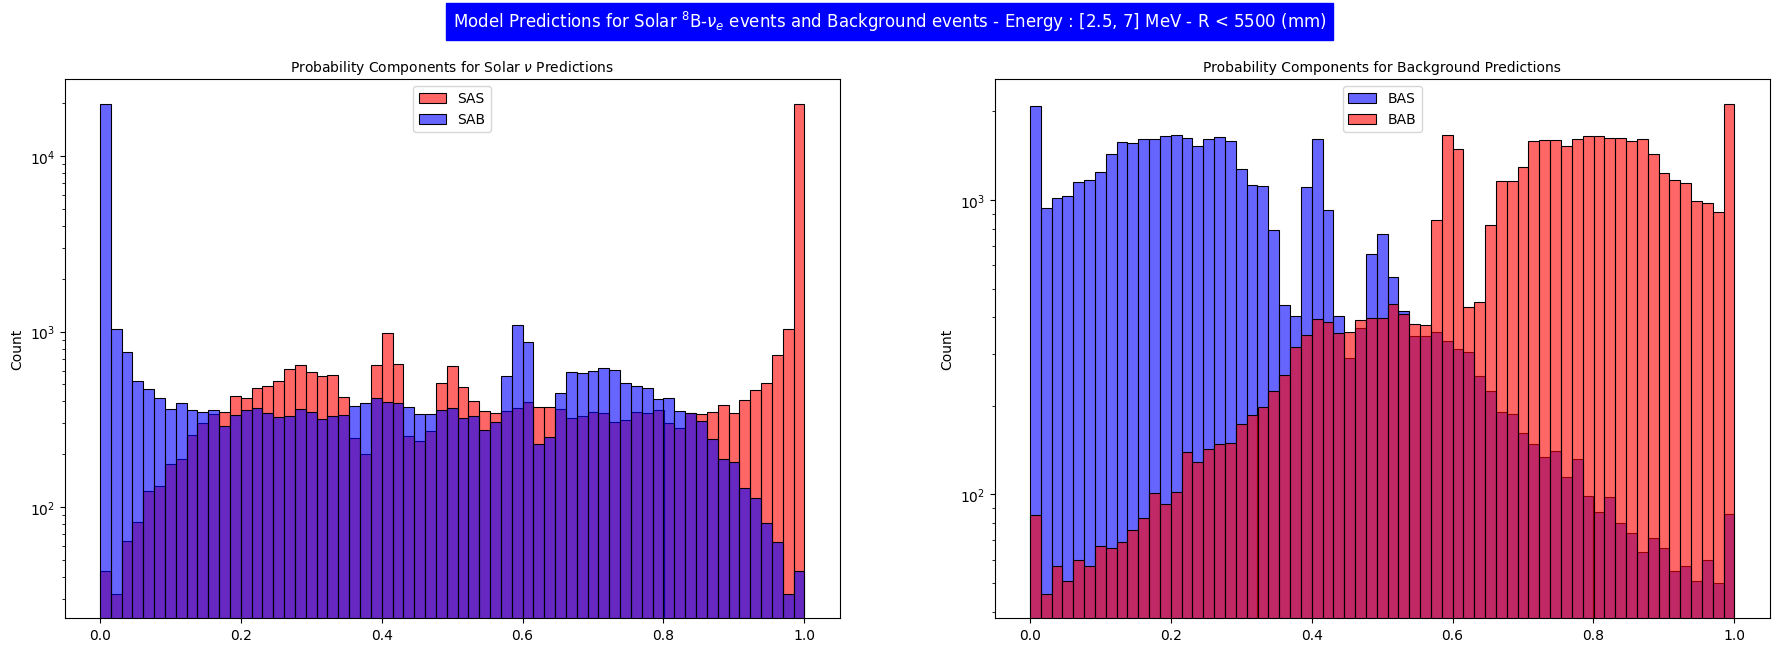

In [36]:
sn.reset_orig
bins = 65
fig, axes = plt.subplots(1, 2,  figsize=(22, 7))

sn.histplot(X_sig_pred[:,0], bins = bins, label = 'SAS', color = 'r', alpha = 0.6, ax = axes[0], log = True)
sn.histplot(X_sig_pred[:,1], bins = bins, label = 'SAB', color = 'b', alpha = 0.6, ax = axes[0])
sn.histplot(X_bkg_pred[:,0], bins = bins, label = 'BAS',color = 'b', alpha = 0.6, ax = axes[1], log = True)
sn.histplot(X_bkg_pred[:,1], bins = bins, label = 'BAB', color = 'r', alpha = 0.6, ax = axes[1])
axes[0].set_title('Probability Components for Solar $ν$ Predictions', fontsize = 10)
axes[1].set_title('Probability Components for Background Predictions', fontsize = 10)
axes[0].legend(loc = 'best')
axes[1].legend(loc = 'best')
plt.suptitle(f'Model Predictions for Solar $^8$B-$ν_e$ events and Background events - Energy : [2.5, {energy_cut_train}] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white')
plt.show()

## ROC Curve

In [37]:
X_pred = np.concatenate((X_sig_pred, X_bkg_pred))              #Predicted
X_exp = np.concatenate((labels_test_sig, labels_test_bkg))     #Expected

# Classification for solar_nu events
fpr_sig, tpr_sig, thresholds_sig = roc_curve(X_exp[:,0], X_pred[:,0])
auc_sig = auc(fpr_sig, tpr_sig)

# Classification for bkg events
fpr_bkg, tpr_bkg, thresholds_bkg = roc_curve(X_exp[:,1], X_pred[:,1])
auc_bkg = auc(fpr_bkg, tpr_bkg)

# Classification overall Model

fpr, tpr, thresholds = roc_curve(np.concatenate((X_exp[:,0], X_exp[:,1])), np.concatenate((X_pred[:,0], X_pred[:,1])))
auc_val = auc(fpr, tpr)

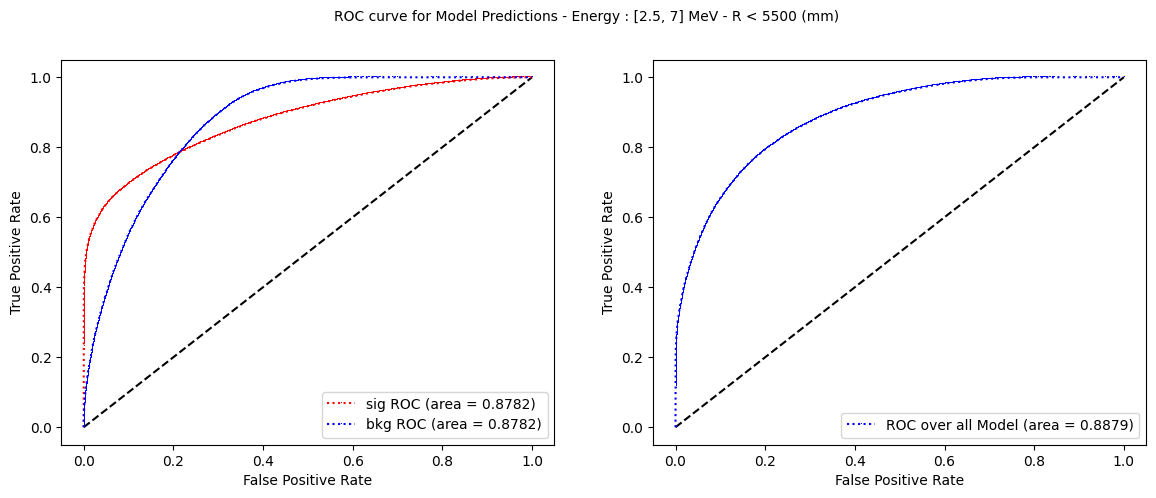

In [38]:
fig, axes = plt.subplots(1, 2,  figsize=(14, 5))


axes[0].plot([0, 1], [0, 1], 'k--') #x=y
axes[0].plot(fpr_sig, tpr_sig, 'r:,', label = 'sig ROC (area = {:.4f})'.format(auc_sig))
axes[0].plot(fpr_bkg, tpr_bkg, 'b:,', label = 'bkg ROC (area = {:.4f})'.format(auc_bkg))

axes[1].plot([0, 1], [0, 1], 'k--') #x=y
axes[1].plot(fpr, tpr, 'b:,', label = 'ROC over all Model (area = {:.4f})'.format(auc_val))

axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')

axes[0].legend(loc = 'lower right')
axes[1].legend(loc = 'lower right')

fig.suptitle(f'ROC curve for Model Predictions - Energy : [2.5, {energy_cut_train}] MeV - R < 5500 (mm)', fontsize = 10)

#plt.savefig('figs/Optimized Models/10x10/ROC.png', format = 'png', bbox_inches = 'tight')
plt.show()

## Recovery Spectrum with thr Values

### Inverse of Data Transformation

In [90]:
energy_sig_rc = scaler_energy_test.inverse_transform([energy_test_transf_sig])[0]
energy_bkg_rc = scaler_energy_test.inverse_transform([energy_test_transf_bkg])[0]

# Volume Normalization + Std Scaler: la formula es (R_ev^3)/(5000^3) y queremos recuperar R_ev
#Recover from Transformation Rule
position_sig_rc = scaler_position_test.inverse_transform([position_test_transf_sig])[0]
position_bkg_rc = scaler_position_test.inverse_transform([position_test_transf_bkg])[0]

#Recover the radius values from the Volume
radi_sig_rc = np.cbrt(position_sig_rc*vol)
radi_bkg_rc = np.cbrt(position_bkg_rc*vol)

### Extract Data Plots

In [91]:
#Idea: A cada loop de thr, agregar a las listas arrays de energia reconstruida y de eficiciencia normalizada, asi cada indice de lista corresponde a un thr

bins_nu = 15             #-> Define how many intervals in energy. Equals to the number of point of norm_eff. PREDEFINED BINS = 20
bins_tl = 8              #-> BINS = 8

thr = [0.95, 0.8, 0.70]  #-> Define the thresholds

prob_sas = X_sig_pred[:,0]      #probiblity of the event of neutrino being detected as neutrino
#prob_bab = X_bkg_pred[:,1]      #probiblity of the event of thallium being detected as thallium
prob_bas = X_bkg_pred[:,0]      #probiblity of the event of thallium being detected as neutrino

en_sig_test_count, en_sig_test_edge = np.histogram(energy_sig_rc, bins = bins_nu)   #Extract interval of binned data
en_bkg_test_count, en_bkg_test_edge = np.histogram(energy_bkg_rc, bins = bins_tl)   #Extract interval of binned data


N_edges_sig = len(en_sig_test_edge)
N_edges_bkg = len(en_bkg_test_edge)

#Information to extract--------------------------------------
nu_energy_in_sas = []
#nu_energy_out_sas = []

tl_energy_in_bas = []
#tl_energy_out_bab = []

#mean normalized eficiency values for signal as signal and bkg as sig
norm_eff_sig_in_sas = []
norm_eff_bkg_in_bas = []

norm_eff_bkg = []

#mean energy within each bin for signal and bkg data
mean_energy_sig = []  
mean_energy_bkg = []   

for thr_i in thr: 

    #Information to save in each loop of threshold --------------
    nu_energy_in_sas_thr = []
    #nu_energy_out_sas_thr = []
    
    tl_energy_in_bas_thr = []
    #tl_energy_out_bas_thr = []

    #normalized eficiency values for signal and bkg for each thr
    #Used to contruct the norm eff plot
    norm_eff_sig_in_sas_thr = np.array([])
    norm_eff_bkg_in_bas_thr = np.array([])

    #mean energy within each bin for signal and bkg data for each thr (aunque acaba siendo el mismo valor medio para cado thr y para los histogramas que preservan el número de bins).
    #Used to contruct the norm eff plot
    mean_energy_sig_thr = np.array([]) 
    mean_energy_bkg_thr = np.array([]) 

    #mean radial values within each bin for signal and bkg data for each thr
    #Used to contruct the norm eff plot
    mean_rad_sig_thr = np.array([]) 
    mean_rad_bkg_thr = np.array([]) 
    
    #----------------------------------------------

    #Extract info for Plot of energy > thr and energy < thr

    #Extract
    for i in np.where(prob_sas >= thr_i)[0]:
        nu_energy_in_sas_thr.append(energy_sig_rc[i])
        
    #for j in np.where(prob_sas < thr_i)[0]:
        #nu_energy_out_sas_thr.append(energy_sig_rc[j])
    
    for m in np.where(prob_bas >= thr_i)[0]:
        tl_energy_in_bas_thr.append(energy_bkg_rc[m])
    
    #for k in np.where(prob_bab < thr_i)[0]:
        #tl_energy_out_spectrum_thr.append(energy_bkg_rc[k])
        
    nu_energy_in_sas.append(np.array(nu_energy_in_sas_thr))
    #nu_energy_out_sas.append(np.array(nu_energy_out_sas_thr))
    tl_energy_in_bas.append(np.array(tl_energy_in_bas_thr))
    #tl_energy_out_bab.append(np.array(tl_energy_out_spectrum_thr))

    #Extract norm_eff and mean nu enery within each bin:
    #1) Extract for solar nu event predictions
    for i in range(N_edges_sig-1):
        #extract edges value of energy at each bin
        energy_edge_i = en_sig_test_edge[i]
        energy_edge_f = en_sig_test_edge[i+1]
    
        #find energy in energy_test_sig between edges values and the model prediction for SAS 
        energy_interval = np.extract((energy_sig_rc >= energy_edge_i) & (energy_sig_rc <= energy_edge_f), energy_sig_rc)
        prob_sas_interval = np.extract((energy_sig_rc >= energy_edge_i) & (energy_sig_rc <= energy_edge_f), prob_sas)
    
        #extract mean energy of binned interval
        mean_energy_interval = np.mean(energy_interval)
        
        mean_energy_sig_thr = np.append(mean_energy_sig_thr, mean_energy_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_sas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_sas_interval >= thr_i
        energy_up_thr = np.extract(condition_thr, energy_interval)
        N_up_thr = len(energy_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_sig_in_sas_thr = np.append(norm_eff_sig_in_sas_thr, norm_eff_interval)

    norm_eff_sig_in_sas.append(norm_eff_sig_in_sas_thr)
    mean_energy_sig.append(mean_energy_sig_thr)
        
    #2) Extract for Tl event predictions
    for i in range(N_edges_bkg-1):
        #extract edges value of energy at each bin
        energy_edge_i = en_bkg_test_edge[i]
        energy_edge_f = en_bkg_test_edge[i+1]
    
        #find energy in energy_test_bkg between edges values and the model prediction for BAS
        energy_interval = np.extract((energy_bkg_rc >= energy_edge_i) & (energy_bkg_rc <= energy_edge_f), energy_bkg_rc)
        prob_bas_interval = np.extract((energy_bkg_rc >= energy_edge_i) & (energy_bkg_rc <= energy_edge_f), prob_bas)
    
        #extract mean energy of binned interval
        mean_energy_interval = np.mean(energy_interval)
        
        mean_energy_bkg_thr = np.append(mean_energy_bkg_thr, mean_energy_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_bas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_bas_interval >= thr_i
        energy_up_thr = np.extract(condition_thr, energy_interval)
        N_up_thr = len(energy_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_bkg_in_bas_thr = np.append(norm_eff_bkg_in_bas_thr, norm_eff_interval)
    
    norm_eff_bkg_in_bas.append(norm_eff_bkg_in_bas_thr)
    mean_energy_bkg.append(mean_energy_bkg_thr)

#Transform lists to array where each arrow correspond to the values of (energy, norm_eff) for a certain thr
mean_energy_sig = np.array(mean_energy_sig)
norm_eff_sig_in_sas = np.array(norm_eff_sig_in_sas)

mean_energy_bkg = np.array(mean_energy_bkg)
norm_eff_bkg_in_bas = np.array(norm_eff_bkg_in_bas)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


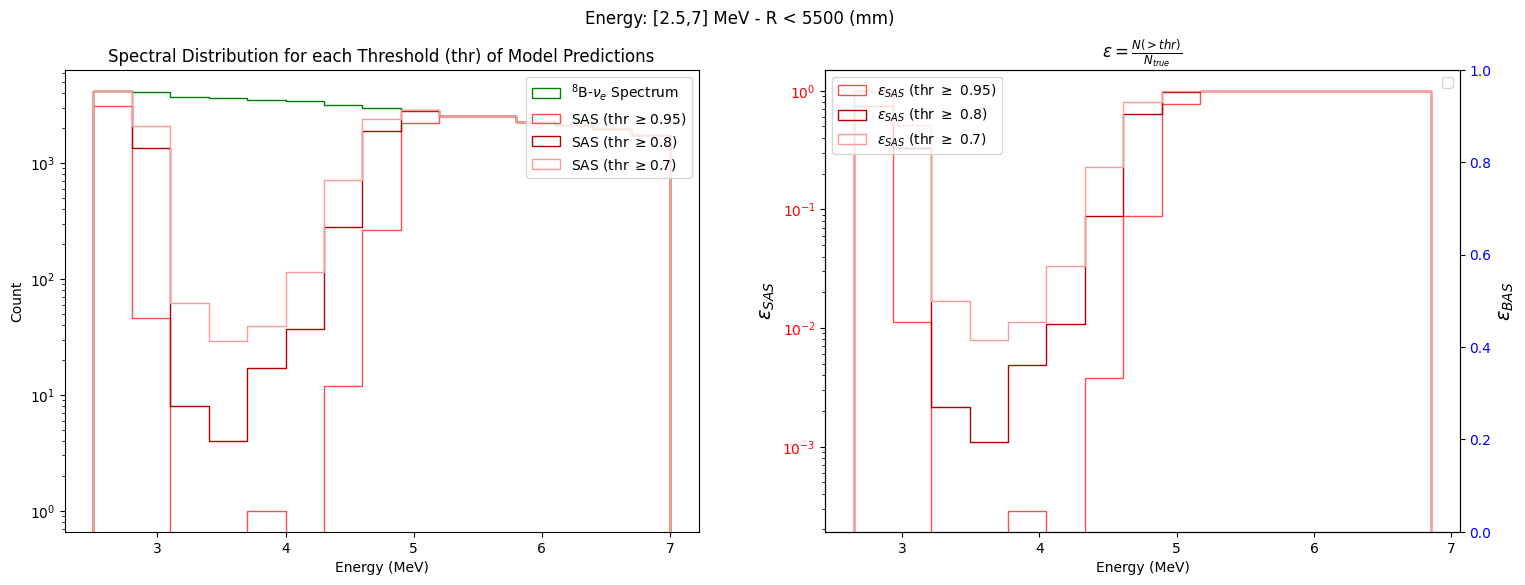

In [92]:
bas_on = False
alpha = 0

#main plot: Test Solar Energy
fig, axes = plt.subplots(1,2, figsize =(18, 6)) 
ax1_1 = axes[1].twinx()  #Right axis for the norm_eff plot due to differences between eff scales

sn.histplot(energy_sig_rc, ax = axes[0], bins = bins_nu, color = 'g' , label = r'$^8$B-$ν_e$ Spectrum', alpha = alpha, element = 'step')

#if bkg_on:
#Bkg test energy plot
#    sn.histplot(energy_bkg_rc, ax = axes[0], bins = bins_tl, color = 'black' , label = r'208-Tl Spectrum', alpha = alpha, element = 'step')

for i_dx, thr_i in enumerate(thr):  
    #Sig Spectral distribution
    sn.histplot(nu_energy_in_sas[i_dx], ax = axes[0], bins = bins_nu, color = red_variants[i_dx] , label = r'SAS (thr $\geq$'+str(thr_i)+')', 
                alpha = alpha, element = 'step')

    #Sig Efficiency normalized by N_true counts
    sn.histplot(x = mean_energy_sig[i_dx], ax = axes[1], bins=len(mean_energy_sig[i_dx]), color = red_variants[i_dx], 
                weights=norm_eff_sig_in_sas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{SAS}$ (thr $\geq$ '+str(thr_i)+')')

    if bas_on:
        #bkg spectra
        sn.histplot(tl_energy_in_bas[i_dx], ax = axes[0], bins = bins_tl, color = blue_variants[i_dx] , label = r'BAS (thr $\geq$'+str(thr_i)+')', 
                    alpha = alpha, element = 'step')

        #bkg efficiency
        sn.histplot(x = mean_energy_bkg[i_dx], ax = ax1_1, bins=len(mean_energy_bkg[i_dx]), color = blue_variants[i_dx], 
                    weights=norm_eff_bkg_in_bas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{BAS}$ (thr $\geq$ '+str(thr_i)+')')
        

axes[0].set_title(r'Spectral Distribution for each Threshold (thr) of Model Predictions', fontsize = 12)
axes[1].set_title(r'$\epsilon = \frac{N(>thr)}{N_{true}}$', fontsize = 12)
axes[0].legend(loc = 'upper right')
axes[1].legend(loc = 'upper left')
ax1_1.legend(loc = 'upper right')

axes[0].set_xlabel('Energy (MeV)')
axes[1].set_xlabel('Energy (MeV)')
axes[1].set_ylabel(r'$\epsilon_{SAS}$', fontsize = 14)
ax1_1.set_ylabel(r'$\epsilon_{BAS}$', fontsize = 14)

axes[1].tick_params(axis='y', labelcolor='r')
ax1_1.tick_params(axis='y', labelcolor='b')


#Agregar marcadores al eje x
#x_en_ticks = np.arange(2.5, 12, 1)   #(x_min, x_max, step)
#axes[0].x_en_ticks(x_ticks)
#axes[1].x_en_ticks(x_ticks)


#axes[0].set_xlim(2.5,12.8)
#axes[1].set_xlim(2.5,12)
#axes[1].set_ylim(np.min(norm_eff_sig_in_sas) - 0.05, 1.05)
#ax1_1.set_ylim(0.0, np.max(norm_eff_bkg_in_bas) + 0.01)

axes[0].set_yscale('log')
axes[1].set_yscale('log')
plt.suptitle(f'Energy: [2.5,{energy_cut_train}] MeV - R < 5500 (mm)')

#if bas_on:
    #plt.savefig('figs/Optimized Models/10x10/Spectral_thr_and_Norm_eff_sig_bkg.png', format = 'png', bbox_inches = 'tight')
#else:
    #plt.savefig('figs/Optimized Models/10x10/Spectral_thr_and_Norm_eff.png', format = 'png', bbox_inches = 'tight')
plt.show()